In [14]:
# --- 1. 환경 설정 셀 (수정된 버전) ---
import os
import sys

# 작업 디렉토리를 올바른 위치로 변경
workspace_path = '/workspace'
os.chdir(workspace_path)

# RFdiffusion 경로를 파이썬이 인식하도록 추가
rfdiffusion_path = os.path.join(workspace_path, 'RFdiffusion')
if rfdiffusion_path not in sys.path:
    sys.path.append(rfdiffusion_path)
import time
import signal
import sys
import random
import string
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

# Colab이 아닌 로컬 환경이므로, RFdiffusion 경로를 직접 추가
if 'RFdiffusion' not in sys.path:
    home_dir = os.path.expanduser("~")
    rfdiffusion_path = os.path.join(home_dir, 'RFdiffusion')
    sys.path.append(rfdiffusion_path)

os.environ["DGLBACKEND"] = "pytorch"

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

# --- Colab의 files.upload()를 대체하는 로컬 파일 처리 함수 ---
def get_pdb(pdb_code=None, use_upload=False):
    if use_upload:
        upload_widget = widgets.FileUpload(
            accept='.pdb', description='PDB 파일 업로드', button_style='info'
        )
        display(upload_widget)
        
        def wait_for_upload(widget):
            while len(widget.value) == 0: time.sleep(0.1)
            uploaded_filename = list(widget.value.keys())[0]
            pdb_content = widget.value[uploaded_filename]['content']
            pdb_filename = "tmp.pdb"
            with open(pdb_filename, "wb") as out: out.write(pdb_content)
            print(f"'{uploaded_filename}'이(가) 'tmp.pdb'로 저장되었습니다.")
            return pdb_filename
            
        return wait_for_upload(upload_widget)
    elif pdb_code is None or pdb_code == "":
        print("PDB 코드를 입력하거나 use_upload=True로 설정하세요.")
        return None
    elif os.path.isfile(pdb_code): return pdb_code
    elif len(pdb_code) == 4:
        pdb_filename = f"{pdb_code}.pdb1"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz && gunzip -f {pdb_code}.pdb1.gz")
        return pdb_filename
    else:
        pdb_filename = f"AF-{pdb_code}-F1-model_v4.pdb"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/{pdb_filename}")
        return pdb_filename

def run_ananas(pdb_str, path, sym=None):
    pdb_filename = f"outputs/{path}/ananas_input.pdb"
    out_filename = f"outputs/{path}/ananas.json"
    os.makedirs(f"outputs/{path}", exist_ok=True)
    with open(pdb_filename,"w") as handle: handle.write(pdb_str)
    cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
    if sym is None: os.system(cmd)
    else: os.system(f"{cmd} {sym}")
    try:
        with open(out_filename,"r") as f: out = json.load(f)
        results, AU = out[0], out[-1]["AU"]
        group, chains, rmsd = AU["group"], AU["chain names"], results["Average_RMSD"]
        print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")
        C = np.array(results['transforms'][0]['CENTER'])
        A = [np.array(t["AXIS"]) for t in results['transforms']]
        new_lines = []
        for line in pdb_str.split("\n"):
            if line.startswith("ATOM"):
                chain = line[21:22]
                if chain in chains:
                    x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
                    if group[0] == "c": x = sym_it(x,C,A[0])
                    if group[0] == "d": x = sym_it(x,C,A[1],A[0])
                    coord_str = "".join([f"{a:8.3f}" for a in x])
                    new_lines.append(line[:30]+coord_str+line[54:])
            else: new_lines.append(line)
        return results, "\n".join(new_lines)
    except Exception as e:
        print(f"AnAnaS 결과 처리 중 오류 발생: {e}")
        return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):
    def run_command_and_get_pid(command):
        pid_file = '/dev/shm/pid'
        os.system(f'nohup {command} > /dev/null & echo $! > {pid_file}')
        with open(pid_file, 'r') as f: pid = int(f.read().strip())
        os.remove(pid_file)
        return pid
    def is_process_running(pid):
        try: os.kill(pid, 0)
        except OSError: return False
        else: return True
    run_output = widgets.Output()
    progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
    display(widgets.VBox([progress, run_output]))
    for n in range(steps):
        if os.path.isfile(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
    pid = run_command_and_get_pid(command)
    try:
        fail = False
        for _ in range(num_designs):
            for n in range(steps):
                wait = True
                while wait and not fail:
                    time.sleep(0.1)
                    if os.path.isfile(f"/dev/shm/{n}.pdb"):
                        with open(f"/dev/shm/{n}.pdb", "r") as f: pdb_str = f.read()
                        if "TER" in pdb_str or "ENDMDL" in pdb_str: wait = False
                        elif not is_process_running(pid): fail = True
                    elif not is_process_running(pid): fail = True
                if fail:
                    progress.bar_style = 'danger'; progress.description = "failed"
                    break
                else:
                    progress.value = (n+1) / steps
                    if visual != "none":
                        with run_output:
                            run_output.clear_output(wait=True)
                            if visual == "image":
                                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                                fig = plt.figure(); fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1); plt.show()
                            if visual == "interactive":
                                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                                view.addModel(pdb_str,'pdb'); view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                                view.zoomTo(); view.show()
                if os.path.exists(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
            if fail:
                progress.bar_style = 'danger'; progress.description = "failed"
                break
        while is_process_running(pid): time.sleep(0.1)
    except KeyboardInterrupt:
        os.kill(pid, signal.SIGTERM); progress.bar_style = 'danger'; progress.description = "stopped"
    
def run_diffusion(contigs, path, pdb=None, iterations=50, symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, num_designs=1, visual="none"):
    full_path = f"outputs/{path}"; os.makedirs(full_path, exist_ok=True)
    opts = [f"inference.output_prefix={full_path}", f"inference.num_designs={num_designs}"]
    if chains == "": chains = None
    if symmetry in ["auto","cyclic","dihedral"]:
        if symmetry == "auto": sym, copies = None, 1
        else: sym, copies = {"cyclic":(f"c{order}",order), "dihedral":(f"d{order}",order*2)}[symmetry]
    else: symmetry = None; sym, copies = None, 1
    contigs_list = contigs.replace(","," ").replace(":"," ").split()
    is_fixed, is_free = False, False; fixed_chains = []
    for contig in contigs_list:
        for x in contig.split("/"):
            a = x.split("-")[0]
            if a and a[0].isalpha():
                is_fixed = True
                if a[0] not in fixed_chains: fixed_chains.append(a[0])
            if a.isnumeric(): is_free = True
    if len(contigs_list) == 0 or not is_free: mode = "partial"
    elif is_fixed: mode = "fixed"
    else: mode = "free"
    if mode in ["partial","fixed"]:
        pdb_str = pdb_to_string(pdb, chains=chains)
        if symmetry == "auto":
            a, pdb_str = run_ananas(pdb_str, path)
            if a is None: print(f'ERROR: no symmetry detected'); symmetry = None; sym, copies = None, 1
            else:
                if a["group"][0] == "c": symmetry = "cyclic"; sym, copies = a["group"], int(a["group"][1:])
                elif a["group"][0] == "d": symmetry = "dihedral"; sym, copies = a["group"], 2 * int(a["group"][1:])
                else: print(f'ERROR: detected symm ({a["group"]}) not supported'); symmetry = None; sym, copies = None, 1
        elif mode == "fixed": pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)
        pdb_filename = f"{full_path}/input.pdb"
        with open(pdb_filename, "w") as handle: handle.write(pdb_str)
        parsed_pdb = parse_pdb(pdb_filename)
        opts.append(f"inference.input_pdb={pdb_filename}")
        if mode in ["partial"]:
            iterations = int(80 * (iterations / 200)); opts.append(f"diffuser.partial_T={iterations}")
            contigs_list = fix_partial_contigs(contigs_list, parsed_pdb)
        else: opts.append(f"diffuser.T={iterations}"); contigs_list = fix_contigs(contigs_list, parsed_pdb)
    else:
        opts.append(f"diffuser.T={iterations}"); parsed_pdb = None
        contigs_list = fix_contigs(contigs_list, parsed_pdb)
    if hotspot is not None and hotspot != "": opts.append(f"ppi.hotspot_res=[{hotspot}]")
    if sym is not None:
        sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
        if add_potential: sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'", "potentials.olig_intra_all=True","potentials.olig_inter_all=True", "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
        opts = sym_opts + opts; contigs_list = sum([contigs_list] * copies,[])
    opts.append(f"'contigmap.contigs=[{' '.join(contigs_list)}]'")
    opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
    print("mode:", mode); print("output:", full_path); print("contigs:", contigs_list)
    run_script_path = "/workspace/RFdiffusion/run_inference.py"
    opts_str = " ".join(opts)
    cmd = f"python {run_script_path} {opts_str}"
    print(cmd)
    run(cmd, iterations, num_designs, visual=visual)
    for n in range(num_designs):
        pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb", f"outputs/traj/{path}_{n}_Xt-1_traj.pdb", f"{full_path}_{n}.pdb"]
        for pdb_file in pdbs:
            if os.path.exists(pdb_file):
                with open(pdb_file,"r") as handle: pdb_str = handle.read()
                with open(pdb_file,"w") as handle: handle.write(fix_pdb(pdb_str, contigs_list))
    return contigs_list, copies

print("✅ Setup cell is ready.")

✅ Setup cell is ready.


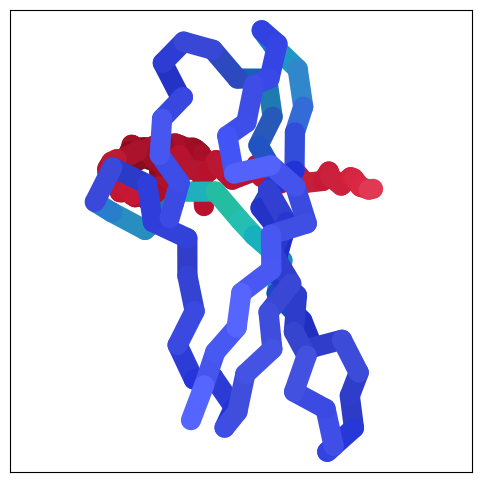

In [ ]:
# --- 바인더 디자인 실행 셀 (수정된 버전) ---

# 1. 파라미터 설정
name = "0907-50-600"
contigs = "C311-391/0 100-100"
hotspot = "C331,C360,C378,C381,C323"
iterations = 50
num_designs = 600
visual = "image"

# --- 2. 업로드한 PDB 파일 경로 직접 지정 ---
# 여기에 1단계에서 업로드한 PDB 파일의 정확한 이름을 입력하세요.
pdb_filename = "4k9e_c.pdb" 
pdb = os.path.join("/workspace", pdb_filename)

# 3. RFdiffusion 실행
# --- 이 아랫부분이 수정되었습니다 ---

# 기본 실행 이름(폴더명으로 사용될)을 설정합니다.
base_name = name
output_dir = f"outputs/{base_name}"

# 만약 동일한 이름의 폴더가 이미 존재하면, 중복을 피하기 위해 랜덤 문자열을 뒤에 붙입니다.
while os.path.exists(output_dir):
    random_suffix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))
    base_name = f"{name}_{random_suffix}"
    output_dir = f"outputs/{base_name}"

# run_diffusion 함수는 이 path를 파일 이름의 접두사로 사용합니다.
# 예: path가 "8051/8051" 이면, 결과는 outputs/8051/8051_0.pdb 로 저장됩니다.
path = os.path.join(base_name, base_name)

print(f"✅ 결과가 저장될 폴더: {output_dir}")
# --- 수정된 부분 끝 ---


flags = {
    "contigs": contigs, "pdb": pdb, "iterations": int(iterations),
    "hotspot": hotspot, "path": path, "num_designs": int(num_designs),
    "visual": visual, "symmetry": "none", "order": 1, "chains": "", "add_potential": True
}

for k, v in flags.items():
    if isinstance(v, str):
        flags[k] = v.replace("'", "").replace('"', '')

contigs, copies = run_diffusion(**flags)

# --- 마지막 출력 메시지도 수정되었습니다 ---
print(f"✅ RFdiffusion 실행 완료! 결과는 '{output_dir}' 폴더에 저장되었습니다.")

In [21]:
#@title Display 3D structure {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "chain" #@param ["rainbow", "chain", "plddt"]
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),
                              alphabet_list,
                              pymol_color_list):
          view.setStyle({'chain':chain},{'cartoon': {'color':c}})
    else:
      view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop': 'backAndForth'})
    view.show()
  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))


if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [16]:
%%time
#@title run **ProteinMPNN** to generate a sequence and **AlphaFold** to validate
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
initial_guess = True #@param {type:"boolean"}
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = True #@param {type:"boolean"}
rm_aa = "C" #@param {type:"string"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
#@markdown - for **binder** design, we recommend `initial_guess=True num_recycles=3`

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
opts = ' '.join(opts)
!python -m colabdesign.rf.designability_test {opts}
import os
import pandas as pd

# 결과 파일 경로 설정
best_pdb_path = f"outputs/{path}/best.pdb"
all_results_path = f"outputs/{path}/all_results.csv"

print("\n----------------------------------------------------")
try:
    # 모든 결과 요약 출력
    if os.path.exists(all_results_path):
        print("📊 전체 디자인 결과 요약:")
        df = pd.read_csv(all_results_path)
        print(df[['design', 'n', 'plddt', 'rmsd']].to_string(index=False))
        print("----------------------------------------------------")

    # Best 모델 정보 읽어오기
    with open(best_pdb_path, "r") as f:
        info = f.readline().strip().split()
        design_num = info[3]
        seq_num = info[5]
        rmsd_val = info[7]

    # 최종 Best 모델 정보 출력
    print(f"🏆 Best 모델이 선정되었습니다! 🏆")
    print(f"   - 모델 번호: design {design_num} / sequence {seq_num}")
    print(f"   - RMSD 값: {rmsd_val}")
    print("----------------------------------------------------")

except FileNotFoundError:
    print("⚠️ 'best.pdb' 파일을 찾을 수 없습니다. 스크립트 실행에 문제가 있었을 수 있습니다.")

{'pdb':'outputs/0907-50-600/0907-50-600_0.pdb','loc':'outputs/0907-50-600/0907-50-600','contigs':'C311-391:100-100','copies':1,'num_seqs':8,'initial_guess':True,'use_multimer':True,'use_soluble':False,'num_recycles':3,'rm_aa':'C','num_designs':600,'mpnn_sampling_temp':0.1}
protocol=binder
2025-09-08 01:29:37.727893: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
running proteinMPNN...
running AlphaFold...
design:0 n:0 mpnn:1.127 plddt:0.827 i_ptm:0.054 i_pae:28.355 rmsd:57.177 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKKKKEEEEKKKEEEEKKKKEEEKLKKEREEAKKRAEEQRFLEEALILQRAETGVADEEEAKKMSREEFEARRAALAARDPARAAALEAEFAALRAN
design:0

design:3 n:6 mpnn:0.999 plddt:0.621 i_ptm:0.055 i_pae:28.880 rmsd:70.894 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEIIKEAAKYAGELERIKVIEEEGEESKKLAEKRGKFAEKLMEEKAKSLKTLEELEKLKKEVKKELEKAKKELEEKKKKEKEEKEKELKEKLEKLKELL
design:3 n:7 mpnn:1.031 plddt:0.613 i_ptm:0.063 i_pae:26.900 rmsd:49.990 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEVIEKAAKAAGELAYIKVIEEEGEEAKELAEKRAKFAAERMRYEMESKETLEEAKKLLEEVEKELEEAKERRKKKKKEEEERKKKEEEERRKKELEKL
design:4 n:0 mpnn:1.270 plddt:0.497 i_ptm:0.056 i_pae:27.441 rmsd:47.931 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALEELAKALKALAAAAAPLATAARLARGAALAAAAAAGPASAAAAAAALAASPANQAALAFYQAYKAELEARKEREKKEKKEKEEKEKKELEELEKKLKE
design:4 n:1 mpnn:1.327 plddt:0.728 i_ptm:0.060 i_pae:27.837 rmsd:58.198 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LLEKLLKLLKELAEKLKPLLTEATLKKGEELAALLAEGPESKAKAEALLAESPENQAALDFYKKLKAEEKEREERAK

design:7 n:7 mpnn:1.157 plddt:0.875 i_ptm:0.101 i_pae:25.529 rmsd:49.572 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEKKKKEEEELKKFLEKLELEKEREKAKIEEEARKKKAELDAKYKKELAAAAAAGDEAAKKELEKKRKEELAKLKKEEEEKKKKVEEEYKKKLEEYLKE
design:8 n:0 mpnn:1.180 plddt:0.904 i_ptm:0.084 i_pae:26.267 rmsd:58.518 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKRKEEEEKEKEEKKKKEEEEKKKEEEEKKKEEEERERKRKEEEEEKKREEIEKKKKEIEELKKEVEKLKKLAKEDPSYKPEYEKKEKELEKLEAEL
design:8 n:1 mpnn:1.179 plddt:0.889 i_ptm:0.073 i_pae:27.197 rmsd:59.146 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKKEKEKEEEKKKEEEEKEKEKKKKLEEEKKKKEEEEKKEEEKKKEEEEKKKEELKKEIEELEKEVKKLEELTKKDPSYKPEYEKLKKKLEELKKKL
design:8 n:2 mpnn:1.161 plddt:0.915 i_ptm:0.071 i_pae:27.446 rmsd:67.161 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEERERRREEEERRKREEEERKRREEEEKKREEEERKKKEEERKKEEEEKKLEELKKKIEELEKEAKKLEKLTK

design:11 n:7 mpnn:0.945 plddt:0.854 i_ptm:0.080 i_pae:25.682 rmsd:39.158 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SSLAETRARAFEKIVELAKKLAAKDLRRLAALARRAARALERGDAAAAAAARDELLAELAELGVAAELSEEELAALRAATAEELRELAEKLLAIAEEKEA
design:12 n:0 mpnn:1.096 plddt:0.882 i_ptm:0.073 i_pae:25.907 rmsd:52.876 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEEIKEKVKAEEEALLKKFEEKYEKAKKASKEERLEILREMEKEREKLKEEAKKYKELAADPSISEEEKAEYKYKAEAYERAAKRLEELIKEYEEEEKK
design:12 n:1 mpnn:1.150 plddt:0.875 i_ptm:0.083 i_pae:25.504 rmsd:48.506 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAEEIKKEIEEEEEKLLKEAEARYEKAKKASREEALEMLREMEKEREKLKEKSEEYRKKAEDPSISELEKLKYLYKAEAYDRVAKHIEELIEKYEKERKK
design:12 n:2 mpnn:1.028 plddt:0.877 i_ptm:0.071 i_pae:26.343 rmsd:57.228 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKEEIKKEVEKEKKEKLEEIEKKYEEAKKKSKEERLKILEEMEKYKEKLKEEAKKYEEKAADPEISEEEKYKY

design:15 n:7 mpnn:1.104 plddt:0.705 i_ptm:0.086 i_pae:26.077 rmsd:61.246 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKREEEREERYRKELLKESIEEVKKRLAAKEPELAARRAEAAALAAAHGPDGPPEVQARLAAAAAALAAYEAEKAELEKELKKKEEEIIKKEKEKRK
design:16 n:0 mpnn:1.010 plddt:0.902 i_ptm:0.093 i_pae:25.912 rmsd:70.503 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKKEKKKKLEEKLKEEKKKLKEKKEELEKKAKEYEEKAKEAEKKGKKEEAKKLKEKAKEAKEKAKEYEKKLKEVEEKEKELKEELRKEEEEKIKEEE
design:16 n:1 mpnn:1.074 plddt:0.908 i_ptm:0.078 i_pae:26.868 rmsd:72.068 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKLKELEKKKKEYEEEIKKLKEEKEKLKAKAKEKEKKAKEKKKEGKEEEAKKLEEEAKEYLKKAEEKEKEIKKAEEEKKKWKEEIKKEEKKEIEEKE
design:16 n:2 mpnn:1.037 plddt:0.894 i_ptm:0.086 i_pae:26.382 rmsd:65.338 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEKKKEEEIEKEYKEKLEELKKKKEELEKKAKEYEEKAEKAEKEGKEEEAKKLKEKAKEYKKKAEEYKKK

design:19 n:7 mpnn:1.105 plddt:0.842 i_ptm:0.072 i_pae:26.892 rmsd:38.172 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EFEKKLKEIEEKLKKLKEESEEIKKKLELKEKKVEELKKKVEELKKEGKEEEAKEAEKKLKELKAEVEKEREETEKKLKEEIEKTTKELKEELEKLIKEL
design:20 n:0 mpnn:1.139 plddt:0.896 i_ptm:0.092 i_pae:25.919 rmsd:40.161 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELKKKLEEKIEELKKELEKEKEEIRKKRREEEKKLRKKYDELAKKAKTEEEKEKILKEGEEEIRKIRKEAEEKIKELEKKYEEKIKKLKEEEEKKLKA
design:20 n:1 mpnn:1.190 plddt:0.878 i_ptm:0.067 i_pae:26.994 rmsd:38.230 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAEAKAKLEAELAAREAELEKEIEKIRKETREKERELRKKYLEKAEKAKTPEEKEKILKEGEEEIRRIRKEAEEKIEELRKKYEAEIAALKAAAEAKAAA
design:20 n:2 mpnn:1.158 plddt:0.885 i_ptm:0.085 i_pae:26.045 rmsd:45.601 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKLLEEIKKKIEELEKELEEEIEKIRKETREEILKKRKEYEEKAAKAKTEEEKKEILEEMEKEIREIRKKAE

design:23 n:7 mpnn:1.174 plddt:0.875 i_ptm:0.094 i_pae:25.536 rmsd:36.867 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKKKEKEEEEKKKKEEKEKEEKEKKERKKELEEERKKREELKKAEEFVKNFPEKLKELEKKKKEAQGSENAEEIKKKIDAEIEELKKKEEEAKEKLK
design:24 n:0 mpnn:1.045 plddt:0.802 i_ptm:0.103 i_pae:23.556 rmsd:41.925 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AKHYLQLKEKGELEGVVAKAVALLSQLTPEDLEAHRPLFLAILRAAGLSEAEAEALHAELVEWLGLSEEERAARLREFFLAHPEFWPVLLEALEAILAAK
design:24 n:1 mpnn:1.076 plddt:0.779 i_ptm:0.169 i_pae:20.932 rmsd:46.114 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKHYLILLEKGEIESVVEKLVELLKKLTPEDLKKYRPIILEILKKAGFSEEESLEIIEELIEWLEMSDEERKKALKEFFLKYPELVPVLEEAIKAVVAAK
design:24 n:2 mpnn:1.078 plddt:0.751 i_ptm:0.095 i_pae:23.911 rmsd:41.507 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AKHYLQLKEKGELQSVVDKMVELLSKLSPEDFIEHKPIFLEILKEAGISEEEAEEIWEEIVEWLELTEEERRK

design:27 n:7 mpnn:1.035 plddt:0.896 i_ptm:0.081 i_pae:25.392 rmsd:46.874 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELEELKAKAEELHAKIAELVPKLEEAGKDIPEEDKPLYDEMMAKIKKVLADKNDIEAAKEAAKLAKQLSKHEKHKELYKELEELLNELAEALEKIKELE
design:28 n:0 mpnn:1.243 plddt:0.537 i_ptm:0.071 i_pae:25.986 rmsd:45.214 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEKKELEKKKEEEKKKELEEKEKEKLEEGKKMLEELKPYFEKGEEFYEALNEEVIEKLKVIIDEIKKEASLEEREKLEKAFEELLKKHEELKKKKAEE
design:28 n:1 mpnn:1.215 plddt:0.572 i_ptm:0.058 i_pae:27.454 rmsd:54.347 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AKEKEEEEKKKKEEEEKEKLKKEREEKLKKGKEVYEKLKEYKEKGEEFIKALTEEVLEYLEVLRNEKLLTASEEERKKLVEEFEKLKEEHKKYKKEEAEK
design:28 n:2 mpnn:1.201 plddt:0.645 i_ptm:0.062 i_pae:27.706 rmsd:61.054 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKRKEEEKKEKERKKKLEEEREKKIKEGKEVLEKLKEYLEKGEEFIKALNEEVLEKLEVLRNEELLTASE

design:31 n:7 mpnn:1.122 plddt:0.882 i_ptm:0.095 i_pae:24.690 rmsd:32.794 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEILEEMEKKQAELEKKWEELIKEAEEVDPEKAEEYKKLYEEYKEKLKKLIEELKKSKDEEEKKKIYEKYNKYLEEIEKKLKEIEEEIKKLKEEKEKEE
design:32 n:0 mpnn:1.116 plddt:0.814 i_ptm:0.056 i_pae:27.957 rmsd:53.672 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAKAAAEAAAAEQAKLKEEAIKALDYEELAKELEKKLKEGNKEVEEKLKEAKKKAKELKNKYEKLTEEDKKEVEKIHEEKEKKRKEEEEK
design:32 n:1 mpnn:1.123 plddt:0.482 i_ptm:0.064 i_pae:26.641 rmsd:40.897 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAAAAALAAAAAAAAAAAAAAAQAALAAAARQAPAYAELAAALKKKLEEGDKSVEEALKAAKAKADAALNLRAKLTPEQQAAVDAIHAARAAEAAAKAAA
design:32 n:2 mpnn:1.173 plddt:0.697 i_ptm:0.051 i_pae:28.433 rmsd:52.711 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELLKKLKEKEEEEKKKKEEQKKLKEEAKKALDYKELAEELEKKYEEGDKSVEEELKKAKEKMKERLNLFN

design:35 n:7 mpnn:0.990 plddt:0.870 i_ptm:0.067 i_pae:27.167 rmsd:45.239 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEFEKKLEEIKEKAKKAEKEAKELKKKAKEAEKKAKEYEEEAKKVEEEAKKTGGEKKEEAEKLKKEAEKLKKEAEKYKKEAEELEKKAKELKKEAEELKK
design:36 n:0 mpnn:1.149 plddt:0.679 i_ptm:0.085 i_pae:27.037 rmsd:66.978 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SFEERRRKRKEEREKEKEEFEKVKKELEEERKKLEEELAAARAEVAARRAEAAALTDRPELAAKLKAEAEARLAAAEAEVEKKLEELKKKEEEMEEKREK
design:36 n:1 mpnn:1.044 plddt:0.860 i_ptm:0.114 i_pae:24.963 rmsd:71.863 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SFEERRKKREEERKKKEEKFKEKEKELKEKEEKLKKELEEAKKKVEKKKKEAEKLKDKPEEQKKLLEEAKKELEEKEKKVKEELKKLEKEKEKMEKEKEE
design:36 n:2 mpnn:1.116 plddt:0.738 i_ptm:0.131 i_pae:25.035 rmsd:48.512 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SFLERREERKKKREEEKEKIKKEKEEIEKKLKEIEKKLAEAEAAVAARRAEAAALADKPEERARLLAEADAEL

design:39 n:7 mpnn:1.216 plddt:0.871 i_ptm:0.050 i_pae:29.382 rmsd:56.758 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/HMLSEEELKEAEEVIEEILKKYQEAKKEIKKNKEDEEKRKEIIKELEKYLKEIEESAKKNKEIINEVIKELLENLKKFLEELKKELEEEKKKKEKLEELE
design:40 n:0 mpnn:1.192 plddt:0.832 i_ptm:0.112 i_pae:24.054 rmsd:38.170 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKEEEEKKLDKENEKRREKRREIRKKATEEFKEIEEEIEKLKKEGKSLEEIKKKMLEKLEKKRKEIEEAGGSEEELETIELVEEELKKLFEELEKEEEEA
design:40 n:1 mpnn:1.133 plddt:0.821 i_ptm:0.092 i_pae:25.485 rmsd:45.499 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKKKEEDEKLKKKLEKRKKIQEEADKLTKEYEEEIKKLKEEGVSLEEIKEKMKKKLEEEEKKLKEEGKSEEEFETMKLVKEELEKLFKELEKEEELK
design:40 n:2 mpnn:1.166 plddt:0.791 i_ptm:0.087 i_pae:25.951 rmsd:40.173 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKEEEEKLDEENKKRREERKRIQNKATEISKKIEEEIEKLKKEGVSLEEIKKKVKEKLEKEKKKLEEEGASP

design:43 n:7 mpnn:1.343 plddt:0.847 i_ptm:0.055 i_pae:28.835 rmsd:83.850 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTEEEIERIRKEKEEEERKREEEERKKREEEEEEKRKKERERRAKETAEERAARAAARAAAAAAEEAARAAAAEAAAAAAEAAAAAAELAELAERLEALK
design:44 n:0 mpnn:1.067 plddt:0.843 i_ptm:0.079 i_pae:26.091 rmsd:56.428 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NEKKEKEKLDKELKKAKEELEKIKKEEKEVEEKKKELEKRKKELEEKKKKLKELGLGAEGLEEEEKELEEEKEEIEKKERELKRKKKKAEKKLEEIEKKK
design:44 n:1 mpnn:1.021 plddt:0.826 i_ptm:0.085 i_pae:26.383 rmsd:56.371 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEEEKKKLEEELKKAKEELEKLEKEEKEVEKEEEKLKKEEEELKKKKEELKKKGEKAEGLEEKEKELEERKKKIDEKKSEIKRKKKKAEEKLKEVEEKL
design:44 n:2 mpnn:1.040 plddt:0.829 i_ptm:0.090 i_pae:25.586 rmsd:36.854 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEKKKKELEEKLKEAEKKLKELEKKEKEVEEREKELEKKKKELEKKEEELKKKGEKAEGLEEEKKKLEEEEE

design:47 n:7 mpnn:1.052 plddt:0.813 i_ptm:0.076 i_pae:26.621 rmsd:53.077 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MLEELLKKKLEELKKEEKEIKELEEKAEKLKEEAEKLKKKAEELEEKKKLGKLNEKDIEELKEIKKKAEEVKKKAEEVKKKLEEKKKKKEEELKKIKEEK
design:48 n:0 mpnn:1.055 plddt:0.769 i_ptm:0.079 i_pae:26.397 rmsd:62.594 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLKELLEKEKLEKEKKEIEEKIKKLKEEAKEKKKEIKELEKKAEELETKLEKEIKEKGPISEEELKKRKKEIEELKKKAEELKKELEKLEKEAKKLKEEL
design:48 n:1 mpnn:1.095 plddt:0.803 i_ptm:0.070 i_pae:27.147 rmsd:47.135 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELEKKKKEKEEEKKKIEEEIEKLKKEAKKKKEEIKKVEKEAEKYKTELEKEIAANGPISPEELAKKLKKLEELQKKAEELKKEAEKLKKEAEELKKKL
design:48 n:2 mpnn:1.010 plddt:0.874 i_ptm:0.090 i_pae:25.431 rmsd:61.773 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEEEKKKKEEEEKKELEKKIEELKKEEKELKKKAKELRKEAEEKKTKLEKEVKEKGPISPEELEKKLEEIK

design:51 n:7 mpnn:1.122 plddt:0.839 i_ptm:0.057 i_pae:27.550 rmsd:63.201 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EESKKILKEILEKRIKKLEEERKAREAAFAAEAAALEAEIAALRAEAAEASAARAEALAAEVAALEAERAAREAEFEAEAAKIEAEIEELKKKLEKLEKS
design:52 n:0 mpnn:1.113 plddt:0.865 i_ptm:0.058 i_pae:28.071 rmsd:44.001 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEKEKKKKEEEEKKKKEKEEKEKKKKEEEEEKEKRKKELEKAEKEYKELLKKAKELEEKAKKLKEEGGDPKEIEELLKEAKALKEEAEKKKAEVKKK
design:52 n:1 mpnn:1.105 plddt:0.832 i_ptm:0.064 i_pae:27.389 rmsd:33.923 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKEEKEREEKEKKREEEKKKKEEEEKKKKKEKEERKEELEKVEKEYKKLLEEAEKLREEAKKLEEAGGDPEEIKALKEKAEKLKEEAEKLKEEVLKK
design:52 n:2 mpnn:1.115 plddt:0.816 i_ptm:0.061 i_pae:27.367 rmsd:29.247 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEKKKKEKEKEEKKKKEKEEKEEKKKKEEEEKEKRKEKLEEVEKEYKRLLEKAKRLREEAKRLREEGGDP

design:55 n:7 mpnn:1.097 plddt:0.681 i_ptm:0.074 i_pae:26.442 rmsd:35.541 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEISKLKKLTKETLKKLEELKKKREELLKKAKETGSEKLKEEAEKLKEEMKKLEKKLKEIIEKIKKGESFEKIEKEFEEKEKKEEEELKKELEKKKKLE
design:56 n:0 mpnn:1.170 plddt:0.498 i_ptm:0.060 i_pae:27.579 rmsd:51.845 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKKKEEEKEAEKKAHAEEVKAEVAAGAAAVVALLAATLASPALRPLAVAFVFAFALLAKLKELATLKTREEYKKERAALAAEAAAAAAAAVAAALAA
design:56 n:1 mpnn:1.120 plddt:0.535 i_ptm:0.068 i_pae:27.405 rmsd:53.590 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEERKKEEEKEEERKKLREEVLAAVAALAAAVAALGAALAADPALAPLLAALAAARAFLARLRKLATMKTREEYRAESARLLAEAAAAAAAAVAAALAA
design:56 n:2 mpnn:1.257 plddt:0.531 i_ptm:0.072 i_pae:26.342 rmsd:53.205 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKKKEEEKEKEKEDLKAKIKAAVAAGAALAAALFAATLANPALRPLAVAFEYAAAYLKELEKLAELETEE

design:59 n:7 mpnn:1.280 plddt:0.700 i_ptm:0.075 i_pae:26.362 rmsd:53.140 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEKEVKEKIKKIAEEIKKAKEEIAKAKAEAEAALAAYLKAHGAEITPEQLAEILAAIAKEKEEAEKKLEKKKKEAEKKQDELEKELKEKKEKEKEEKEK
design:60 n:0 mpnn:1.236 plddt:0.632 i_ptm:0.070 i_pae:25.921 rmsd:44.987 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SRYEKLKEELAKKEAEAAAAALAALGPLAATLARVAELLAADPALAAEHAAALAAIEAEYNKAKELSYTLSEEEAEKLLKEAAERAAARLAAEVARLLAR
design:60 n:1 mpnn:1.270 plddt:0.654 i_ptm:0.064 i_pae:28.085 rmsd:45.147 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ERYLKRKEEEKKEKEKKLKEELAKNKELKERLEKIKKLLEEDPKLKEEHDKALEEIKKEFEEALKKSYELSEEEAKELIEKAEKKAKEELEKHVKKILEL
design:60 n:2 mpnn:1.087 plddt:0.682 i_ptm:0.054 i_pae:28.061 rmsd:52.423 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAYAAALAAKAAAAAAAAAAAAAAAAAAAARAAAIAALLAADPALAARWEATLAAVAAATAAAKAEAASLSPE

design:63 n:7 mpnn:1.195 plddt:0.877 i_ptm:0.072 i_pae:27.843 rmsd:40.855 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEEEREEEEEEREEEEEEEEEEEEEEEEERELEERAKEEEKRLEEERKKREEERKKKEEEKKKEEEKKKEEEKKEKERKEEEEKKKAEEAKKLKELE
design:64 n:0 mpnn:1.196 plddt:0.740 i_ptm:0.104 i_pae:24.174 rmsd:40.673 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEEERRRKEEEERRRLAEEREAEEQAEIEALAALPAEEREKIFAEILAKEAAIVAAAPTAEEAKAKAAEIAKTVGAKLAKARALAEAKEAAARAAALA
design:64 n:1 mpnn:1.261 plddt:0.772 i_ptm:0.119 i_pae:23.648 rmsd:40.774 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEERERKEKEEEEKEEEEEEEEEEEKEIKALAELPEEERERIEAEILAKAAAEVAAAATAEEAAAKAKEIAATTGAFLEKARKIREEKERKAAAEAAA
design:64 n:2 mpnn:1.160 plddt:0.551 i_ptm:0.103 i_pae:23.130 rmsd:43.034 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEEKKRKEKEREEEEERRRREAEREEEIRALAALPPAERAAIFAAAAAELAARAAAAATAAEAAALLAAAA

design:67 n:7 mpnn:1.394 plddt:0.576 i_ptm:0.083 i_pae:26.386 rmsd:50.664 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SSQLLKKKAEELSKELEKLKKEYKDNKEISELIEKLDKQIKKLVESFTSIKSYPEALERQIKSLLEELEKEIKEIIKKKFEKLLELLKKLLLLLLLLLLA
design:68 n:0 mpnn:1.065 plddt:0.793 i_ptm:0.073 i_pae:26.682 rmsd:44.811 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEELRKEALDYVEEISKKIKKYTEDKIKKYEEKLKEKKEEIKKKVEKLVEEIKKEVEEKLPYWLSLGKEKAKEKIEEYKKELEKIEEKVKKELDELVK
design:68 n:1 mpnn:1.111 plddt:0.680 i_ptm:0.070 i_pae:27.071 rmsd:61.123 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKLKKEALEETEKLSEEIKSYTEEAIKKYEEKLKEIKEEIIAKTEKLVEEIKKEVEENLPYWLSKGKEKALKEIEEWKKELEKIKEKKKKELEELIK
design:68 n:2 mpnn:1.187 plddt:0.579 i_ptm:0.066 i_pae:26.171 rmsd:42.715 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ASEEALKKEILKATEEINKEIKKYVEDALKKYSKKLAKVKEKVEADVKKKVEAIEKEVKDELPYWLSLGPEKA

design:71 n:7 mpnn:1.199 plddt:0.739 i_ptm:0.054 i_pae:28.458 rmsd:60.297 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEKKLEELKKKEKEKKKKEEEEEKKKKEELEKKKRAAEKRKEELAAALAARRAAAEAAAAGAGPAERARLKAELAKAEAAAAAELAAIAAELKALEEK
design:72 n:0 mpnn:1.068 plddt:0.884 i_ptm:0.089 i_pae:25.689 rmsd:33.296 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEEIKKLEKEIEEKEKELKEIKKKLEEEEKKLEEEIKELEEEAKENPEKKEELLKEIEEKKKKFEEKKKKIEEKLEKEEKEIKELKKKAEKLKKELEE
design:72 n:1 mpnn:1.012 plddt:0.789 i_ptm:0.073 i_pae:27.193 rmsd:34.745 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKKKEIEKLKEEIKKKEKELEEKKKELEEEKKKLEKEIKELKEEAKKNPEKKEELLKEIKELKKKFEEKKKKIEEELKKEEEEIKKLKEKAEKLEEELKK
design:72 n:2 mpnn:1.041 plddt:0.782 i_ptm:0.075 i_pae:26.965 rmsd:37.455 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/HMLEEIKKMEEEIKKMEEELKKKKEELKKKEKELEEEIKELEEKAKENPEKKEELLEEIKKLKEEFEKEKKKI

design:75 n:7 mpnn:1.118 plddt:0.821 i_ptm:0.085 i_pae:24.706 rmsd:46.069 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EIKELLKEVREDLTALLKELEKASVEEWPALIKKRLEEVKARIEKLKEAPEALLEAAETLEEALKLAEEAVKDPSKAEEYRKKIFELLEEKIRKINKEIR
design:76 n:0 mpnn:1.138 plddt:0.659 i_ptm:0.054 i_pae:28.589 rmsd:69.482 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEAKKLVEKIKKEYEKKRKEEEKKLKEEAKKEFEEKKKERIEALKKQEGLNKEKLEALKKELEEEKKKKEEEVKKEIEEIRKEYEEEAEKKQEEVKKKLE
design:76 n:1 mpnn:1.123 plddt:0.813 i_ptm:0.052 i_pae:28.219 rmsd:43.817 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKAKEEIEKIKKEYKEKAEKEAKALTEKAAAEAAAKAAARLAALRAQPGADPAALAAELKKLAAEAAAAAKETAAKVKEIKKEYEEKAKEEIKKVKEELE
design:76 n:2 mpnn:1.050 plddt:0.840 i_ptm:0.089 i_pae:25.426 rmsd:61.247 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEAKKLEEEIKEKYEKKEKEEKKKLKEEKEEEFEKKAKEKLEELKKEKGANKEKIEKLKKELEKEKKKKKEEV

design:79 n:7 mpnn:1.139 plddt:0.699 i_ptm:0.047 i_pae:30.029 rmsd:84.139 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SSLLEKRKKELEKIKKEIEKRREELEAARKAARAARAALASAAAAAAAAAAAAAAAKAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALAAAA
design:80 n:0 mpnn:0.979 plddt:0.855 i_ptm:0.103 i_pae:24.221 rmsd:30.970 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GKLEELKKKLEEEKKELKKAEEELKKALEEAKKLGDKYTEIYKEARKIIREINKESTKEAKEIEAKDGSEEAKLKAEIKLVEGETEAVKKAKKYIEEKIK
design:80 n:1 mpnn:0.961 plddt:0.581 i_ptm:0.089 i_pae:25.454 rmsd:46.359 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKLKEKLKEAEKKLEEAKKELEKVWEEAKKLGEKFDEIYKEARKLIEEIHREATKKAKKVIEEDGSELAKLKAELILVEGDTEAYKKATELMKEKIK
design:80 n:2 mpnn:0.924 plddt:0.846 i_ptm:0.069 i_pae:27.260 rmsd:47.358 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEKEKLKKELEKAEKELKKAKEELEKVKEEAKKLGEKYTEIYKKAREIIRKINEEATKKAKEIKEKDGSELAE

design:83 n:7 mpnn:1.202 plddt:0.793 i_ptm:0.065 i_pae:27.362 rmsd:49.657 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SHMEEHKEIIAKELKKFEKLSYEELEKLRKEYEKKAEELLKKGTEEDKEKAELLLEIAKLIKKRLEEYEKKREAAAKKLEEEREKRKKEEEKKREEEEKL
design:84 n:0 mpnn:1.070 plddt:0.803 i_ptm:0.043 i_pae:29.030 rmsd:43.120 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAREAARAAAEKEAKAEEERKKIEEELKEEKAKLEKKAEELKKEGNEEEAKKVEEELKKLEKEYKKKLKEI
design:84 n:1 mpnn:1.267 plddt:0.888 i_ptm:0.085 i_pae:26.075 rmsd:45.803 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEEALRREEEEAEEEAERERELEEEKEREERKKRIEEAEKEAEAEKKIEKLKKELEEKKKELDKKRKEALEKGDKEKAKKIEEEKKKYEKKVEEEIKKI
design:84 n:2 mpnn:1.190 plddt:0.849 i_ptm:0.088 i_pae:26.190 rmsd:42.232 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEEEEEEEEEEEEEEEEEEEEEEKEEKEEEEREKEAEKKAKAEEKIKELEEEEKKYSEELKKKAEEKKKE

design:87 n:7 mpnn:1.159 plddt:0.681 i_ptm:0.083 i_pae:26.783 rmsd:54.594 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEKREAAKKLRAEIAAAEAALAAELAEREAEIARAEAEDPARAAALRAEAAARRAAAEAALAARRAEAEELEKEVEKLREEERKKEREKREKEEEEKKG
design:88 n:0 mpnn:1.073 plddt:0.736 i_ptm:0.076 i_pae:25.888 rmsd:24.442 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GAAEKEKKLKELKEEREKLIKEMKEKLEKYEEKVMSKEERDEIIKLVDKGTVEALEEALKKLREIREERKKESKEGARLIREIISILEKILELAKKIEEL
design:88 n:1 mpnn:1.070 plddt:0.867 i_ptm:0.082 i_pae:25.735 rmsd:2.633 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GAKEKEEKLKKLKEEREKLKKELKEFLEKNKEKMASEEEIKEIIKLIDSGKVESLQKALEKMREIRERRKKESKEGARLIREAISLLEKILELEKEIEKL
design:88 n:2 mpnn:1.051 plddt:0.838 i_ptm:0.076 i_pae:25.698 rmsd:19.872 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKKKKLEELKKKREELVEELKKFLEENKELVASEETIKEILKLVEKGTVESLEEAIRLLREIRREQLKKSK

design:91 n:7 mpnn:1.464 plddt:0.838 i_ptm:0.058 i_pae:28.664 rmsd:53.017 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLELLLLLLLLLLLTLLLLLLLILLLILLLLLLEILLLLLPLLLKLKKELKELEEKNKEKLEAEKKKKEEEEEKKKKEEKEKKEKEEKEKKKKKELEEL
design:92 n:0 mpnn:1.093 plddt:0.741 i_ptm:0.100 i_pae:23.952 rmsd:43.132 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEKKKKKEFEIKSKFLNEVVEDYEKKAEEVAKKVLEELGEKAYEEIKKVMKKMDEIKAKVEKILEDGTLESLEKRKEIIEEMEKALEEIEKKAKELK
design:92 n:1 mpnn:1.049 plddt:0.534 i_ptm:0.075 i_pae:25.979 rmsd:42.861 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMEEEEKKKKEFEIKSKYLEEVVEEYEKKAEEIKKEVLKELGEEALKKIQEEYKEIDKVKKKVEEILKKGTLEELEKRKELIDELEKALEKLEKKAKELK
design:92 n:2 mpnn:1.019 plddt:0.525 i_ptm:0.076 i_pae:25.948 rmsd:44.040 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMKEEEEKKKKFEIESKYLKEVIEELKKKAEEVVKKVLKELGEKAKEEIKKELKEMEEIEKEVEEIFKKGTLE

design:95 n:7 mpnn:1.153 plddt:0.796 i_ptm:0.089 i_pae:25.367 rmsd:47.855 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMAELAAAAAAAAEKKKLKEELEKAKKELEAAGLEELSKEDPEFVKKLEEKLEKAKEEAKKELEKGAGEEEAVKRLTEKYKELTEEVEKYKKELEEKKKK
design:96 n:0 mpnn:1.098 plddt:0.543 i_ptm:0.077 i_pae:25.551 rmsd:55.437 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTLEEIEKIIKEYTEKLEKEKKKLEEETKKKAEELGDEAAAKELKAKVEEEKEKLKVEYIGKAVTEITGDVEIGKKVAKEVREKIEEEKRKAEELAKALA
design:96 n:1 mpnn:1.145 plddt:0.752 i_ptm:0.067 i_pae:26.539 rmsd:54.339 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTEEEKKEIIEKYKKEYEEKSKELLEKTKKKAAELGDEEKAKKLLEKTKEEIEELKAEYIGKAVTEITGSVEEGVKVARKIRKEREEKKRKEEEEKKKEL
design:96 n:2 mpnn:1.120 plddt:0.802 i_ptm:0.070 i_pae:26.853 rmsd:57.637 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSLEEILEIIKKYLKKYEEEAKKLKEETEKKAKELGDEEKAKALKEKTEEKIVELLAEYIGKAVTEITGDVGI

design:99 n:7 mpnn:0.952 plddt:0.891 i_ptm:0.073 i_pae:26.317 rmsd:48.392 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEAKEEALKALEELLKTAKEYAKELGTPEMKEVLELLEKKKPVILKRIEESNEEELKKILELLKELLKLLKKYYEALKKGNKEEAEKLKKKIEELLAEFD
design:100 n:0 mpnn:1.094 plddt:0.632 i_ptm:0.077 i_pae:26.918 rmsd:53.361 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEERKRKEKEKEEEEEKKKEEERKEKDRKLREEEAKAAAAAAAAAAALAAAAAKTPAAVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAALA
design:100 n:1 mpnn:1.182 plddt:0.650 i_ptm:0.056 i_pae:28.346 rmsd:53.079 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKEEEEKKKKEEEEKEKKKKEEEKRKKEDEEERKKEEEKRKKAEAEAAALAAAAAAIPAAVAAALAAAAAAAAAAAAAAAAAAAAAAAAAAAAKAAEALA
design:100 n:2 mpnn:1.245 plddt:0.758 i_ptm:0.074 i_pae:27.200 rmsd:46.844 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKKEKEKKEEEKKKEEEKKKKREKEEEELRKREEEEEEEEEKEEEEEEEEEEKNEEEEEEEEEEEEE

design:103 n:7 mpnn:1.103 plddt:0.889 i_ptm:0.207 i_pae:21.375 rmsd:2.819 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NKEKLEELKKKVEEAKKKAEELEEKYREKRFEKNKFEREIKKELEKSKSEEEKKKLEEELKKKNEEFEKELEELEKEIEKAEKELKELEKKLKEFEKKLE
design:104 n:0 mpnn:1.103 plddt:0.659 i_ptm:0.046 i_pae:29.123 rmsd:43.084 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKKKKEEELKKIEEEEKKKLKKTLEKEIEKLKKELEKLKKEAEEKKKELEKLKKEYEEKKDNEELKKKAEELEKELEKLKKKAEEIEKKLKELEEIKKE
design:104 n:1 mpnn:1.158 plddt:0.858 i_ptm:0.093 i_pae:25.238 rmsd:40.684 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKEKKKLEEEKEREKEKEELLKVLDEEIKKLEEELEKLEKEAKEKEKELKKVKEEAEKNKDDEKLKEEAKKLEKELKELKEKAERVKERLEKLKKLKEE
design:104 n:2 mpnn:1.164 plddt:0.854 i_ptm:0.069 i_pae:26.661 rmsd:38.042 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKEEKKKKEEEEKEKEKKELLKTLDEEIEKLEKEYKELEEKAKKLEEELKRLKEEAKKNGEDEELKKKA

design:107 n:7 mpnn:0.989 plddt:0.888 i_ptm:0.081 i_pae:26.293 rmsd:60.019 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/IEKLKEEYEKKKEEIKKEREEILKKAKEEKEKKLKEAEKKAEKLKKEGKEEEAKKLLEETKKKEEEKLKEIEKKEKEREEKELKKLEEELKEEIKKIEEK
design:108 n:0 mpnn:1.010 plddt:0.853 i_ptm:0.092 i_pae:25.348 rmsd:48.430 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEELKKKKEELKKEAEKIKKEIEEKSKELNKKKKEREEYKKKSTEEAKKKGDKELLEKTKKEVEKMEKEIEKLEKEIEKLEKEAEELEEKAKEIEKELKK
design:108 n:1 mpnn:1.061 plddt:0.712 i_ptm:0.051 i_pae:27.914 rmsd:51.216 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKKELEELKKKAKEIEKEAKKVAKEINELKKEREAYEKEASAEAAAKGDAALKAELEKKVAELEEKIKKLEKELEELEKKREELLKEAKKIEKELKK
design:108 n:2 mpnn:0.987 plddt:0.724 i_ptm:0.081 i_pae:26.014 rmsd:53.558 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEELKKKREELLKEAEEIEKKIKEKAKELNKKKEEKEKLKEKLLKEAKEKGDEELLKELKEKVEKMDKE

design:111 n:7 mpnn:1.065 plddt:0.735 i_ptm:0.063 i_pae:27.905 rmsd:32.413 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEIEELRKKKRKEIEELEKKAEELKKKAEEVEAKAKEEPETKAELEKKAKELRAKAEEIEKEREKKREEAIKEIKEARKKKEEEKKKKEEEKKKLEEKLK
design:112 n:0 mpnn:1.088 plddt:0.828 i_ptm:0.066 i_pae:27.235 rmsd:56.435 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MNKEEEEKRKKELEEAEKKLKETEEKLKKLEAEVEAKKPEYEKAKEELKRLEELEKKGIKQEEKEKYEKFIKEYEELLEKKEKAEKELEEKKLEVEELKK
design:112 n:1 mpnn:1.101 plddt:0.852 i_ptm:0.065 i_pae:27.353 rmsd:52.791 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MNKEELEKKKKELEEKEKEYEKTKEELEKLKAEVEKEKPKYEEAKKRAEELKKLEEKGEKKEELEKYKKFIEEYEKKKEELEEAEKKLEQKKLELEELKK
design:112 n:2 mpnn:1.144 plddt:0.567 i_ptm:0.065 i_pae:27.032 rmsd:64.858 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/VNEEELAKHKAELEAKKKEYEKAKAELEKLKAELEARKEEAEEARRRAEELEELERLGERREELEELRA

design:115 n:7 mpnn:1.143 plddt:0.839 i_ptm:0.076 i_pae:26.525 rmsd:41.069 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEEKKKKEEEELELTKKTIEERIKKLEEEAKKLEEEAKKLKKEREKYEKEVKKSGDPELLKEGKEKAKAMEKEIEEIEKEVKSILKRAEKLKKLKEEL
design:116 n:0 mpnn:1.124 plddt:0.776 i_ptm:0.067 i_pae:27.311 rmsd:59.685 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKLKELAKEKLEKIEKRYKKEKEKLEKELKELKAKTEKEIKELEKEAEKAKSNPELKEKLLKKIKELKEKLKKKEEEYKKKLEELEKEKEKVKKEVEELL
design:116 n:1 mpnn:1.130 plddt:0.673 i_ptm:0.061 i_pae:27.542 rmsd:67.593 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ERLKELAKEKLEKIEKRREEETKKLEEELAARRAAADAEIAALAAAAEAAAGDPARRAALAARAEALRAELAAFEAEVEERKKKLKEEEERVKKEVEELL
design:116 n:2 mpnn:1.102 plddt:0.824 i_ptm:0.058 i_pae:27.671 rmsd:52.656 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EELKERAEEKLERQKKRYEEKKKKIEEELKKKKEETEKKIKELKELAEKNKENKEEKEKLEKEIEELKK

design:119 n:7 mpnn:1.335 plddt:0.574 i_ptm:0.071 i_pae:26.009 rmsd:41.638 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALAEKLAALAAKLAEVAAKAAELKAKKEGPLTPKIVETYVELFLLDLLAEFASTEERRKIRRERQKLLEELEKEKKKYEEEKKKEEEKKLEELKKKKEEE
design:120 n:0 mpnn:1.049 plddt:0.889 i_ptm:0.065 i_pae:28.483 rmsd:84.208 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SYLEEVKKESEKRRKEEELKEGKKLAEEAEKKKKELEEEKEEAKKKSEEERKKLEKELEKKEKELKKLEEKAEKAKEKIKKEEEEKKKKEEEEKKKKEEE
design:120 n:1 mpnn:1.114 plddt:0.762 i_ptm:0.064 i_pae:27.830 rmsd:62.401 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SRLEEIKKESEERREKRKEEEGKKLAEEAKKRKKELEEKEKEAKKLSPEERAKKEKELEAEREELEKLEKKAEEAKKEVEERKKKKEEEEKLEKELKEKL
design:120 n:2 mpnn:1.126 plddt:0.637 i_ptm:0.087 i_pae:26.481 rmsd:45.060 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SRLEEIKKESEERRKKREKEAGKALAAEAAAAAAELAAEAAAAAALPPAERARAAAALAARAAELAALA

design:123 n:7 mpnn:1.086 plddt:0.746 i_ptm:0.068 i_pae:26.059 rmsd:41.199 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKELEEALKKLEEEKKKLLEKEKEGDEIESTKALAEAYEEISELYYEFIEKLKEKAKASSPETAKKLQPLINKAIELAKEYRKKSEEARKKAEEAAAEKA
design:124 n:0 mpnn:1.160 plddt:0.685 i_ptm:0.074 i_pae:25.966 rmsd:41.290 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKMEVLEERLKRALEDLEELIKEYLKDEEEAKKKLEELKKEIEEKLEEAKKSGSEEKREELLLEVRNKLLEEREKVLKDKEKQEKLRKNYKEQLEAFKKM
design:124 n:1 mpnn:1.169 plddt:0.591 i_ptm:0.087 i_pae:24.874 rmsd:35.578 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKMEVLKKRLERYKEEIEELLKELLKDKEKAEKELKEIKEEMEKKLEEAEKSGSEEKREEVLEEVEEKLLELRLKVSKDEEKRKKILENREKQKAARKKM
design:124 n:2 mpnn:1.187 plddt:0.788 i_ptm:0.064 i_pae:26.687 rmsd:42.352 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKMEVLEKRLERILEELEELLKKRLKDEEEAEKRLAEYKEWMKKKLEEAKKSGSNELRIEVLKEARERL

design:127 n:7 mpnn:1.140 plddt:0.805 i_ptm:0.075 i_pae:26.616 rmsd:47.336 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NELEKIIKELKEKLGEEETEAILKKKEELEKEKKKYENELKELELEKKKLGLSEKEVEEKKKKIEKEYEEKKKKIEEESKKLLKELKEKKEKEKELKEKL
design:128 n:0 mpnn:1.160 plddt:0.833 i_ptm:0.118 i_pae:24.629 rmsd:53.991 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEEMEEDKKLKEEEEKEKAEEAAERAAALATLDEIGALRVRLAALGPDSAAASAAAAAEAAARREAFLGLTLSERKALAPELEAERAALRAELEARL
design:128 n:1 mpnn:1.170 plddt:0.767 i_ptm:0.072 i_pae:27.597 rmsd:70.689 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEKEKESEERKKLKEKLEKEKKEEEELRRRAERILEEIGELRVELARLEENAEEAAEEAKREAEEERERFRGMSYEERLKLLPELEAERAALRAELEARK
design:128 n:2 mpnn:1.147 plddt:0.582 i_ptm:0.071 i_pae:26.810 rmsd:39.691 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEAEKESLERKKLKEEEEKRKKEDEEKEKEAEEILEEIRRLKIELARLGENPEELAKEAEKEGEEELKE

design:131 n:7 mpnn:1.066 plddt:0.857 i_ptm:0.099 i_pae:24.719 rmsd:14.666 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MERKKKVEELKKKAKEIAEKNNQETVDKWIEEADKSEDGAKVLEKKLKEMIKNLLEMEELLEELKKLGTEEEVKEMEKLLEEIRENLKKLQEELQKLRKK
design:132 n:0 mpnn:1.159 plddt:0.805 i_ptm:0.074 i_pae:26.588 rmsd:37.979 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EIEKKLKEMEKKIKEKREEARYLRKKKLGELENEKAKLLEEYKKNKDEELKKKAEEVEKKIEEVKKKYEELEKEREKLIEELKEFRKKEKKKKEELFGLS
design:132 n:1 mpnn:1.111 plddt:0.818 i_ptm:0.042 i_pae:29.819 rmsd:73.899 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EVEEKLKKMEEEIKKLREEYRKLRKEEAEKLEEERDKLKKEYEEKNDEELKEKAEEVEKELKKVKEEAEKLKKEREEKIKEYKKFKEEIKEEEIKKNGLE
design:132 n:2 mpnn:1.151 plddt:0.863 i_ptm:0.042 i_pae:30.229 rmsd:68.278 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EVEEKIEKMEKKIEELRKKYKYLKKEEIGKLEEEYYKKEEEYKKNKDEKLKEEAEKLKKKIEEAKKEAE

design:135 n:7 mpnn:1.177 plddt:0.797 i_ptm:0.091 i_pae:25.706 rmsd:33.410 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEERLKKRLEESKKEKEEYRKLKEEVIAENPEYKKLFEEAKKIEENKEEIEKKLKETGGAYEEEYKKYEEKLKEYKEVKEEIEKKVEEKKKEEEEKKK
design:136 n:0 mpnn:1.058 plddt:0.746 i_ptm:0.051 i_pae:28.027 rmsd:54.040 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEEKEIEKVKKEVEEKYKKEYEKKKKELEEELRKLEKEVEEYKKLTPEEYAAAKAELEKKKEELEKKKEELKKEKEKEAKKKGEEKAEKLKKEIEKKK
design:136 n:1 mpnn:1.133 plddt:0.685 i_ptm:0.064 i_pae:27.528 rmsd:53.853 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEAKKEIEKIRKEVEKKYEEEYKKKKEEKEKELREIEKKVEEYKKLSEEEYKKALEEFKELEKKLEKEKEELEKEAKEKAEKEGAEEAAKKRKKLEAEK
design:136 n:2 mpnn:1.071 plddt:0.836 i_ptm:0.090 i_pae:25.350 rmsd:57.871 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEEKKIEEIKKKVKEEYKKKYEKEKEELEKELRKLEKEVEKLAGLTPEEYAAAKAELEKKKKELEKE

design:139 n:7 mpnn:1.018 plddt:0.819 i_ptm:0.079 i_pae:26.761 rmsd:38.661 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKEELKKKLKEELEKKIEEIKKEKEKKIKEMEEEFKKKEEKKLKEVKDDEEKKKEVLKEIEEEKKKLEKEKKELKKKAEEEIKKLKEEFEKELKKKLEEL
design:140 n:0 mpnn:1.057 plddt:0.800 i_ptm:0.071 i_pae:25.751 rmsd:45.050 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTEEEKINEEIKELERELEDAKAKAALLASLAGATAAEVKALAEEAKGGPDKTLVETLNTIAALLATGTAAAYIAAKLAEAKAKAAELEKKLEELKKKKE
design:140 n:1 mpnn:1.105 plddt:0.785 i_ptm:0.074 i_pae:26.269 rmsd:42.974 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTEKEIMRKKIKELEREIEDAAARAELYAAAQGATAAELTAAAKEAEGGPDAELVADLNELAALAKTGTAAAAIAARLAEARARKAELEAELAKLKAESE
design:140 n:2 mpnn:1.024 plddt:0.570 i_ptm:0.076 i_pae:25.926 rmsd:51.068 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTEEEKIRKKIKELEKKLEDLKAKEAELAALAGATAAEIRARAAAAAGSPDAATVATLNTIAAQAATGT

design:143 n:7 mpnn:1.196 plddt:0.881 i_ptm:0.067 i_pae:26.832 rmsd:46.074 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEKLKKELEERLERIEELEAEAERLAAEAAALEAEIAALEAERAAAEAAGDAAAAAALAARIEALRAERAAVAARLEAARAALAKAKEELEALLAALE
design:144 n:0 mpnn:1.183 plddt:0.875 i_ptm:0.095 i_pae:24.794 rmsd:43.539 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLLLKLLEELEKKLKELEELKKKKEELKKELEKVKAEYEKYEKEAAALKAKGVKSKEVEELEKKAEELKKQAEVLEEELKEIEEKLKEIEKKIEELLAK
design:144 n:1 mpnn:1.139 plddt:0.778 i_ptm:0.066 i_pae:26.647 rmsd:48.429 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/TLAALLAAAAALAEEKAYEELKKRLKELKEELKKVEEKAKEYKEKAEELEKKGVKSEEVKELKKKAEELEKKAEVIKEELEKVEKELAEREAARAAAAAA
design:144 n:2 mpnn:1.150 plddt:0.849 i_ptm:0.084 i_pae:25.561 rmsd:48.140 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALAEAAAAAALAAAAAKLAALKKKQAELEEELKKLKAEYEKYKTEAEALEAKGVKSKEVEELKKKAEKL

design:147 n:7 mpnn:1.084 plddt:0.694 i_ptm:0.057 i_pae:27.594 rmsd:59.970 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAAAAKAAAAAAAAAAEEAKKAKFEEMKKEVLEKIEKGRNAGGKLKELAETTGVDLEELYAEIIAELKAEGKLTKDAVAKLEKAIKE
design:148 n:0 mpnn:1.163 plddt:0.879 i_ptm:0.084 i_pae:26.110 rmsd:53.697 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EDPEKLKEKKKEEEEKAGDKKKREELKKKEEEEEKKEKEEIEKLKKEYEKLKKELEEKKEKGEITEEEKKELEKKIEELKKEIEEKEKEREEKRQKKREE
design:148 n:1 mpnn:1.168 plddt:0.850 i_ptm:0.097 i_pae:25.027 rmsd:53.208 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EDPEEELEKKLEEELEAGDKEKRKELEEKRKKEEEERREKIKKLEEEREKLKKELEEKIKKGEITEEEKKKLEKKIEEIEKKIEELKKEEEEEREKERKL
design:148 n:2 mpnn:1.223 plddt:0.689 i_ptm:0.059 i_pae:28.442 rmsd:61.381 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EDLEKLLEKLKEKLEEAGDKEKREKEKKKEEEEEKKEKEEIKKLEEKAEKLKKELEEAIERGEISEEEK

design:151 n:7 mpnn:1.114 plddt:0.837 i_ptm:0.098 i_pae:25.699 rmsd:77.134 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELLKKLEEEYKKAKKKLEEKKKEIEKEKEERKKEIEKKLEEIKKLKTEEEREKKLKEYEKELEKWEKELKEKKKKLEEEEKKFLEEYKKKLEELKKKI
design:152 n:0 mpnn:1.326 plddt:0.900 i_ptm:0.083 i_pae:27.249 rmsd:87.557 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKEEEEKKREEEEEEEEKEEEEEEEEEEEEEKKEEEERRKERKEREEKEREERERNAEALAAKKEAEAAAAAEAEAAAAAEAAAAAAEEAAAAAAAAALA
design:152 n:1 mpnn:1.199 plddt:0.880 i_ptm:0.051 i_pae:29.068 rmsd:78.826 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKEEEEEKRREEEEKRRKEEEEREKKEKEREKKEEEEREKEKKEKEEEEKKKREERAAELAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALA
design:152 n:2 mpnn:1.104 plddt:0.816 i_ptm:0.070 i_pae:27.990 rmsd:88.578 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEERRKREEEEEKEREEEEKKEKEEEEEEKKEEEKRKEERKKKEAAAAALAAAAAAAAAAAAAAAAA

design:155 n:7 mpnn:1.151 plddt:0.843 i_ptm:0.064 i_pae:27.596 rmsd:64.012 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEELEKLKKKLEEEKKKLKEEEEKWREKLDELKKKIAELKAKIAELKAKLAEEKAKGGNAAAIEAEIKKLEAELKKLEAEKEKLEKEKEEKKKKLEELK
design:156 n:0 mpnn:1.185 plddt:0.891 i_ptm:0.482 i_pae:13.431 rmsd:3.148 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MYNILQRIYDKYSAAIAELKAALRERAALTGDPAVAAAVAAELAELDAEEEEAKKEVEYIKKNNVSEEEALPILKKLIEKLNDVRNRLAALRDELAAELA
design:156 n:1 mpnn:1.101 plddt:0.797 i_ptm:0.194 i_pae:21.321 rmsd:4.189 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MYNILKRVYEKLEKAIEELEAAMKELAELLGDEEVKKKVEEELKKLEKEKEEIKKEVEEIEKENKSEEEVKPILKKLIEKLNEVRNRLEKLKEEREKLLS
design:156 n:2 mpnn:1.090 plddt:0.800 i_ptm:0.145 i_pae:22.383 rmsd:38.181 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SVNILKRVYEKYKEEVEKLKKELKEIAEYKGDEKLKEKVEKKLEEYEKELEEAEKKVKEVEEKNYSYEEIL

design:159 n:7 mpnn:0.990 plddt:0.861 i_ptm:0.115 i_pae:24.042 rmsd:44.560 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/VEELKKKMKEEIEKKEEEIRKLEEERKRLLEEARRKEEEAERLEREGREEEARRLREEAERLREEAERIKKEIEKLKKELEEEEKKMREKIEEEIKKEVK
design:160 n:0 mpnn:1.115 plddt:0.826 i_ptm:0.059 i_pae:27.642 rmsd:42.516 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEERKKEEEERKKKELEELKEKAEKEAAELAKEDPIAAEELKIALADEVIETDPSLKEEAEKLRKEAEAKLAAAKAEKAAKAAEEAAKAAAEAAAAAAA
design:160 n:1 mpnn:1.182 plddt:0.816 i_ptm:0.051 i_pae:28.139 rmsd:39.762 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKREKEKREREKKELEERIKKTEEEAKELAKKDPAEAQQLKIDLAKYVKETFPEYEEEADALEKEAKAELAAVEAAKAAAAAALEALAAAAAAAAAAA
design:160 n:2 mpnn:1.176 plddt:0.801 i_ptm:0.076 i_pae:26.001 rmsd:39.733 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKRKKEEEKKKEEELKELIEKTEKEAAELEKEDPLEAQDLRIHLAKVVEEEFPERKEEAEALRAEAE

design:163 n:7 mpnn:1.241 plddt:0.725 i_ptm:0.049 i_pae:28.616 rmsd:44.197 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEKEEIQAAADKAIAEEKEKAEAALAAEAAKLAAEAAAAGPAAKAEAKAAKAAAEAALAAKLAELEAQAEEIGLAEIKRRKEEEEREKREREEERKRKLL
design:164 n:0 mpnn:1.201 plddt:0.811 i_ptm:0.080 i_pae:26.721 rmsd:54.728 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAAAAAAAAAEAARAAAAAAAAAAAAAEAAAKEAERRREEEELEKERKEHREKLKKELEEKKKEEKKKEEEKKKEEERKEKEKKEKE
design:164 n:1 mpnn:1.239 plddt:0.946 i_ptm:0.059 i_pae:28.555 rmsd:63.876 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEERRRREEERRREEEEREREEEERRREEERRREEEERRERERREEEERRKEEEREEEIRKHRKKLEEEAEKKKKEEEEEKKKKEEEKKKEEERKKLEE
design:164 n:2 mpnn:1.223 plddt:0.806 i_ptm:0.073 i_pae:27.130 rmsd:86.278 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAAAAAAAAKKAAAAAEAAAAAAKAEAEREAEEAKKKEEEEERKKEIEEHREKLKK

design:167 n:7 mpnn:1.094 plddt:0.910 i_ptm:0.089 i_pae:26.535 rmsd:64.068 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEIKKKEKEFEEKLKELEKKREELLKKAEEAEKRAKELKKYLEENEVSEEERERLEKEIKRLEEEAKELKAKAKEIEKEIQKLLEEKKKYKKEIYEKKK
design:168 n:0 mpnn:1.098 plddt:0.894 i_ptm:0.107 i_pae:24.629 rmsd:49.278 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DEEEEKEKKEIEELKKELEAAKARAAALKARLAELKARIAALEEERAAAESAEEAERLAAEIAALRAEAEAVAAELAEAEEEAKRLEETLKKIEKYKESK
design:168 n:1 mpnn:0.973 plddt:0.916 i_ptm:0.089 i_pae:26.140 rmsd:50.499 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DEEKKKKEEEKKKLEEELKKAKEEAEKLKKELEKKKKEIEKLKKEQEKEKSEEEKKKLEEKVKKLEEEAKKIEEKLKEKEEEKERLEKELKKIEEYEKSK
design:168 n:2 mpnn:1.037 plddt:0.907 i_ptm:0.097 i_pae:25.505 rmsd:48.035 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NEEEKKREEEIKELKKKLEEAEKKAKELEKEAKEKEKEIKELEKEYKEEKSEKKKEELKKKIEEKKKEL

design:171 n:7 mpnn:1.359 plddt:0.531 i_ptm:0.066 i_pae:27.099 rmsd:46.936 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEELKKLEEEKELVKRKIESTKKDTSEKAAETLALAALLGRLLGLERLVLIAAIVLTVAETTAELSKELKKVDPALAAALAAASAALTAAVVLLLLLL
design:172 n:0 mpnn:1.392 plddt:0.617 i_ptm:0.052 i_pae:28.406 rmsd:68.224 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELLKKLEKELEEEEEKKKKEEEEKEEEEKRKEEEKAEAEAAAAAAELAALLAALAADPAALAALLAAAETVLAAAAAEAAAAAAAAEAAREQALALARLL
design:172 n:1 mpnn:1.504 plddt:0.701 i_ptm:0.052 i_pae:28.469 rmsd:71.510 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEEEEEEEEKERAEEEEEEEEREEEEEEERREELEELERRLRELLAALAELLADPEATARLLSILSTVVGSLLALLLSLLEKLRELLDALKALERLL
design:172 n:2 mpnn:1.446 plddt:0.595 i_ptm:0.065 i_pae:27.302 rmsd:73.668 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELEKKLKEKLEEELAKRLAKLAEELAAALARLLELLAELAALLAAAAAALAELAADPEALAALLARAA

design:175 n:7 mpnn:1.274 plddt:0.851 i_ptm:0.059 i_pae:28.517 rmsd:47.505 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAKAAAEAAARAAEAAAAAKKKAEEEKKREEEEKKKKEEEEKKKKKEEERKKKIEKKLKEEEKKKKEEEEKAKKKEEEEKKKKEELEKLLKE
design:176 n:0 mpnn:1.046 plddt:0.764 i_ptm:0.066 i_pae:26.693 rmsd:37.466 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAEKEAKEREKEVKKKAEEKMKKLLEELKSKNSEAVREMTEEEKKEIYELILKSELYKAAAEAEEDEEKKKELLKKSEEYEKKAKELIEKIIKRAEEKKK
design:176 n:1 mpnn:1.036 plddt:0.826 i_ptm:0.095 i_pae:24.855 rmsd:43.755 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLKEELEKKKKEVEEKAKKKFEEMLKKLKATDYNAVLAMTEEEKKKIYELLLESEYYKMLAELEKDKEKKEKLLKKAEEKEKEAKELIEKIKKEAEEKRK
design:176 n:2 mpnn:1.128 plddt:0.845 i_ptm:0.078 i_pae:25.580 rmsd:40.013 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAEKEEEEIKKKVEKEAEEEFEKILEELKATDPEAVRAMTEEEKEEIKKLLLKSGLYKAKAERSESEEE

design:179 n:7 mpnn:1.185 plddt:0.800 i_ptm:0.096 i_pae:25.032 rmsd:37.298 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/IEMSEEEIEEMKKKLEEQKKKVKEEVPEGVKLLEEYEKLLKDPEKREEAEKLLATKENKEKIEKAKELLAKVSDEVREKRRKILKEGEEKEKLLKKLEEL
design:180 n:0 mpnn:1.336 plddt:0.784 i_ptm:0.056 i_pae:27.849 rmsd:52.182 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAALAAKAAAEAAAAAKKEEEKKKKNEELLKELEKLREKAKKEGAPPEVFEAIDELIKQNKSRNAYEALKNEEKRKAELKKKEEEKKKKEELEELEKKK
design:180 n:1 mpnn:1.320 plddt:0.686 i_ptm:0.041 i_pae:29.677 rmsd:48.490 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKKKEEKKKKEEEKKKEEEEKKKNEELKKELEKKKKEAKEKGAPEEEFKAIEELLKQNKERNAYNALQSLKKREEERKKEEAEKLKKELEELEKELE
design:180 n:2 mpnn:1.316 plddt:0.701 i_ptm:0.053 i_pae:28.612 rmsd:54.414 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELERLLEKKKKEEEEKKKKEEEEEKLNKELLEELEKAREEAKKKGAPEEEFKKIEELENENKKRNAAKA

design:183 n:7 mpnn:1.192 plddt:0.900 i_ptm:0.107 i_pae:24.804 rmsd:56.937 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAELQAQLQAKREAAEALEREIEELKEEVEKKKEELSKWLIEKIKESSREERPEILKEYKEKKEKELKKLKEEAEKKIAELKAERERLLAEAERLEAQLR
design:184 n:0 mpnn:1.097 plddt:0.524 i_ptm:0.053 i_pae:27.892 rmsd:36.664 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAALAAAAAAAAAAKAARLEAEIRELIKEAPEEDKSVWKYLNAKKVYEAIKKKGFEDLKELKEKYEKEAKKGEELLKEYRAKAEARLAAEAAAAAAAAA
design:184 n:1 mpnn:1.190 plddt:0.555 i_ptm:0.057 i_pae:27.448 rmsd:34.326 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLKEKLEEEKKKKEEEEKKLEKKVRELIKQAPESDKSVKEYRRAKEVYKSLKEKGFEDLKELIEKYKELAEKGEELEKKYKEEAEKELKAEEEAEKKAKE
design:184 n:2 mpnn:1.140 plddt:0.542 i_ptm:0.060 i_pae:27.965 rmsd:33.268 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALLEKKKEEEERKKKEKEELEKKVEKLIKEAPEEDKEVKEYKNAEKNYKALKEKGFKDLKELIKKYKEL

design:187 n:7 mpnn:1.260 plddt:0.700 i_ptm:0.059 i_pae:28.291 rmsd:56.329 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEAKKEEEETKALDEEAKFEIEYEEASEEEKKALKPILEKLEKEKKEKEKEEKKALEELVKKTSKETVEKKIKEKKELYEELLKKEREEREKRKKEKE
design:188 n:0 mpnn:1.183 plddt:0.738 i_ptm:0.066 i_pae:26.452 rmsd:39.244 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAETEALKAELAAAKKEKEKVEKELEKLLKKEKFGVYEAYSIAKKLLEVTEKLAALLRKLAKEGPLAAAYKAEAAKLTAEAKKKAEELLKLAEENEKKRK
design:188 n:1 mpnn:1.214 plddt:0.654 i_ptm:0.068 i_pae:26.228 rmsd:38.863 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAALAALQAEREKVLKKVEELLKKKNVNPLDIYKAAKELKAVTAAIAAALLALAAAGPLAAAARAAAAALTAETEKFAKELLELAKKLEKELP
design:188 n:2 mpnn:1.210 plddt:0.649 i_ptm:0.078 i_pae:25.373 rmsd:29.312 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SSELEKLLAELKKLEEELKKVEEELKKVLEKKDFNPLEIYKIAEKLKAVTEEKVKVLLELSRAGELGPK

design:191 n:7 mpnn:1.142 plddt:0.847 i_ptm:0.089 i_pae:25.488 rmsd:41.744 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSPELKALKDAAKEAEKKAKEYEKEALEAIEQAEKDAEARIAALKASAGPDADPAKLAAEIEKIRKEAEEKGKKKTKELKEKAEKEKKEAEELKKKIEEL
design:192 n:0 mpnn:1.171 plddt:0.638 i_ptm:0.044 i_pae:29.767 rmsd:64.689 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GSLLEELEEEKEALEEDKELLEEFKKEAEKYFKELEKILKAKEWTEELDEKARKIREELRKKGREAIEKMKFEEMREKMIKEYEKFLEKVEELEKKRKEK
design:192 n:1 mpnn:1.152 plddt:0.783 i_ptm:0.079 i_pae:27.138 rmsd:54.895 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GLLEELEKEEKKAKEEDKKRMEEFEKYSEEKFKELEEILKAEKLTEELDKKRREIRKELREKGRKVIEEQKFEEMREKMIELYEKHLEKVEELDKKILEK
design:192 n:2 mpnn:1.151 plddt:0.666 i_ptm:0.075 i_pae:25.926 rmsd:44.996 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GLEELLKKAEEAAREEDKKILEEFKKKAEEALKKIEEILKAKEWTEELDKELREIREEMRKLGREAIEA

design:195 n:7 mpnn:1.059 plddt:0.831 i_ptm:0.083 i_pae:24.785 rmsd:45.404 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/PNKEQAEKELKEILEFIEKLLESEEIWENEELRKEALKEAEEHLEKVLELKRLGLYENLDLLIELLEELIKILKQKDALKVFKEKLEELKKRFEEAKKKL
design:196 n:0 mpnn:1.119 plddt:0.685 i_ptm:0.071 i_pae:27.696 rmsd:53.175 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKKEEEFKKKKEELKEKRKKIEEELAKENEELEKKIKELEEKSKGNYEAKTEIKKLEREKIRKKIEAESKLEELKKEEEELEKEKKEWEKKRKEEKE
design:196 n:1 mpnn:1.064 plddt:0.724 i_ptm:0.057 i_pae:27.837 rmsd:48.184 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEAAAAAAARAARRAALAAEEAAVRAELAARKAELEAKKKELEAKAKGSEEAKTEIKKLDREEERLAIETAARLAALAEERAALAAEEAAYAAALAAAAA
design:196 n:2 mpnn:1.112 plddt:0.645 i_ptm:0.055 i_pae:28.098 rmsd:26.934 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KELEEYKKKIEEKRKELEKKEEEIKKELEEEKKKIEKEKKELEEKAKGSKEAKTKIKELERKESKLEIE

design:199 n:7 mpnn:1.189 plddt:0.601 i_ptm:0.056 i_pae:27.862 rmsd:55.317 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKEKKEKEKKEKEEKEKKKKEEKEKEEEKLVDEAAKLYEEYIKLKEVSEEEAKKVKKKREELIKELSEEGKKILEEKLKILEEKKKKEEEEALAKEL
design:200 n:0 mpnn:1.176 plddt:0.867 i_ptm:0.121 i_pae:22.782 rmsd:47.824 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEAEVQALLEELKRVLEETEELFERAREVISKLTDEEKRRKYREELEKMERRVRELVEEFEKALEESLEKAKEALEKLREAREEVREFLEELEEELEAG
design:200 n:1 mpnn:1.057 plddt:0.769 i_ptm:0.041 i_pae:30.240 rmsd:77.306 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MELEEVKKLEEELKKVLSEAEETIKEAKKEIEKLKDEEKKKKYKKKLEEMEKKIKELVKEYEEALKKSLELAKEKLKKIEEAKKELEEFLKELKEELEKG
design:200 n:2 mpnn:1.043 plddt:0.811 i_ptm:0.051 i_pae:29.501 rmsd:73.777 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMLEEIKKLEEELKKVLSEAEETIKEIKKLIEKLKDKEKKEKYKAELEKMEKEIKKLEEEYKKALKESL

design:203 n:7 mpnn:1.070 plddt:0.894 i_ptm:0.086 i_pae:26.631 rmsd:63.679 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKLKELEKKKEELKKEKEKKKKEIEEKKKEKEKLEKELKKLEEEKKKKSPEEKEAVEKEIEELKKKIEELEKEIKKLEKELEEIEKEYKKAKKELELE
design:204 n:0 mpnn:1.184 plddt:0.599 i_ptm:0.072 i_pae:26.348 rmsd:47.993 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEENEEEAFEALARLLAKLLEKLTGKKVDEEEIRKKLEEEFEALEKENPELAEELRKLLAELYKLSKFSSITDVIAAALAALAAAAAAAAAAAAAAAAA
design:204 n:1 mpnn:1.358 plddt:0.581 i_ptm:0.073 i_pae:25.827 rmsd:47.342 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEENAKEAFETLVEVIAKILEKLTGKKVDEEKIKKILTKILEKLKEENPELYEKLKKLLAELYKLSKFGSESEVIELFLKLLAKLAAAAAAAALAAALA
design:204 n:2 mpnn:1.237 plddt:0.627 i_ptm:0.083 i_pae:25.443 rmsd:51.192 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SSEEDTKEALDALADVLARLIEKLTGKPADVEEIKAALLAALEALKAANPALYEALLKALAELYKLSKF

design:207 n:7 mpnn:1.063 plddt:0.803 i_ptm:0.091 i_pae:24.512 rmsd:45.637 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEEKKKLEEEIKKFKEEVEKRFKETEEKVKKYLEEGNYEEAIKLYEEFLKELKEEKEKAEKMPEEEKELRKAKLDILDEAEEKAKEILKKIKEEIEKEK
design:208 n:0 mpnn:1.452 plddt:0.542 i_ptm:0.071 i_pae:27.322 rmsd:63.139 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MLEKLKKLLEKLLKLLGLLLYYGGTAALVTAILGALLLAALGLDPTALLAAMAVLAAIIAVALALADIIYKKTGNEKREKEYRKKAEEQLARMEEAAKAA
design:208 n:1 mpnn:1.284 plddt:0.548 i_ptm:0.088 i_pae:25.335 rmsd:61.039 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKELLEKILKLLKTLAALAAVYGGFAAAVTAAAAAAVLATLGLDPAAVAAAAAAAAAALAAAALAADIIAKKFGNEIKEKKYRKIAEEQERRRREALEKE
design:208 n:2 mpnn:1.415 plddt:0.493 i_ptm:0.056 i_pae:27.926 rmsd:60.721 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELEAALKKLAEALAAALAVYGGFAAVVTAILAAILLRTFGLDPAVVAALMAVVGVALAIAGAIAAAI

design:211 n:7 mpnn:1.132 plddt:0.873 i_ptm:0.053 i_pae:28.366 rmsd:49.778 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/RDELAALAEEEAAKLAEIDAKLENAKRREAAAEKKKAELEAQAAAAAKEDKAKAEEILAKADAYYKETKAKVDAEKAKAEAERKALEAEFAARRAALAAR
design:212 n:0 mpnn:0.971 plddt:0.773 i_ptm:0.077 i_pae:27.340 rmsd:71.781 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKKKEEALKVLEEKYKEIKEELEKEGKELIEEAKKKSEELAERVKKEFEGLKENLEEEYKKLKEEILKEEKSVEEVEEWMEKKKEEIKKKLEEIKKKVEK
design:212 n:1 mpnn:1.034 plddt:0.870 i_ptm:0.119 i_pae:22.680 rmsd:46.572 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMAREEALAVLDERYKEIKAEIEERSEKLIKEAKEISEELAEKVKKEFEGIKEKLEERYEELRAEIEREPRTVEEVEKEMEEIRKEVEKELEKIEKKVKK
design:212 n:2 mpnn:1.010 plddt:0.832 i_ptm:0.091 i_pae:24.752 rmsd:45.699 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKKKEALEVLEKKYKEIKKEVEERSEKLIKEAKEKSEELAELVKKRFEGILEKIEEKYEKLREEIEKE

design:215 n:7 mpnn:1.092 plddt:0.855 i_ptm:0.118 i_pae:24.083 rmsd:14.982 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEERKKFKEELKEKKEKLLEEVKPEIEAAKKEAKAAAEAEVAKGNYAAAKEKAKEILEKKLKEWKKKLSPETYEVVKKELEEYLKELKAEIDKLEAEAK
design:216 n:0 mpnn:1.232 plddt:0.648 i_ptm:0.064 i_pae:26.933 rmsd:45.223 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKEERLKKLKEKAKEIKEAREKLKEYLAELKKLKEEGKLPAFLAAIRAKTEAEVAALLAEGKEEEAAKLRAQLEEFETLTADIDAEMKNLEESEKLLKK
design:216 n:1 mpnn:1.237 plddt:0.625 i_ptm:0.088 i_pae:25.063 rmsd:45.700 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEERRKKLAEEARKKKEEEEKLKKLLEEAKELKEKGELPKVLKEIKEKTEKEIKKLKEEGKLEEAKELEKSLKELEETLKDIDATMKLIEEREKLLEK
design:216 n:2 mpnn:1.188 plddt:0.615 i_ptm:0.076 i_pae:25.630 rmsd:43.005 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SSSLKREEELKKRAKEIKEERKKLLEFLAEARKLREAGELPAVLAAIRAETEARVAALRAEGRLEEAAA

design:219 n:7 mpnn:1.264 plddt:0.762 i_ptm:0.065 i_pae:27.839 rmsd:69.996 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKKKEEEKKKREEERKKEAEKILEESKKRDLEEKLEEEKKKLAEEKKKEELKKLEELLKELKEKVKKLAEKLGEEEGKKKLEEFEELLKKLKEELEK
design:220 n:0 mpnn:1.034 plddt:0.908 i_ptm:0.088 i_pae:25.587 rmsd:47.024 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELEKLKEKLEKLKKLAEIREKSAKRLKEIAEQYKKKAEELKKKAKEAKEKGDKELAAKLEEKAKYYEEEAKKYEKLAKEKEEEAEKLKKEAEELEKKLK
design:220 n:1 mpnn:1.133 plddt:0.918 i_ptm:0.060 i_pae:27.576 rmsd:49.776 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKLEELKKKAEELEKLQKINEKSAKRYEEIAKQYKEKAEKVEAEAEKAAKEGKKELEEKLKAEAKRLKEEADKYEKLQEEKKKKAEEYKEELEKLKKELE
design:220 n:2 mpnn:1.108 plddt:0.910 i_ptm:0.069 i_pae:26.862 rmsd:33.589 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EELKKKKEKAEKLKKLAEIRKKSAERLKEIKEQYEKKAEELKKKAEEAKKEGKEELAKKLDEKYKEAKK

design:223 n:7 mpnn:1.119 plddt:0.656 i_ptm:0.067 i_pae:27.356 rmsd:51.124 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MRVDHSEEEQKKIEEILKKADEIHEEARKEGSELKKELAKLLRKLAKALKTGSWKSEEELEKLKKEAEETEKKVKEEEEKRKKEEEKKRKEELEKKLKEL
design:224 n:0 mpnn:1.181 plddt:0.689 i_ptm:0.123 i_pae:23.414 rmsd:44.975 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEELRKKKEEEELKKREAEAKARREAREAERRARAEAGAAALAAGELSPDVLARTRELLARRREELELRREAGDESAAAELAEVEAELAALAALEAAL
design:224 n:1 mpnn:1.180 plddt:0.859 i_ptm:0.103 i_pae:25.412 rmsd:23.217 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEEEERKREEEEQKKRLEEIEERRKKREEEKLEKAEKGYKAIKEGEISEENLELAEELLKKKLEELELRKEKGDKEAEKEIKKVEKERKELEKIKKEF
design:224 n:2 mpnn:1.157 plddt:0.745 i_ptm:0.059 i_pae:27.863 rmsd:46.280 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKEEEEEKKKEEELKKREKEIKERREEREKKELEKAKEGYEKLKKGEISKENIENTEKLLEKKKEELE

design:227 n:7 mpnn:1.120 plddt:0.856 i_ptm:0.063 i_pae:27.589 rmsd:55.352 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKEKEEEEKKKEEEERKKKEEEERKKKEEERKKKLEEAEKKAAELEKEIAKAEAELAKLKAEQAAKGLPQSKVDAAQAKLDALKAELEKLKKEIEELKEK
design:228 n:0 mpnn:1.050 plddt:0.874 i_ptm:0.038 i_pae:30.487 rmsd:81.834 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/TEEEREERRKKIEEALEERNKWLKEKVEEARKKYEKEAKKELEAEKAKIKEMTEESEKALKKKEEELEKEVEEKAKKVEEEVLKSEKYKEYKKKIRSLYS
design:228 n:1 mpnn:1.126 plddt:0.879 i_ptm:0.037 i_pae:30.497 rmsd:86.656 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SSEEREKRRKEAEKILKERNEYIRKKTQEALEKELAKVEKELAAEKAKIKEMTEESKAKLKKLEEELKKEAEKKAEKVREEVLKSEEYKKFEEELRSVFS
design:228 n:2 mpnn:1.142 plddt:0.702 i_ptm:0.035 i_pae:30.343 rmsd:62.742 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEERKERRKKAEELLKERNDWLKEEAEKAREEELAKAKAELAAAEATIEEMTEETAAALAAKAKALEE

design:231 n:7 mpnn:1.211 plddt:0.822 i_ptm:0.115 i_pae:23.562 rmsd:40.473 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GLAALAAALAKAAAEAEKIAKGKEAKKKIEELMKELEEERKKEDPSSNPLKERYYERIKKKVEEKLKEAEKLSPAAAAEVYIEAEEELKNLLESMKLVLG
design:232 n:0 mpnn:0.986 plddt:0.819 i_ptm:0.086 i_pae:26.108 rmsd:44.445 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EIEKLQKELEKLEEEIKKLEEEIKKLKEEIKKLEEEAKKLEKEKEKGGEEVKEKAKELKKKIEELKKKVEELEKKKEELEKKADELKRKLTKLKNEKKSE
design:232 n:1 mpnn:0.987 plddt:0.817 i_ptm:0.084 i_pae:26.315 rmsd:30.857 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EIEELKKKLEEKEKKIKELEKEIKKLEEEKKKLEEEAKKLEAEAPKGGPEVKEKAKKIKEEIKKLKKKIEELKKELEKLKKEAEELKRELTRLENKKKLE
design:232 n:2 mpnn:1.003 plddt:0.750 i_ptm:0.068 i_pae:26.995 rmsd:51.440 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KIEELEKKLEELKKEIKELEKKIKELEKEIEALKKKAEELEKKAPELGEEAVKEAEEIKKKIEELKKKV

design:235 n:7 mpnn:0.946 plddt:0.794 i_ptm:0.084 i_pae:25.258 rmsd:49.268 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKEEKKEKLKKKKKEIERLKKEVEELRKEAGEEKILKKLDEVEKLIKEAEKKLEEAEKLLEEGGSKEEFEKLLKEAEKLLKEAKEKLKEIKEEMKKKEAA
design:236 n:0 mpnn:1.120 plddt:0.868 i_ptm:0.091 i_pae:26.148 rmsd:51.823 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKKKLEELKKKEEEKEKEKEEERKKKRERRRLLEEGELDEELKKKVLKERIEELEKEAEELEKKLAEAKAEGNEKLAAELEKKLEEVKKELAKLKEELEK
design:236 n:1 mpnn:1.086 plddt:0.885 i_ptm:0.169 i_pae:23.176 rmsd:48.004 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKLEELKKKEKEKEEEKKREEERKKKRERRKKLEEGEKDKELKEKVLKELIEELKKKIKELKEKLEEAKKKGDKELAEKLEKELEEKEKELKKLEKELKE
design:236 n:2 mpnn:1.188 plddt:0.739 i_ptm:0.099 i_pae:25.190 rmsd:25.518 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLLEEKKRKELEEEEEKKREEERKERREERRLADEGALDPALAREVLRARIERLRARVAATEAALAAAE

design:239 n:7 mpnn:1.031 plddt:0.880 i_ptm:0.094 i_pae:26.037 rmsd:34.158 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEEREEKLKRLEREIKELKEEAEKLEKEIEKLKKELKKKEEEAKKLAKDEKNKEKYEELKKEIEEIKEKIKKLEKELKEKKEKAEELEKEKEKLKKE
design:240 n:0 mpnn:1.359 plddt:0.531 i_ptm:0.060 i_pae:28.130 rmsd:23.443 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELKRLLREKLREILKEILKKTVEESFKKKEEAAKAAVDAAAAAALAAAKADPAALALLKATGSAAAALAAAHQAVKDEIEEEKEKLRKELRELYKKKQKE
design:240 n:1 mpnn:1.297 plddt:0.676 i_ptm:0.035 i_pae:30.365 rmsd:51.658 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELLRKLRELLREKLKKEIEKTEVEKSKEEREKKLEEVEKEIKKYIEEAKKDEELLKKLEETGELEKILEEKKKKVEEEIEEAKRKKREELRKAYKEKAKE
design:240 n:2 mpnn:1.259 plddt:0.704 i_ptm:0.064 i_pae:27.374 rmsd:27.120 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKKKEEEKKRKELEKEYEEKVVKESEKKKEEAKKKVLEEIAALEAEAKADPAKLAALEASGELKAKLE

design:243 n:7 mpnn:1.274 plddt:0.732 i_ptm:0.070 i_pae:27.693 rmsd:54.763 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEELKEKEEEEEEEEEERIKELEKELEELKKKEVVDEEKVKEMEEEIEEYKEEDKEEYEKEEEEKKEREEERRKREEKKKEEEEKEKEEKEKLEKEEK
design:244 n:0 mpnn:1.386 plddt:0.525 i_ptm:0.064 i_pae:26.953 rmsd:48.275 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSLILSLLLLILLAILALLDGLRAARRAALAAIAAADAALAAAAALADAAAARAALAAARAAVKAALDALDASEEVQKLERALIKLIAEINKIIRELLKS
design:244 n:1 mpnn:1.349 plddt:0.653 i_ptm:0.039 i_pae:29.823 rmsd:46.508 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEKLKKLLEKIKEELKEKEKEKEALKAKRAKIKELDAKLKEAAKLENAEEVKAQYEAEKAAVEAELEKREADKEYQEKVREEIKEKAKLNKEIRKKKLE
design:244 n:2 mpnn:1.284 plddt:0.729 i_ptm:0.058 i_pae:28.970 rmsd:54.804 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKKEKAKKKKEELKKKKEEEKEKKKREELKKKIEELEKKYKEAKKLKNYEEEKKKYKEEKEKVLKEIEE

design:247 n:7 mpnn:1.172 plddt:0.892 i_ptm:0.061 i_pae:27.723 rmsd:55.902 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEERRKREEAERRAEEEARRKEEEERRKKKEKEIEELEKKAKEKEEEAKKLRKEAEELKKKGAKEEEIKELLERAKTLEEEAKELKEKIAKLKEEMAKE
design:248 n:0 mpnn:1.071 plddt:0.685 i_ptm:0.083 i_pae:26.407 rmsd:47.926 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GKEKEIKIVEEKLKETEKKLKELKKEIKERTEELEKKLSMDPNRYSPEEKEKREELLKKIAKIKEEAEKEKKKLEELKEEAKRLENTIKLIKEKLEELKK
design:248 n:1 mpnn:0.994 plddt:0.633 i_ptm:0.059 i_pae:27.610 rmsd:41.109 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GKEKELKIAEEYLKKKEKELKELKEEIEKKKKELEEKLSIDENKYPESKKEEREKLLKEIKEIKEKAKEEEKKLKEKEKEAKRLENTIKLTKEKIEEIKK
design:248 n:2 mpnn:1.075 plddt:0.635 i_ptm:0.187 i_pae:22.331 rmsd:48.265 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GKEKEIEIVEEYLKEKEKELEELKKEIEKETAEVEARLAVDLNKYPASKAAERAALAKEAAARKEEAAK

design:251 n:7 mpnn:1.112 plddt:0.624 i_ptm:0.058 i_pae:27.872 rmsd:45.864 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAALAAAAAALAALLAADPALLAAAAAAAAARIASNEEKRKKKIEEAKKKLEEAKDKEKAKKEYEEFLKKEEELKAKEDAELAAAAAALAAFLAAAAAAG
design:252 n:0 mpnn:0.965 plddt:0.921 i_ptm:0.077 i_pae:26.907 rmsd:52.881 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KELEEKKKELKEKAEELLKEAKKYEKEAKELEKKAKEIKEYLEKNKEKLSEEEKKKLEEEAKKYEEKAEELKKKAEEYKKEAKKYEEEAKKLEEEIEKLK
design:252 n:1 mpnn:0.972 plddt:0.923 i_ptm:0.086 i_pae:26.534 rmsd:52.625 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DELKKEKEKLLEKATELEEKAKEYEKKAKEVKKEAEEIKKYLEENKEKLTEEEKKKLKEEAEKKEKKAEELKKKAEEYKEKAKEYKEKAKELEEKIKELE
design:252 n:2 mpnn:1.030 plddt:0.911 i_ptm:0.074 i_pae:26.732 rmsd:51.682 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EELKKEAEELKEKAEKALEEARKAKKEAKELKKKAEKIKEYLEKNKEELSEEEKKKLEEEAEKAEKEAK

design:255 n:7 mpnn:1.065 plddt:0.522 i_ptm:0.077 i_pae:26.176 rmsd:36.656 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MLHIEVGLKKIEYYLEEEKKEFKEYVEKLGTEEAKKALKEFEEFLKKLKEEAKKKAEEIKKKYSESKYDEIRKLTEELKKEIEKKVEKKLKELKEKLEKE
design:256 n:0 mpnn:1.130 plddt:0.580 i_ptm:0.080 i_pae:25.499 rmsd:42.521 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKEELSKYIIDTFKKIKEADETKSVEEALKIWEEFKKDLPKILELAKTLEDFYLDLYETLKEVNKLINKLSEELREKIKEFVEELEKKLEEARKKLYEKK
design:256 n:1 mpnn:1.095 plddt:0.537 i_ptm:0.065 i_pae:27.317 rmsd:53.497 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DKEKLSELLVTTFKEIAEADKTKSDEEALKIWEKLKEKLPEIEKLASTLENVYLDLSETFEEVLKLINELSEKVQEKIKEFVEKLEKLLEKSREIKYEKK
design:256 n:2 mpnn:1.115 plddt:0.549 i_ptm:0.078 i_pae:25.088 rmsd:40.209 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALEELKEELVTTFKAIAEADATGDTATALAIWEELQARRPELEALAATAEDVALDLLETFEEVLKLVNK

design:259 n:7 mpnn:1.013 plddt:0.867 i_ptm:0.077 i_pae:26.413 rmsd:38.682 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKKEKEKKKKEEEEKKKKEDEERFKKAEELRKEARELEKKKVELIKKGNEELAKELEKLIKLLRKAAEAYKKGNEEEAKKYLKEAEKEKKKLEELEK
design:260 n:0 mpnn:1.107 plddt:0.834 i_ptm:0.125 i_pae:22.028 rmsd:35.577 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEELEETKTRLKTLLGILKKKLKEEIAKEENKEIKEELEEKLERLEEAEELLESPEKAEEAAELLKELAKELAEMFPELKELAERLIEATDKYLELVKKK
design:260 n:1 mpnn:1.160 plddt:0.854 i_ptm:0.082 i_pae:24.929 rmsd:18.243 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEELERTKKELNTLLSILRKKLNEELAKPENAAIAPEIQAMLERLEEAEKLLESKEKAEEAAKLLIELAEEWAKRWPETEKLAERLIEATKRYLELVKKE
design:260 n:2 mpnn:1.131 plddt:0.835 i_ptm:0.068 i_pae:26.079 rmsd:28.691 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEELEEAKTKLNTLIEILLKKLKEKLAQPENAEIAEELQKLIEEIEKAKKLLESPETAKEAAELLIKIA

design:263 n:7 mpnn:1.325 plddt:0.551 i_ptm:0.078 i_pae:25.562 rmsd:58.506 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GLLLLALLLALLLLLLFVVIGVYLAKKLKEEGAGPLYEGILALTVVVVAVFLLSLSGALLPLGLALLAAAVAALKELAATKGESLKKEIEERAKLTKRRK
design:264 n:0 mpnn:0.959 plddt:0.780 i_ptm:0.085 i_pae:26.117 rmsd:30.356 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKLEKEIEKLKKELEREIKKLKEKLESEIEKLEEEVKKETEKKIEELKKKGAKPEELEKLKKEAEEKLEKEKKELKKKLEEEIKKKKEELEKKIEELKK
design:264 n:1 mpnn:1.024 plddt:0.793 i_ptm:0.078 i_pae:26.578 rmsd:28.301 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEELEKEIKKKKEELEKEIKKKKEKLESEKEKLKKEVEKKAEEEIAKLKEEGAPPEKLKKLREEYEKKLKKEIEELEKKLEKEIEKKKKELEEEIEKLKK
design:264 n:2 mpnn:1.084 plddt:0.837 i_ptm:0.076 i_pae:26.192 rmsd:32.906 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKLEKEIKKLKEELERKEEKLKLEVEAKIEKLKAETKAKTEAEIAELKAKGAPKAELEKLKAEAEAEL

design:267 n:7 mpnn:1.038 plddt:0.649 i_ptm:0.059 i_pae:27.758 rmsd:53.674 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKEVEEEIKKIEEEAKKIKEEAEKLEKELEEKKKKEEKKLKELREKGKESKELLEEVKKLEEEKKKEFEEKEKEIEELKKEAKELEKKREELKKEAEKEK
design:268 n:0 mpnn:1.035 plddt:0.832 i_ptm:0.075 i_pae:25.978 rmsd:40.886 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EFEKRKKAEEEVKKLKEKAKKLKKEREEVKKKGKDPLEDKIKALELEAKLAEVEAESLEIRAEYSGSEEYKEEAKKLKKEAEEIKKERKKAKEELKKKKA
design:268 n:1 mpnn:1.083 plddt:0.784 i_ptm:0.065 i_pae:26.703 rmsd:41.742 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EFEKRKEAEKISEELNKKAKELEEKAKAVKAAGKDELEDKLKALELEAELARVRAEQYEIRAKYTGSEELKKEAEELKKKEKELKEEAKKVKKELEKAKK
design:268 n:2 mpnn:1.020 plddt:0.789 i_ptm:0.068 i_pae:26.772 rmsd:43.209 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EFEKRKEAREKAKKLEEELKKLEEKAKEIEKKGENELEDKIEALKLKAEAAKIEAERYKILAELTGSED

design:271 n:7 mpnn:1.131 plddt:0.874 i_ptm:0.183 i_pae:21.938 rmsd:59.712 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SNPLEERKKETLKKIEEKRKEREEILKEWEELIEEAKKKLEELKKRYEEDPSLKPEILEEAKKIREELEKKLPEAEKLDPEIAKKIKEVAEEIKKFIEEI
design:272 n:0 mpnn:1.134 plddt:0.732 i_ptm:0.108 i_pae:24.256 rmsd:46.209 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEEEIKKLKEEKEKKKKEAEELEKEIKEEEKKLKELLPEIEKLFKSLSKEERLKLLPIIQKALSKIEKELEEKKEEAKKLKEEAKKLEKKIKELEKELE
design:272 n:1 mpnn:1.152 plddt:0.672 i_ptm:0.084 i_pae:25.566 rmsd:48.772 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DIEKKIEELKKKAKELKEKAEKLAKELEKKEKELEKLAPLIKAAFEAMSEEARRKLLPIIQKALAEIEKELEKKKEEAKKLKEEAKELEKKIEELKKEKA
design:272 n:2 mpnn:1.178 plddt:0.698 i_ptm:0.132 i_pae:22.294 rmsd:48.079 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEEEIRRLEEERRRLEAEAERLEAELEEEEKKLKEELPKIVAAFESLPEELRRLLGPIIGKAMAKVEK

design:275 n:7 mpnn:1.105 plddt:0.684 i_ptm:0.090 i_pae:27.533 rmsd:22.860 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKEEEEKKKEEELDKKLEEIAKKQKKKQEEYLEEKAKAAEKEAKKAAEAAAEAAKRLAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALA
design:276 n:0 mpnn:1.170 plddt:0.703 i_ptm:0.067 i_pae:26.329 rmsd:44.609 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEIAKAQAEYEKAKAELEKLKAEAPKLIAEAKAIGEKLEKEKGEGKKLYEKFLEEIKEKLTELEEKRKEAYLKLTNLKTGTGKQEYYKKKIEKAKAER
design:276 n:1 mpnn:1.149 plddt:0.681 i_ptm:0.061 i_pae:27.279 rmsd:43.032 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEKIKEAKEKYEEYEKKLKELLEEEPKLIEEAKKKGEELTKLYGKGEEIYKNFIEEIKNKKEELKKKKEEAKIKLGNLKTGTAKQEIMKKKIEEAKKKR
design:276 n:2 mpnn:1.176 plddt:0.658 i_ptm:0.061 i_pae:26.956 rmsd:53.637 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEKIKEALKKYEEAKKELKKLKEEAPKLIEEKKKLGEELEKKSGEGKKLYEKFLEEIKKKLEELEEKK

design:279 n:7 mpnn:0.916 plddt:0.909 i_ptm:0.089 i_pae:25.081 rmsd:52.244 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEVEKKRKELEEVTEETVDYYEEAIKALKELAKLDPSKKEEYEKEAEKLKKKAEELKKKTKEVTDEELEEALEEAKKELEEAKKLAKKYKEELEKLKKEK
design:280 n:0 mpnn:1.286 plddt:0.554 i_ptm:0.071 i_pae:25.717 rmsd:36.838 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAAELAALAAAALAALAAELAKKNAEIEKVVARYKESLGGDPKEAELKGKIYLLERKLEMDKRVLEEIRAVTGLPESVLKALEAEYAAKRAAAEAELAAL
design:280 n:1 mpnn:1.280 plddt:0.511 i_ptm:0.067 i_pae:26.534 rmsd:42.080 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELLEKLKKLIEEKKKKLEEKLEEIKKVVELYKKSLKGDEKEAELKAKIYFLKRLLELLKRELEEIRKITGLDESILKEVKELIEKKIKEAEEELKKL
design:280 n:2 mpnn:1.278 plddt:0.507 i_ptm:0.089 i_pae:24.378 rmsd:42.726 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLELAALAAAAAAALAAEGAARLAEIEAVVKRWKESLGGDPAEADLLAAIRRLELEREMATRRLAAIA

design:283 n:7 mpnn:1.074 plddt:0.724 i_ptm:0.046 i_pae:28.936 rmsd:56.756 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEREEELKEEALKRLEEKEAEIKAEAAAAKAAAEAAAAAAAAAAKAAAAAAAAEGDAAAAAAALEATLAALAAAAAAELAAIKAKEAKALASIEKEKEEI
design:284 n:0 mpnn:1.245 plddt:0.786 i_ptm:0.058 i_pae:28.489 rmsd:54.280 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALLAALAALAAAAAAAAAAAAAAAAAAAREAARKAAEEARKKKEEELKKEKEKKEEEEKEEIKKAEKESKEKGKKKKEEVEKKLEEEKKKKEEEEKKKKE
design:284 n:1 mpnn:1.299 plddt:0.733 i_ptm:0.060 i_pae:28.111 rmsd:64.467 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEERRREEERRREEERKRKEREKRREKRREERKKRRKKREEEKKKAKEEAAAALAAAAAAIAAAEALDPALGAAKKAELDAALKALAEAKAKELAKELE
design:284 n:2 mpnn:1.337 plddt:0.676 i_ptm:0.047 i_pae:28.872 rmsd:71.137 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEERKEREREEEERRKEEEEARLKREKEEEKRKKEEAERAAKAAELAKAAAALLAEAAAAIAAALARD

design:287 n:7 mpnn:1.354 plddt:0.836 i_ptm:0.078 i_pae:26.099 rmsd:42.713 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELEELLRKKEEEEERKLRENYLKLRIAEDKAKREGEKKGLPKEELEAKIKAEREKLYAELGPEEAEKLDEELEKERKKKKEKEEREKKEAELKKLLEK
design:288 n:0 mpnn:1.003 plddt:0.861 i_ptm:0.086 i_pae:26.178 rmsd:53.604 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKKKEIEEKIKKIEEEIKKLKEEAEKAKEEAKKLEKKKKELKKKLEEAKKKGDKEKAEKLEKEIKKVEEELKKVEEKIKELEEKAKVLKKKAKEIEK
design:288 n:1 mpnn:1.067 plddt:0.881 i_ptm:0.094 i_pae:25.667 rmsd:60.284 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKKIEEEKKKIIEELKKKIEELKKKAEELKKEIKEKEKEKKELEKKLKEAEKKGEKEEVEKYKKEIEKVEKEKKKLEEEIKEKKEKAEVLKKQAEEIKK
design:288 n:2 mpnn:1.060 plddt:0.897 i_ptm:0.084 i_pae:25.940 rmsd:56.214 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEKEKEEKKKKIEEIKKKIEELKKKAEEAKEKIKKLEEEIKKLKEEKEKAKKEGNKEEVEKLEKKIKE

design:291 n:7 mpnn:1.110 plddt:0.792 i_ptm:0.103 i_pae:24.017 rmsd:42.488 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/WEKERKELLEKQKEYLEKAKKAAEEGSLEEAKEYLEKARKIKEELRKRELEKYKGLTPEELEKVLKEFEEERKEEEERFEKLEKELEKLYKEKKKKKELG
design:292 n:0 mpnn:1.248 plddt:0.772 i_ptm:0.076 i_pae:26.883 rmsd:52.768 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKKKKEEEKEKKKEEKEKKRKKEKEEWEKKEKEKEEEEIAATRAALEAALAAAKAAGDAAAVAAVQAQIAALKAELEARERKKEEEKRKLEEELKKL
design:292 n:1 mpnn:1.317 plddt:0.732 i_ptm:0.049 i_pae:28.333 rmsd:44.183 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEKKKKEKEKEKEKEEKKKKEEKEKEEAKKEAEEKELAEIEAERAALKAALAEAKAKGDKAAVAAVEAKRKALEAELLAKLKKELEKLKKELEEKLKK
design:292 n:2 mpnn:1.184 plddt:0.871 i_ptm:0.079 i_pae:26.296 rmsd:46.896 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKEKEEEEKKKEEEEKKKEEERKKEKEEAEEKEKKKEEEEKKKKLEKLEKELKEAEKEGNKKKIEEVK

design:295 n:7 mpnn:1.066 plddt:0.788 i_ptm:0.139 i_pae:21.866 rmsd:46.997 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KELEEELLKEIEKLLEALLDELKGDEEEAEEEMEKHKEKIIEILEKLPEEKKENLEEFLEEKFEKALERLGYISKLSPEELEKLKEKVEEVKEEILEELE
design:296 n:0 mpnn:1.205 plddt:0.824 i_ptm:0.076 i_pae:26.388 rmsd:52.437 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSKEEELKKEKEKREEEVKEESEKVKEEQKKKKEEEEKELEEKLKELKEELEKWVEGMSYEELLKKLKEKADELGLPQEKIDELIKYAKELYKKKEEEKK
design:296 n:1 mpnn:1.162 plddt:0.829 i_ptm:0.071 i_pae:26.951 rmsd:47.598 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KSKEEELEEKKKKREEENKKLAEEVKKRQEKEKEEERKELEKKLEELKKELEKWAEGLSKEELKEKIKKKAEEYGLPEEEVEELLKLAEELYKKREAEKA
design:296 n:2 mpnn:1.186 plddt:0.840 i_ptm:0.076 i_pae:26.649 rmsd:40.824 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSEEKKKEEEEKKRKEEVEEEAKKAKEKQEEERKKQREEREKKLEELKKELEEWVEGKSREEVLKELEK

design:299 n:7 mpnn:1.138 plddt:0.815 i_ptm:0.065 i_pae:27.302 rmsd:55.174 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEKKKKEEEEERKKREEKEKKKEELKKKIDELEKKADELKKEAAAYAAAKAAEAAALGALTDPAAAAAKAAAEIAAYKAKKEAEIKKVEEERQKLLKQ
design:300 n:0 mpnn:1.022 plddt:0.788 i_ptm:0.069 i_pae:26.355 rmsd:51.570 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKKEEEEKKKKKEEEEKEKKKEKELKELDKKAEKVKEIMLDASEKAKPIVEKLMEKFKTEDLEEKKKVLLEFMEEAKKILEEAGNEKGKKEVEEIKKEVE
design:300 n:1 mpnn:1.020 plddt:0.708 i_ptm:0.073 i_pae:26.414 rmsd:40.837 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELEKLKKKEEEEKKKKEEKEKELKKLNKKAEEVKELALAVSEENKPVIEEYMEKIKTEDIEEKKKALLELIKEAIKMAKKAGDEKTAKKLKEIEKEVK
design:300 n:2 mpnn:1.054 plddt:0.761 i_ptm:0.070 i_pae:26.577 rmsd:53.845 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AKKEEELKKEKEEKEKEEKKKKKELEKLDKKAERVKEIALEASEENKPLVEELKEKMKTEDLEEKKKYL

design:303 n:7 mpnn:1.080 plddt:0.516 i_ptm:0.073 i_pae:26.179 rmsd:43.185 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTPEELKKLKEEEEKEKEEVRKEVLKWMEENKEIFKSLLDLKESKKVIELDEETAEKRVELIKKLDPEAYKAVELVLKKKEEIKKKKEEERKKELEEKLK
design:304 n:0 mpnn:1.095 plddt:0.692 i_ptm:0.080 i_pae:25.319 rmsd:49.190 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKEKAIREFIEKTKEILKKIDELLKKADAMGDEEALKYLKEVAPELTKMLLEIKPIFEKLGGLGEIIEKLDLSSLKTVEEFKAKLEALKKALEELLEKL
design:304 n:1 mpnn:1.032 plddt:0.751 i_ptm:0.098 i_pae:23.170 rmsd:44.209 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELQEAIRQFIERSKELLARIDALLAEAAALGPEEALALLRARAPELTAALLAMTPLFETLGGLGALVRALDLAALETVEEWVAALEALRAALEALLESL
design:304 n:2 mpnn:1.064 plddt:0.671 i_ptm:0.093 i_pae:24.436 rmsd:48.693 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELEKAIREFIEASKKLLAEIDALLAEAAALGPAAATALLRARAPALQAALDAMAPIFDALGGLGEAVR

design:307 n:7 mpnn:1.096 plddt:0.910 i_ptm:0.423 i_pae:17.272 rmsd:5.124 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLKRLEERLKKTKEENELNKKIEEAEKKAEKLEAELAKLKAERAAVEAAAAALAAEDPAAAAALKAERGAALDAEIAKVEAELAKAKKELEKLKKEKEK
design:308 n:0 mpnn:1.153 plddt:0.660 i_ptm:0.070 i_pae:27.064 rmsd:32.301 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAALAEAAAAAAAREAELAALRAEAAALKAEAAELAADLEYLKAEKAELLAKLPEEERKEAEAQLNARMARLEAERAATAARAAALAARLAALEAAAA
design:308 n:1 mpnn:1.233 plddt:0.856 i_ptm:0.082 i_pae:26.176 rmsd:45.685 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MAAKLKALLEAKKAAKEKELAELEKEAKKLKAEAEEYKKDIEYAKEELAKLMAELSPEERKEAKKQYEAKIKELEKKAEETKKKAEELEAKLKELKAKEK
design:308 n:2 mpnn:1.237 plddt:0.709 i_ptm:0.079 i_pae:26.070 rmsd:40.355 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELLALLKAKEEAEKKELEELKKKAEELKKEAEEYKEELEYLKKEKEELMKSLSPEERKEAEKQLNKK

design:311 n:7 mpnn:1.093 plddt:0.789 i_ptm:0.082 i_pae:25.263 rmsd:8.255 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKEELEKKREELRKERKEELEKMIKEAKNFEELEKKLVELAKKYTKKDLELGLGSYRERLKEGDELVEEAGKKLGISEEETQKLKTKVHQAISEAIKES
design:312 n:0 mpnn:1.064 plddt:0.874 i_ptm:0.072 i_pae:26.456 rmsd:55.886 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAEREARLAALAAERDALKAEAAKLGNELIVLKRKAEEVKKEAEEKGSEELKEKAAEIEKKAEELAKQRDAVEAEAAALAAERDALAAEIAAAEAAAAA
design:312 n:1 mpnn:0.997 plddt:0.895 i_ptm:0.055 i_pae:28.526 rmsd:67.048 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAALARLEKLKAEAAKLKAKAAELENEYKVLERKAEEVKKKAEEEGSEELKKKAEEIKAKAEAVKAEAEKLKAEAAALQAEADALAAAIAAAAAAAAA
design:312 n:2 mpnn:1.015 plddt:0.907 i_ptm:0.069 i_pae:26.791 rmsd:48.834 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEKLKEIEELEKKREELKKEAEKLENEAKVLKRKAEELKKKAKEEGSKELEEKAKKLEEEAKKIEEER

design:315 n:7 mpnn:1.120 plddt:0.868 i_ptm:0.073 i_pae:26.913 rmsd:41.569 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEKKKEEEKRREEEKKKKEEEKKEEEEKRKKEKKEREEERERRKKAEELRKKIKELKAARAAKVAALEAAGKKAEAAKYKAETEAKIKALEAEAEKLE
design:316 n:0 mpnn:1.072 plddt:0.767 i_ptm:0.086 i_pae:25.413 rmsd:51.680 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTEEEIKKAAEEAKKEAEELEKEYKELEEKLKKELEKEKGNEELKEEIKKIEEREKEIEEELKKKAAKSSPLEKEFLKREMLKAKKEGLEKKLEIIKKRK
design:316 n:1 mpnn:1.017 plddt:0.817 i_ptm:0.070 i_pae:26.505 rmsd:50.895 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTEEEKKKLAEEYKKEAEKLKKEYEKEKKILDEKLKKYEGNEELKKEIKKIEDKIKKYEEELKEKAAKSDELEKEKYEYEMYKKKLEGAKKKLEIIKKFE
design:316 n:2 mpnn:1.106 plddt:0.709 i_ptm:0.066 i_pae:26.580 rmsd:47.142 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTLEEKIAAAEEAKKKAEELKKETEEAKKKLDEEKKKFKDNKELKEKLKLIEDKIKEIEEELKKKAAKS

design:319 n:7 mpnn:1.111 plddt:0.783 i_ptm:0.053 i_pae:28.962 rmsd:58.259 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GKEEEEKELEEFKKEKEKVEKEIKEKREKLKKEEKEKLEKLEEEAEKLKSLENYEEEYKKKLKEVREEIKEKRKKLEEEEKKKEKKLKEKEKKIEEKKKK
design:320 n:0 mpnn:1.081 plddt:0.772 i_ptm:0.096 i_pae:26.566 rmsd:41.087 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAARAKAIEEEIEKEEKKRKEEEEKEKKKKEEEKKKKEKEEEKKKKEEEEKKKEEEEK
design:320 n:1 mpnn:1.210 plddt:0.861 i_ptm:0.051 i_pae:28.795 rmsd:50.192 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AALAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAEAKRAEEERRKREEERRKEEEKREEERRKKEKEEEEKKKKEEEERKKEEEKKKKEEEEKRKEEEEK
design:320 n:2 mpnn:1.173 plddt:0.891 i_ptm:0.087 i_pae:26.421 rmsd:52.985 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AALEEELKKKKEEEERKKKEEEEKKKKEEEEKKKKKEEEEKEKEKRLKEIEKKEEEKKKKEEEEKKKKE

design:323 n:7 mpnn:1.113 plddt:0.887 i_ptm:0.265 i_pae:18.835 rmsd:8.081 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMELEATKKEIEKLLEELKKLLERVKRLTENIHNIPKESALELLESLESRFEELLKKLEELAKKLPEEEREEVLKKLEELKKEFEKLVAEAREKIKEVYE
design:324 n:0 mpnn:1.359 plddt:0.650 i_ptm:0.081 i_pae:25.419 rmsd:32.724 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EYLENLLKRKLKKLLERVKEVLEKAKKLKEEGKEEEAEKLVKDFLESLAASVEQLKKNLEKELEAFKKEGTPEEAEKYKAEVDALLKLLAALIAALLKKL
design:324 n:1 mpnn:1.389 plddt:0.628 i_ptm:0.074 i_pae:25.940 rmsd:26.461 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SYLLSLLKRKLEKLLKRVEEVLKEAAELAKEGKEEEAKALIEDFIKSLLAALKQLKKNREAELKEFEKKGTPEEAKELAAKIEKELKLLAELVELALKKL
design:324 n:2 mpnn:1.256 plddt:0.812 i_ptm:0.063 i_pae:27.203 rmsd:40.703 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EYEENLLKRKLEREKEEKKKVLAEAAELEAKGKTEEAKKLIEEYEKNKKAKEEIKKKNQEAELAKFLAEG

design:327 n:7 mpnn:1.181 plddt:0.672 i_ptm:0.074 i_pae:25.501 rmsd:36.920 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELRKKYEEELEKIKEEHKPEIDEFKALVEKLIPENAEEITKLYEESLIAKAKGNYEKSKEYVKEMAALIVKALGPEGKAIADAILAAEAAKLAEEKAK
design:328 n:0 mpnn:1.151 plddt:0.812 i_ptm:0.101 i_pae:24.437 rmsd:40.503 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NQALADAKKYRQKAKELLKKLKEAQKEGDPSTEKLLKEMLAAMKKMLEALEKAGADPEVIELAKKAVEALEKGDVETAEKILEEMEELVRKKKEEKEKAA
design:328 n:1 mpnn:1.102 plddt:0.782 i_ptm:0.068 i_pae:26.412 rmsd:42.354 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NEALAEARKYLQKAKELLKKYKELKKKGSEEVEKVKEELVKAMEKALEAYEKAGADEKTIKMLKEALELLKKGNIEEAEKKLKEMEEAVRAAKAAAEAAS
design:328 n:2 mpnn:1.059 plddt:0.828 i_ptm:0.064 i_pae:26.866 rmsd:31.558 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NEHRYNAKLYLQKARELLKEYKKAKEEGSPEVEKLRKEMLAAMKKALEEYKKAGADEEEIELLEKAVEK

design:331 n:7 mpnn:1.199 plddt:0.657 i_ptm:0.068 i_pae:26.357 rmsd:37.667 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEEKKKERAEFKLKELEKSEERLKEELKKELKEFGIEVDDSTSFEEMLALAEGLKVRKENKGSPEELKKLVEKAKEEAKKKAKNYEERREKEKERAKK
design:332 n:0 mpnn:0.959 plddt:0.855 i_ptm:0.048 i_pae:28.848 rmsd:48.698 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ATAAARAALAAAAAAAAAAADAQIAALEAEAAEAEAKAKELEAAEAAAKAAGKEAEAAKLAAKAAEAKALAAKLKAEAAALRAARAAAAAAAAAELAALA
design:332 n:1 mpnn:1.010 plddt:0.856 i_ptm:0.082 i_pae:26.035 rmsd:44.595 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEELIKKIKEEAEKKKKEMEKKIEELEKEAKEKEEEAKKLEKEAEELKKEGKKEEAAKKEKEAEKKKKLAEKLKKEAEKLKKELKEFKEKVEKEIEALK
design:332 n:2 mpnn:1.016 plddt:0.871 i_ptm:0.060 i_pae:27.273 rmsd:48.135 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KIEEEIKKLEEEAKKKLEEMEAKIEELKKEAKEKEEKAKELEEKAKKLEAEGKKEEAEEAKKKAKEAKE

design:335 n:7 mpnn:1.200 plddt:0.691 i_ptm:0.049 i_pae:28.745 rmsd:53.106 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALLEELKKKLEEAKAAAAAAAEKKEREEEEKKFEEREKKREEKKKISEIIKKSGAEEEYEKYKKEIEKIKEKMKEDKEKGKKELEKAKKEFEKKIKKWEE
design:336 n:0 mpnn:0.905 plddt:0.801 i_ptm:0.077 i_pae:25.673 rmsd:37.285 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LKVPEELKKLLEEIEKELEELKKGEKSELYEKAIKEVKSAKSYLKLSANPEVKEEALKKAKEKLEELEKLIKEIKKYDPEKGEKLEKKLKEAKKLFEKLL
design:336 n:1 mpnn:0.985 plddt:0.612 i_ptm:0.065 i_pae:26.689 rmsd:33.810 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KTFSKELKDLLNEIEEELKKLKSSENKELYEEAIKKINSAKSYLELSSLPSISKEALEKAKKELEELEKLIEEIKKYDPENGEKLEKKLKEAKKLFEKEL
design:336 n:2 mpnn:0.937 plddt:0.701 i_ptm:0.060 i_pae:27.107 rmsd:32.560 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEFSQELLDLLKEIKKELKELEKGEEKELYKEAKKEIEKAIYYLKLSSDPEISEEALKKAKEHLEKAEK

design:339 n:7 mpnn:0.901 plddt:0.837 i_ptm:0.069 i_pae:26.384 rmsd:34.795 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKPEEVLKELEEKIEEAKKKESEALRAGNEEVAELYRKARELLKKGKRKVEELIDKGEKEKAKEVAKKVLKEAEKIEKEAEEIEKKKAAAAAAAAAAAAA
design:340 n:0 mpnn:1.165 plddt:0.567 i_ptm:0.078 i_pae:25.415 rmsd:44.220 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLSPETVAKLKEMFEKILEIAKSFYTMSEEEREKALEEAKKEAQKLIEELFPGDIESAEKIKELIDEIEDIMIELRDIDKEKAEKLVEEKLKKLLEELLA
design:340 n:1 mpnn:1.211 plddt:0.537 i_ptm:0.082 i_pae:25.208 rmsd:44.292 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/PLPPEVRAAYEAAFQRVLEIAEKFEDMSEEEREKAVREAKVEVQALIDELFPGDRESRERVLALIDEIRDIMEELREKDIEKAKKLVKEKLEELLAELFA
design:340 n:2 mpnn:1.185 plddt:0.602 i_ptm:0.076 i_pae:25.656 rmsd:48.900 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLSPETKAKLEAMIKKVIEVMKKLKDLSDEEAEKLVEEMKKEVQELIEELFPGDKERAEKLKSMIDEME

design:343 n:7 mpnn:1.172 plddt:0.871 i_ptm:0.520 i_pae:12.392 rmsd:2.290 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEEEKRKLVEEVNERIREKTRAADAEIAAALEAAKAEAAARLAAVRAASGDEAALAAAEEAAAAELAAAEAEAAAKREATEEENRKFRREELKKIYEKI
design:344 n:0 mpnn:1.177 plddt:0.710 i_ptm:0.085 i_pae:25.245 rmsd:27.279 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEEIEKLKKELEEKKAEEERAKRRKNIELRREAERELVRLRKEAEEAEAGEISLERARELEERARRTRELMEEAGAPQEDIEEVERLAERFAALAAALA
design:344 n:1 mpnn:1.150 plddt:0.864 i_ptm:0.094 i_pae:25.187 rmsd:36.342 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEERKEEEERKAKEEAEKKRKERRKPIELRREALREYQELKKEAEEAKKNEISVEEYKKLEERARRTLELMKEAGLPEELLEEVEKMRDEFAKKAKELK
design:344 n:2 mpnn:1.146 plddt:0.865 i_ptm:0.118 i_pae:23.947 rmsd:40.911 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELEKLKKLEEELKAKKEREERRKPIELKREALRNYQELKKEAEKAEKEEISLEEYKKLAKKAEETAK

design:347 n:7 mpnn:1.129 plddt:0.800 i_ptm:0.081 i_pae:25.998 rmsd:56.075 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELTPEELERLKKETEKKVKEEEEFNKEAKELEKEAKKIKEEAEKSENPEEKKELLKKAKEIEEKAKKEKEEKEKKKKEEKEKKEKEEAEKAALEAEKLAK
design:348 n:0 mpnn:1.207 plddt:0.748 i_ptm:0.065 i_pae:26.612 rmsd:39.509 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKEEEFKKWSAELKAKIDADLAAIKAKSIKESAAAAEKLETELQNLIQEVKKKGEELGLEELAKEQIAYLNAKKAEVKALREEKKKELEEKSKKEEEEK
design:348 n:1 mpnn:1.117 plddt:0.884 i_ptm:0.099 i_pae:24.564 rmsd:42.901 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKREYFLKYGEELKKEIDAKIAEIEALDNKEAAAAAEKLETELENKKQEVEELAKELGLEELGEELKKYLDEAKAKVKALRAERKAAVAKEAAEAAAAA
design:348 n:2 mpnn:1.205 plddt:0.850 i_ptm:0.099 i_pae:23.886 rmsd:41.927 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAARKYFEEEAERIKKEVEERLKEIRALDVASAAARAAEFERELERLKQRVKELAEKLGLEELGEELVK

design:351 n:7 mpnn:1.073 plddt:0.774 i_ptm:0.063 i_pae:26.867 rmsd:47.343 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKKKELEKEKEEIFAKLEAKLEKMKGKSKEEIKKELEKLIKEHEKLLKELGDKNAEERAKELEEILKEAKTKEELLKAAEEIVKRIKKDLELALKKKLK
design:352 n:0 mpnn:1.038 plddt:0.757 i_ptm:0.079 i_pae:25.822 rmsd:35.954 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKREEVKKKKEERLKKEKEEEEKEKKEKIKNVEELIKKKKEEAKKIIEELKKDPSVKEEAKKLAEEVRELAEIAEEKDKELAKEIKKIAEEIEKTIAEAE
design:352 n:1 mpnn:1.035 plddt:0.757 i_ptm:0.079 i_pae:26.023 rmsd:37.741 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KVREEVKKKKEEEKEKEEKEEKEELKEKEKNVEKLIEEKKKEAKKIIEALKKDPSVKEEAKKLAEEVNELAKVAEKKDKELAKEVKEIAKEIEDTIKKAE
design:352 n:2 mpnn:0.999 plddt:0.821 i_ptm:0.094 i_pae:25.635 rmsd:47.358 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKREEVKEEKEKRRKEEEEEREKEEEEKKKNVEELIKKAKEEAKKVLAALKKDPSVKEEAKKKADELKE

design:355 n:7 mpnn:1.154 plddt:0.815 i_ptm:0.074 i_pae:26.474 rmsd:43.578 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMLAAAAAEAAKEAEDEKKLKEIKETLKEIEKLLEEDPDAVTEETKALAEETKKKLKEAEELLKKTGDKEKVRGLIKEAYETAKKAKEELEKEKEEREKK
design:356 n:0 mpnn:1.248 plddt:0.843 i_ptm:0.059 i_pae:27.604 rmsd:65.789 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GEEEEKKERKEKEKKEEERRKKQEELRKEEEEKKKKELEALEKEVEKLKAEYEKAKAESAEKAAAIKPKLEAKEAELAKKKAELAAKKAEEAERAAAKAA
design:356 n:1 mpnn:1.183 plddt:0.843 i_ptm:0.091 i_pae:25.682 rmsd:73.944 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GPLEEILEKLKKLEEEKKRKEKQKELEKEEEKKEEEELKKLKEEVKELEKKYEEAKKKSKEEAEKLKPKLEEAKKKLEELEKKRKEKEKEKEEKLKKELE
design:356 n:2 mpnn:1.200 plddt:0.716 i_ptm:0.047 i_pae:28.692 rmsd:59.016 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GEEEERKEREEKEEEEKKREEEQKKEREKEEAERAARLAALRKALAELEAARAAAAAASPAAAAALAPQ

design:359 n:7 mpnn:1.147 plddt:0.877 i_ptm:0.122 i_pae:24.851 rmsd:65.699 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEEERRREEEERREEKERREKEREERRKKEEEERKEREEAKEKAEELFKEAKKAAKEDPEKTKKLLEKLKEEIKKLLPSEKKKYEEEIEKFEKELAE
design:360 n:0 mpnn:1.161 plddt:0.625 i_ptm:0.058 i_pae:28.152 rmsd:32.185 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MLEELEKLLEEKKKEKEKLKKKAEEEKENLKRQIELEKEKALKEAKKEAEEKGREDLEKILKEIEEEYEKKLKEELKKIEEKLKKELEKLEKEIEKLEKE
design:360 n:1 mpnn:1.123 plddt:0.805 i_ptm:0.084 i_pae:25.999 rmsd:36.348 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEKKKKLEELKEKIKELKKEAEEKKKRVEEEIERKLKEAIRKAIKEGKEKGDKNLEEKLKKIKEKYEKELKEKKEEIEKELKKKLEELKKKIEKLLKE
design:360 n:2 mpnn:1.249 plddt:0.879 i_ptm:0.061 i_pae:27.182 rmsd:26.959 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEEEEKKLEELKEEIKRLKKEAEERKANIRRQIELERERALREAKKEGKERGDENLEERLAEIEAEYD

design:363 n:7 mpnn:1.127 plddt:0.838 i_ptm:0.079 i_pae:26.140 rmsd:42.776 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEREKERKKAEEENKLLREKEREITKMTKEIEALIKKAKAEGKEAAKEALKVLKEKEEKLEKEKELIEELAKKSDEFKKLLDKYNKAVEELKKLAEKA
design:364 n:0 mpnn:1.201 plddt:0.674 i_ptm:0.057 i_pae:28.303 rmsd:64.655 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EELEKIIKENEEKIKEIEKKKEEMKKEKEELEKKYKEYVENTLKEKKNGSLEEIQKELQEKQKELEELNKERKKEFEEMEKKKKELKKEIEKAEEERKKK
design:364 n:1 mpnn:1.242 plddt:0.715 i_ptm:0.063 i_pae:27.491 rmsd:53.101 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EELKKKIEEAEKEIKELKEKRKKLEEEKEKLEKEYKEFVEKTLKEKKDGSLEELQKELKEKEEKRQEIAKEIQKELEEMDKKIKELEKKIAEAEKEKAAL
design:364 n:2 mpnn:1.177 plddt:0.805 i_ptm:0.053 i_pae:28.417 rmsd:50.241 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EELEKIIKENEEKIKKIKEEKKKLEEEKKKREEELKKFKETLLKEEKNGSLEEKQKKLQEKEAEFQKWA

design:367 n:7 mpnn:1.142 plddt:0.824 i_ptm:0.090 i_pae:24.821 rmsd:39.244 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEEEKEKARKEAKERAKRLRERYKKLGLPDKEYIDDVISELEDEILKHSEKPELIKAKIEGVEEWFEEAKSELSEEDMEYAKKKLEELRKLLEEIEKK
design:368 n:0 mpnn:1.138 plddt:0.685 i_ptm:0.076 i_pae:26.734 rmsd:41.377 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKFKKEIEEKIKKLREEMLKEAEEKLEKLKKELEKKIKEIEEKLGEEEAKKKIEELRKKAEKELEELEKKLKKEIEEKTKKEYEEALKKYEEEKKKK
design:368 n:1 mpnn:1.222 plddt:0.711 i_ptm:0.080 i_pae:25.575 rmsd:32.365 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEAAFLAEVEAEVAELRRKMLEEMEKELEEREKELEKELEELKKKLGPEKYKKESKKLKEEKEKELEKLREERLKEIEETTASLFAARVAAHRAELAAR
design:368 n:2 mpnn:1.130 plddt:0.784 i_ptm:0.074 i_pae:26.436 rmsd:48.766 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELEKFLKEVEEEVKKKREEMKKEMEKELEKEEKELEKEIEKLKKELGKEEFEKKSKELKEKHKKELEK

design:371 n:7 mpnn:1.072 plddt:0.892 i_ptm:0.054 i_pae:28.215 rmsd:39.812 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKKKEEENKEKIKKLEEEIKKNKEKIKEAEKVKAELAKAEAALKALKAAADAGKVAQAEVDAAAAKVAALAAKAAKAEAEAEKAKKEKLEKTEEKKKLEK
design:372 n:0 mpnn:1.105 plddt:0.823 i_ptm:0.071 i_pae:26.722 rmsd:56.544 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEKERTKKINELKKELEKLKEEAEKLKKEAKELKEEGKEEEAKKLEEKAKEAEKKAKEKKEEIEKLKLEIDPEKTEKEKEEEAKKAAEKAAEEAKKKAE
design:372 n:1 mpnn:1.124 plddt:0.741 i_ptm:0.070 i_pae:26.620 rmsd:52.482 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKRTKEINELKKKAEKLKEEAKKVEKEAKEKKKEGKEEEAKKLEEKAKELKKEKEKAEEEILKLKKEIDPEKTEKKLKEEAAAAAAAAAKLAALAAK
design:372 n:2 mpnn:1.100 plddt:0.721 i_ptm:0.074 i_pae:26.349 rmsd:47.163 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NEEKKLTKEINKLKEELEKKKEEAEKVKEEAKKLKEEGKEEEAKKKEEEAKKLEEEAEKLKKKILELEL

design:375 n:7 mpnn:1.010 plddt:0.874 i_ptm:0.074 i_pae:25.955 rmsd:38.965 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/HMTLEELLEEAERLEKEAEEIRKEAEALREEAEKELKKAEEELAKAKASGNEELIKKAEEKMKEVEKKAERKRRRAEELEREAEKVRKEAEKLRKKAEEL
design:376 n:0 mpnn:1.086 plddt:0.848 i_ptm:0.104 i_pae:24.236 rmsd:38.001 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKLEKKEEEIKKKKEELEKEKKKKLEELEKKLEETKKEVEEKAKKILEETGDEEKAKEAKGILKEEESKVKLEKLSLEVKIEEEEKELKEELEKLKKEL
design:376 n:1 mpnn:1.131 plddt:0.635 i_ptm:0.068 i_pae:26.847 rmsd:29.453 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKIKELEKEIEKKLEEAKKKREKKLAELEKRLKETEKKVEEEAKEILEKEGDEEKAKEARGELRREKSKVKIEKSSLEVEEEELKKKLEEEKKKLIEEI
design:376 n:2 mpnn:1.075 plddt:0.839 i_ptm:0.079 i_pae:26.066 rmsd:33.610 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKLKEFEKKIEEKKKKLEEEKEKEEKKLEEELKETEKKVEEEAKEILEKTGDEEKAKEAYGKLKEKKS

design:379 n:7 mpnn:1.194 plddt:0.798 i_ptm:0.097 i_pae:24.602 rmsd:39.647 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEKRKKKEERIKLYKEFREIVENKEKLLATLGPEERAALEAKLLAITLEFAKEEAAKLKNKAEADAYLAKVKADPEAYRKKLEEKIKKEMEKQKKMMT
design:380 n:0 mpnn:1.207 plddt:0.767 i_ptm:0.065 i_pae:27.245 rmsd:55.287 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELEKLLKELEEEKKLKVELKEEYLKSLSEEEKKLLEKYKEYKDKIEEAKKEKDYEKKLKEIKEEISEEEIKELKETYEEIKKKEEEYIKKAKEERAK
design:380 n:1 mpnn:1.224 plddt:0.587 i_ptm:0.044 i_pae:28.843 rmsd:52.307 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELAKLAAAEAALKKLKVEIKEEYLKSLSEEEKEKIKKYKEYKDKIEEAKKKKNYKEELEKLKKEISEEEIKKIKEEAEKIKEEEKKAIEKHLAELAK
design:380 n:2 mpnn:1.205 plddt:0.858 i_ptm:0.071 i_pae:27.414 rmsd:55.649 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEEELKKKKKEEELKKLKVEIEEEYLKSLSEEEKEKIKKYKEYEEKIEEAKKKKNREKELEELKKKIS

design:383 n:7 mpnn:0.916 plddt:0.652 i_ptm:0.076 i_pae:25.844 rmsd:52.224 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMYKELLKETIEILKEAKEIYEEIVKKLEEDEEKLKTEEMKEKVKELKKKIEEIEKKIKELEELYDKGVKDKEKLEKLYEEAKKLLEEAKKLKKKLEEEE
design:384 n:0 mpnn:1.173 plddt:0.665 i_ptm:0.039 i_pae:29.734 rmsd:72.745 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAALAAAAAAAADAAEEAEYKKKEEELKKEVEKELKEELEKYKKEFEKEREELLKKLGKNKELEKKLEEKEEKKKEELKREAEKKLREKLEEWRRK
design:384 n:1 mpnn:1.127 plddt:0.683 i_ptm:0.082 i_pae:26.367 rmsd:50.345 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKKKEEEKKKEEKEKKEEEKYEKEEKEVEKKVEKELKEEKKKLEKEFEEKMEKELKEKGENEELKKELEKKLEKKKKELEKEAKKKKLEELEKIRKE
design:384 n:2 mpnn:1.203 plddt:0.791 i_ptm:0.081 i_pae:26.552 rmsd:42.664 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLAAALQAAAEAAAAAEAAEEKEYKEKEEEVKKKTDEELEKKTKEFEEEYKKKMEEILKEKGENEELKK

design:387 n:7 mpnn:1.115 plddt:0.914 i_ptm:0.072 i_pae:27.165 rmsd:43.717 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DLEKEKEKLRKEAREAQIKAEEAKKKAEEYLKLGTPEAKEKAAEWEKKAKEYEEKRKELEKKIEELEKEEKKRKEEEKEKKELEKKKEEEKKKLEELKKK
design:388 n:0 mpnn:1.144 plddt:0.700 i_ptm:0.058 i_pae:27.781 rmsd:65.501 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LAALAAALALALAAAAALLANLPKILAELEEKKKEAESLKKEIEEKKKKDPNIDLTELEKKAEELEKIAAKIAELKKALAALAAALAALAALLAALAAAG
design:388 n:1 mpnn:1.115 plddt:0.728 i_ptm:0.068 i_pae:26.885 rmsd:70.473 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LAALAAAVAAGLAALAEYVAALPAKVKELEDAKEEAESIEKLIEEIKKKDPNADLTELEKKREELKKKAEELAALKKEVAELKAAAAALAAALAALAAAG
design:388 n:2 mpnn:1.069 plddt:0.690 i_ptm:0.062 i_pae:27.214 rmsd:65.676 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAALAAFAAALPAKLAELKEAKEEAESLKKEIEKIKAKDPNADLSELEKRREELEKIA

design:391 n:7 mpnn:1.052 plddt:0.787 i_ptm:0.115 i_pae:23.092 rmsd:44.546 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EVEEIKEELKARAEELKKRIKEKLKEDPEKAKEWAREEVERFFEEVAGALEKITGSPAVREKVAALGKEVIEALDKGLEEFEKALDKALKEILALIEAAE
design:392 n:0 mpnn:1.260 plddt:0.740 i_ptm:0.079 i_pae:25.769 rmsd:56.010 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEERRREEEERRREEEKRREEEEKERREEEEEREKEEKELEKEIAEVVKEAKEKKAEGKDATPELEKAKEKAKKKREEERREKREKEKKELEELLKKLG
design:392 n:1 mpnn:1.237 plddt:0.615 i_ptm:0.052 i_pae:28.093 rmsd:48.537 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAAAAAAAAAAAAAAAAAAAAAAAAAAEAEAAEKKKLEEEIKKEIKEVVELAKRLKELGIDATPLLEAAKEKKKKELEEERRLKRELEKLLEELLKKLLG
design:392 n:2 mpnn:1.275 plddt:0.661 i_ptm:0.103 i_pae:24.208 rmsd:62.003 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEREEEERRREEEERREREEREREKREEEEEERRLREEIEARIREVVERAREGEERGEDLRPEYEEA

design:395 n:7 mpnn:1.164 plddt:0.656 i_ptm:0.070 i_pae:27.663 rmsd:48.601 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GSKEEEEKKREEEKKKEEEKREKEKKEKEAEIEKLKPKYSEETIKAIKEEVRKMLKEIEEAKGGKEEIKKEGEERIKKLAEELKKKEEEKKKEEEEKKKK
design:396 n:0 mpnn:1.305 plddt:0.699 i_ptm:0.057 i_pae:28.803 rmsd:32.969 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELEKKLKEFLEKAEKEAKKLEEEGKKRKEEEEKKNKKKREENKERFKKLAEEAKKAGNELDYLRYLLAYKTGNEVDREAVKKAYAALKAAAAALAAA
design:396 n:1 mpnn:1.173 plddt:0.772 i_ptm:0.051 i_pae:28.571 rmsd:57.540 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEKLKKELKEFLEKVKKEGEELKKKGEELKEKQKKKNEEKLKENKKKFKELAEKAKKEGNEIDYYYYEKAYETGEEQDYEKIKEEYEKKKKEEEKKKLE
design:396 n:2 mpnn:1.264 plddt:0.678 i_ptm:0.056 i_pae:28.199 rmsd:35.573 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELKKKLEEFLEKRKKEAEELKKKGEENKKKYNEKVEKKRKEAKAKFKAAAAAAKAAGDKVAALYYL

design:399 n:7 mpnn:1.098 plddt:0.821 i_ptm:0.111 i_pae:23.734 rmsd:50.666 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEKKEEKLKELKANLEEFKKLLEEFKKLLENGSFEEAEKTLKKAEEAKEKYLSFKDYVELLNLMNEEEKKELEKMEKEFKELEKELEELKEKFEKKKEEE
design:400 n:0 mpnn:1.187 plddt:0.706 i_ptm:0.041 i_pae:29.408 rmsd:57.816 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEELEEKKKELIEKKFKPKLEKLKKESEEELKKKKKEIEKTKEELTKEYEEVKKKNKKLAPEAKKKLEAQKELEKELAELRKKFQEEEKKLLEEAEKE
design:400 n:1 mpnn:1.217 plddt:0.791 i_ptm:0.087 i_pae:25.903 rmsd:42.559 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEELEEKEKKKKYEETYLPKLEKHEKESKKKLEEFKKEKEKKKAELTAAYKAVAAKDKSKAPEAQAALDALKKLDDEEAELRKEFQEEEKKIEKEAEED
design:400 n:2 mpnn:1.147 plddt:0.725 i_ptm:0.068 i_pae:26.844 rmsd:44.769 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEKLLEEKKQKYEETYLPKLKKLKEENKKKLEEKKKEIEEKKKKLKEEYEKTKKTDKSKAPEAKKKL

design:403 n:7 mpnn:1.132 plddt:0.634 i_ptm:0.084 i_pae:26.349 rmsd:56.211 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DAEAALAAAAAAAAAAAAAALAAALAALAALAPEAAAAAKEEAEVKAEAEKETEERLAKDERVKELTPEEQAKYREEVLKEILSEKKLEKRREELEKERK
design:404 n:0 mpnn:1.250 plddt:0.618 i_ptm:0.052 i_pae:28.486 rmsd:70.991 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAAAAAAAEALAPLLAAAAALLAALAPLLAALAEALENLKSILKKITEKLKKLGVPEEEIKKILAEIVAKALALAAALLAAALAAAL
design:404 n:1 mpnn:1.350 plddt:0.587 i_ptm:0.063 i_pae:27.397 rmsd:53.880 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAEAAAALAEALAPLAEAAAAALAAIAPLLAAIEEALKNLKEITKKITEKLKKKGVDEKTIKKILAKIISALLSALLKALAALAELAK
design:404 n:2 mpnn:1.111 plddt:0.583 i_ptm:0.046 i_pae:29.182 rmsd:69.780 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAALAALAAALAPLAAAAAALLAAVAPLLAAAAALLADAAAVLAKITAALKAAGVP

design:407 n:7 mpnn:1.214 plddt:0.839 i_ptm:0.050 i_pae:28.141 rmsd:51.844 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELERKRKEEEEAKRAAELAAALEKEEEATAAALLAAAKAAGDKAAALKVLEERADAAKEKAEEAKASDGDPAERAALIAAEQAKLAAYEAEMAALKA
design:408 n:0 mpnn:1.110 plddt:0.695 i_ptm:0.095 i_pae:24.303 rmsd:47.250 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EDRELKKLKEALEEAKKYFEEMEKLLEELKKKGETEELKKETEEKLKELLKKAIEEVSVVDPELGKELEKLPEDMDVLEILEKYGKKMKEKIEEIEKKLK
design:408 n:1 mpnn:1.156 plddt:0.543 i_ptm:0.074 i_pae:25.865 rmsd:44.496 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/RNRELEKLKRAIAKAKKALEEMKKLLEEYKKEGETEERKKEVNEKLKELLKEAIDQLSVVDKETGAKLRKIPEESDIFEIVETKGKEMEAVLEAKEKELE
design:408 n:2 mpnn:1.164 plddt:0.630 i_ptm:0.121 i_pae:22.908 rmsd:46.422 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ENREEERLRRALERARKAFEEMERLVKELEEEGETEERLKETEERLKELWEEAIDELSVVDPELGARLK

design:411 n:7 mpnn:1.192 plddt:0.774 i_ptm:0.056 i_pae:28.135 rmsd:42.724 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEEEEKLKKEEEKKKKEEELLKKEIEKKLERLKKRKEEAKKEAEKLIKEAEEKGDEKLKEKAKRMLKKQEEKEKKILKEIEEKIKKKKEEEEKELKKKE
design:412 n:0 mpnn:1.026 plddt:0.846 i_ptm:0.086 i_pae:26.321 rmsd:55.331 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEKKVKEKLKKLEEKIKKIEEELKKKEEEAKKKIEELKKEAEKGSEELKEKKEKEIKKIKEELEKLKEEAKEEKKKIEEEMEEIKKKAEEEKKKKEKEE
design:412 n:1 mpnn:1.060 plddt:0.830 i_ptm:0.076 i_pae:26.330 rmsd:57.999 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLKEETEKKLEELKKEKEKLEEELKKKEEEVEKKKKELEKEAKKGSEEFKEKAKEEIKKLEEELKKEKEELEEKKKEIKEKAEEIIKKAKEKEEEEKKKK
design:412 n:2 mpnn:1.122 plddt:0.788 i_ptm:0.071 i_pae:26.619 rmsd:58.519 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLEEELEKKLKELEEKEKELEKELEELEREVEERKKELEEEAERGSPELKEEKKKEIEELEKELKEKKE

design:415 n:7 mpnn:0.939 plddt:0.871 i_ptm:0.089 i_pae:24.209 rmsd:33.704 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSEELIEKLIKETEELLKLLKDVESVKENLEEIREKLILLRNTFKLAGMEELAKKVEEALKLLEEFEKALEEGKLEKAKELLEKMKELVKEIKEELKKLK
design:416 n:0 mpnn:1.222 plddt:0.652 i_ptm:0.067 i_pae:27.643 rmsd:56.809 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEEKKKKEEEEKKKKEEEKLEELLKEYKEKAKEAGIDEKKLIEEILKKLKEFGEYILELLKEKIEEIVKKKKEEEKEKEKKEKEEKELAELAALLAEK
design:416 n:1 mpnn:1.206 plddt:0.721 i_ptm:0.100 i_pae:24.571 rmsd:28.128 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELLKKLKEKKEKEEEKKKLEEFKKELEKIMKEAGLDAEKAIKEAEELLKKYGKRILPLIKERALRILERKKAEEAAAEAAAAAAAALAAALAAAAAA
design:416 n:2 mpnn:1.190 plddt:0.652 i_ptm:0.058 i_pae:27.580 rmsd:44.654 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEEEERKKKEEEEKKKKEELEEFKKELKKIAEKAGIDAEKLLKEAEEILKKYGKRALKLIKEKAERI

design:419 n:7 mpnn:1.348 plddt:0.701 i_ptm:0.059 i_pae:27.984 rmsd:62.995 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKKKEEEEKEEKEREEEEKERKKEEEEKKEKEEKLLKELQALAPKIRRARLEAEEREKAAEEEEREREEEERRRREEEEERRREEERRRREEEEKRR
design:420 n:0 mpnn:0.929 plddt:0.849 i_ptm:0.063 i_pae:26.682 rmsd:56.413 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AKEIAETKEEAEKLEKELKELEKEFEKKLEELKKKKEEGKLTEEDIKELKELYEKIKKKIEEIKKLYKEIAKDEKLKPEAEKKIKELEKREEELKKKLEE
design:420 n:1 mpnn:1.145 plddt:0.824 i_ptm:0.121 i_pae:22.956 rmsd:47.520 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SREIAETKEQAEELERELEELERRFEELLARVEALRAAGRLTPEDVAELERALEELERLRRELIELLEELAKDPELKEEAERRIKEVREREEEMRRLAEE
design:420 n:2 mpnn:0.990 plddt:0.855 i_ptm:0.071 i_pae:26.448 rmsd:59.284 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKEIAELKEKAEELEKELEKLEEEFEKLYEEVKKLKEEGKLKEEDIKKLKEKYEEISKKIEELKELYKK

design:423 n:7 mpnn:1.175 plddt:0.710 i_ptm:0.066 i_pae:26.935 rmsd:49.170 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MLEIELEKLKTKIEKLKKEAEKLKKEAEKLKKEAKKSKDEEEKKKLKEKAEEKEKKAKELEEEIEKLLAPIKEALKLLTAALAALLAALAALAALLAALL
design:424 n:0 mpnn:1.093 plddt:0.910 i_ptm:0.067 i_pae:27.724 rmsd:53.751 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SIEEEIKRLKEEAEKKKEEIIKKKREEAIKIERERDKEEEELKKLIKEKKEKAEELEKERKKKVEELEKKKKEIEEEKKKELEEIEKELEEKLKELEALK
design:424 n:1 mpnn:1.056 plddt:0.845 i_ptm:0.090 i_pae:25.968 rmsd:19.766 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SILEEIKKLEEEAEKKKEEIIKKYREEIRKIKKEREKKKEELEKEIKENPEKKEELLKKKEEEVKKLEKKAEEIRKEEKEKLKEIEEELKKKLEELKKKL
design:424 n:2 mpnn:1.090 plddt:0.719 i_ptm:0.096 i_pae:25.311 rmsd:30.622 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SIEEEIKKLKEEYEKKKEKIIKEYREKMLEIKKEREKVKEELEKEIKKNKENKEELEKKREEKVKELEK

design:427 n:7 mpnn:1.136 plddt:0.870 i_ptm:0.052 i_pae:28.477 rmsd:47.840 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEEKLKKELEERKKRREEEEKLREELEAKLKESLAEKLAALEAEKAKATPEEAKKIEAEAEKIKKKYEEYKKEREERRKKREEEEKKYEEELEKKKKE
design:428 n:0 mpnn:1.195 plddt:0.836 i_ptm:0.068 i_pae:26.182 rmsd:19.948 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MENPLPKEIEKANKLKNEILNKKKEIEENKSKVTPEELKAALAEFEAAAKELEKKLKEAKKLKEKDPTNIDLERLLTQLEITLKVAKDAAAKVEAILKEK
design:428 n:1 mpnn:1.137 plddt:0.827 i_ptm:0.073 i_pae:26.042 rmsd:20.963 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKSKYEEEIKKMSELEQEIKDLLKEIKENIKEKTKEELEAALKKVKAAAKELKEKLKELEKKKKENPNNIELERLLTQAKITLKVAEKAAKEIEELLKKK
design:428 n:2 mpnn:1.059 plddt:0.819 i_ptm:0.074 i_pae:25.835 rmsd:20.111 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKNKYPEKIKEVYELANEIKKKLEEIKKNKEKKTKEELEEELKYFKKKAEELKKLLKELEKEKEKDPTN

design:431 n:7 mpnn:1.177 plddt:0.810 i_ptm:0.080 i_pae:26.291 rmsd:25.018 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/YAKELEEKEKELEKKLKEEKEKLEQELKNEKRKLLEKNKDKPEEELKKEFEKLEEEKKKKLEELEKKYKEELEKFRAELAAKEKAAAEAAAAAAAALLAA
design:432 n:0 mpnn:1.203 plddt:0.498 i_ptm:0.075 i_pae:26.292 rmsd:53.805 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKKKEEEKKKKEEELKVGALVLAAILVVLALVAALLALGPAALALLASPAARAVLALTALLILLTFGAEFRRALAENPVITLEELIEFAARAFKEAF
design:432 n:1 mpnn:1.184 plddt:0.548 i_ptm:0.087 i_pae:24.854 rmsd:48.487 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEKEREEKEKAAEREAALKLGALALAFVAAVTAAVAAAAAAGPAARAALASAAAQAVLALTARLTALAKDAAYKRLLAKSPVVTLEQLIEFYARAVKELF
design:432 n:2 mpnn:1.290 plddt:0.585 i_ptm:0.056 i_pae:28.244 rmsd:67.507 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LEEILSLLKKLLEKLLSLIIGALVLLFLLLVTAIVLALLAAGPAALALLATAAARALLALALLLLLLIL

design:435 n:7 mpnn:1.291 plddt:0.711 i_ptm:0.102 i_pae:27.587 rmsd:29.066 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKKLEERREERKKKRKEEEKKEKKKKHEEAKKKLEEELAKAKAAGDKATVEALKKAAAKAAKFGKKYGKKIKKEKKEKKKKKKLEKKLRELKELLKKLLE
design:436 n:0 mpnn:0.987 plddt:0.905 i_ptm:0.059 i_pae:27.458 rmsd:19.937 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEERREKAKKILEEAAEKAKALAAQAAALKAEAAALKAQAAALRAAAAANGDPAVRAALAAQAAALEAQAAALKAQAAALEEEAKKLKEEAERKARSLE
design:436 n:1 mpnn:0.978 plddt:0.905 i_ptm:0.074 i_pae:26.387 rmsd:37.157 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKRKEEAKKILEEAEKKVKELEKEAEELEAEAAKLEAEAAALKAAAKADGDPAKKAALEKEAKALEEEAKKKKKEAEEKKKEAEEIKEKGEREAKALE
design:436 n:2 mpnn:0.901 plddt:0.890 i_ptm:0.087 i_pae:25.836 rmsd:31.499 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKKKKAEEILEEAEKEVKKLEEEAKKLEEEAKKLEKEAEKLLEEAKKNGDKEKQEKLKKKAEEIKK

design:439 n:7 mpnn:0.959 plddt:0.882 i_ptm:0.062 i_pae:27.115 rmsd:28.216 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NEEEKKRKEYEEEYKKIVEERKKIEEEIKKLKEEAKKSKDEEERKKLLLEAEAKRLDVEYKLLEAKSKIVSFSNKELSEKYKKEAEEVKKKAEELKKKAK
design:440 n:0 mpnn:1.423 plddt:0.881 i_ptm:0.052 i_pae:28.921 rmsd:73.183 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEERRRREEEEKRRKEEEELEKKRKEHEEKLKKEKEKEEEELKKLLEELEKRKEEVKKLEPLLELLKKKLEELEELEKLLEEELKKKLEELKKLLEE
design:440 n:1 mpnn:1.450 plddt:0.776 i_ptm:0.064 i_pae:28.371 rmsd:70.721 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SPELEELERRLAEERARREAEELERLRLEHQKLLEEKEKEEEEKKKKLLAALEEISEEVEELLPELEKKKKEEEKKEKEELEKRKKEEEEKKEREKELLE
design:440 n:2 mpnn:1.446 plddt:0.876 i_ptm:0.063 i_pae:28.447 rmsd:61.967 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKEREEELKRKKEEEEKKKLEKEREEHEKELKKKEEEEKKKKEELEEELKKIKEEVEKLKPLLEEK

design:443 n:7 mpnn:1.029 plddt:0.879 i_ptm:0.089 i_pae:25.905 rmsd:40.714 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SHHEEELKEKLEELEKKIEELEKKIEELKGKIEDVEKKMKEAKKKLEEAKKEGKEEEAKKLEEELKKLEEELKKLKEELEELKKKKEELLKKKKELEEKK
design:444 n:0 mpnn:1.163 plddt:0.861 i_ptm:0.086 i_pae:25.437 rmsd:49.852 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MDPEEQAKKLKAKAEELLKKAEEYKENEEVKKKLLEYAKEFKRYADELEKLAEKLKAMKEAGIWDEETEKILKEAEELTKEAKALLAETKKFLAKIEKEK
design:444 n:1 mpnn:1.062 plddt:0.839 i_ptm:0.086 i_pae:25.365 rmsd:45.072 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSVEEYAKELEKKAKELEELAKKYKENKEIKEKLLKYAKELKRYADEFKKIAKKLAELDAAGVDNAEKEELKEEAKKLKEEAEKLLKEIEKFLKEIKEKE
design:444 n:2 mpnn:1.138 plddt:0.749 i_ptm:0.090 i_pae:24.723 rmsd:40.261 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSFEELAEELKKKAEELLKLAEEKKENKEVKEKLLSYAKKLNRYADKFENLAKKLKEMKEKGIKNKETE

design:447 n:7 mpnn:1.124 plddt:0.799 i_ptm:0.076 i_pae:25.821 rmsd:42.725 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEEVLAEYDKEMEKLKEELKKEFEKILSSLTESQEELKKKLKELYEKLKKELEEKRKKIKEEFKKLSPEEARKELKKVLLEIEKELNKEKAKLLNLAGI
design:448 n:0 mpnn:1.128 plddt:0.799 i_ptm:0.068 i_pae:26.548 rmsd:44.710 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEKEKEEIEKYLEETEKKLEEKIKRGVTQEDRKWFKEIAKKLKELEKNAFNEELKKRIKELREKAEKVAEGDREIIEEYKKELEKRKKEEEEKKKEEELK
design:448 n:1 mpnn:1.205 plddt:0.770 i_ptm:0.072 i_pae:26.475 rmsd:37.561 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAELAAREAWLAETEKEMDEVIERGVTQEDRRRFAEVAERLRAWAENAPNEAERARIEALARRAAALAAGDRAIIEEYRKKKEEEEKKKKEEEKLKKEL
design:448 n:2 mpnn:1.205 plddt:0.733 i_ptm:0.071 i_pae:26.299 rmsd:40.341 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAELAAREEWLAETREWMEEVIERGVTPEDRRRAKEKAEWVAELLKDAPDAETAERLAELRDKLEALA

design:451 n:7 mpnn:1.200 plddt:0.545 i_ptm:0.053 i_pae:28.165 rmsd:51.286 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LTEEELKEIEAEIEAAKARLAAIAQARAAATAAKIAALPDPALAAAAAAATTAATAFKRRLAELNEEERERLLAEAAAAAAAAAAAAAAAAAAAAALAAA
design:452 n:0 mpnn:1.284 plddt:0.647 i_ptm:0.059 i_pae:27.755 rmsd:57.597 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEKKLEELKKKKEEKTKEELEKLEKEYKKEFEKLEKERAKKSKEEAKKLEKELEKKKKEREEELKKLREEGEREAKREALRLYVEAKKAEALAAELAAL
design:452 n:1 mpnn:1.218 plddt:0.778 i_ptm:0.063 i_pae:27.671 rmsd:59.926 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEKKLKEIYDKKKKEAEEKLKELKKKIEEELKKLEEEAKKKSEEEKKKLEEEIKKKKEEEEKKLKKLKEEMEKEAKREILKFYKEYEKEKAEKKEEELK
design:452 n:2 mpnn:1.332 plddt:0.872 i_ptm:0.044 i_pae:29.990 rmsd:83.600 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEKELEEIYKKKLKEIEEKLKELEKKRKKELEEKKKEMEKASKEKAKELKKEIEKKEKELEKELKALR

design:455 n:7 mpnn:1.281 plddt:0.669 i_ptm:0.068 i_pae:27.106 rmsd:48.344 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KPLEEILEERKKRREAIKEEDEKIKEEFLKEVAKKYLEKFEELFKKKLEGVPEETIKANKKEVAEEKKKLLEEFFEKYKEEIKKELEKLEEELRKRKAEL
design:456 n:0 mpnn:1.231 plddt:0.825 i_ptm:0.069 i_pae:27.162 rmsd:47.713 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKEKEEEEKKKKEEEEKKKEEEKKKEEEEKLKKIKEKLAEKEKEIQEEIKKIKAEAEKEAAKATPEEKKKILEKAKKKIEKLEEERKKELEKLKKEL
design:456 n:1 mpnn:1.254 plddt:0.796 i_ptm:0.053 i_pae:28.352 rmsd:44.837 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKKKEEEEKKKEEEKKEEEEKKKKEEEKKKKEEEKEKLSEINKKINEEKKKKKEEAEKKAAKASPEEKEKILKEAEEYFKKLDELRKKKLEELEKKK
design:456 n:2 mpnn:1.256 plddt:0.830 i_ptm:0.070 i_pae:27.219 rmsd:51.690 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEKKEKEKEEKKKKEEEKKKEEELKELKKKIEEFRKEWEKERKKIQKEKEKIRKEALEKAAKASPE

design:459 n:7 mpnn:0.972 plddt:0.889 i_ptm:0.066 i_pae:27.118 rmsd:40.037 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEEMKKKIEELEKKAEELKEEVLKLKKEANELLQKAAEAKEKAAALGDEPEKKAALLKKAEELKAKAKELREEAKKLKEKAKKLEEEAKKLKEELEKLE
design:460 n:0 mpnn:1.093 plddt:0.875 i_ptm:0.065 i_pae:26.897 rmsd:48.018 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KELEKEIKKLKEEAKKLEYEAEKLKKETEAELAATKAAAKALLAATGDEAKAAALLAKAEAEAAAKKKEIEEILKKAEELLKKAEELEKKKKEEKEKKEK
design:460 n:1 mpnn:1.013 plddt:0.871 i_ptm:0.059 i_pae:27.698 rmsd:52.050 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKLKEIKKKKKEAEKKKYEAEKLKKEMADELAEAKAAAEAALAATGDEAKAAAALAKAEAAAAAKQAEIDKIEAEAKKLEEEAKKLEKELEEKKKKEEE
design:460 n:2 mpnn:1.065 plddt:0.890 i_ptm:0.073 i_pae:26.670 rmsd:41.829 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKEKERKKLEREAKKLEYEAEKKEIEMKNEVEEAEKAAEAYLKETGDKAKAEAMLKETKAKAEKVKKE

design:463 n:7 mpnn:1.192 plddt:0.746 i_ptm:0.076 i_pae:25.326 rmsd:23.849 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKKKEEEEKKKKIEELEKKLEEYREKLLAETEARIRAESTAADVEAHLAALRARFEEVESKARKALAEAPPTEEERLKIAEQLKADFDAAAEAALAELAA
design:464 n:0 mpnn:1.053 plddt:0.758 i_ptm:0.076 i_pae:25.437 rmsd:54.163 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEISKSNQEVVDEIVAAAAAEAAAALAAAAAAGASPAALAAAAALGAAELAALREALTALMREHPNLPKEEKRKLATELAAKVKAELAAAAAAAAAAAAA
design:464 n:1 mpnn:1.072 plddt:0.650 i_ptm:0.084 i_pae:24.453 rmsd:52.422 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/REISPAARRVVDEIVAAAAAEAAAALAAAAAAGATAEELAAAAAAAAELLAALREALTALAREHPSLPEEELRALAKALAAEVRAALLAARAAAAAAAAA
design:464 n:2 mpnn:1.138 plddt:0.668 i_ptm:0.078 i_pae:25.499 rmsd:53.681 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEISKSNLKVVEKIVAEFKAEVDAEIAALKAKGATEEELAAAKAIGEKMIEKIKEVLLKLAKEHPNLSE

design:467 n:7 mpnn:1.116 plddt:0.637 i_ptm:0.051 i_pae:29.129 rmsd:35.370 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LIDEENYKARKKIKLERVEAENEKEEKKVEEEKKKLGEEEAKKKKEELEKKKEERKKKALEEIEKEIEERKEIVLKKIEAAAAAAAAAAAAAAAALAALL
design:468 n:0 mpnn:1.242 plddt:0.884 i_ptm:0.075 i_pae:26.792 rmsd:65.664 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEEKKKEEEEKRKEEEEKRYKEKQEEIEEKRRKENKEREEKVEEEYKRVKEEVEKTKKEAEEKLEKYPDDEEIKKEAKEAIEEAEKRLKEAEEKLKKF
design:468 n:1 mpnn:1.173 plddt:0.844 i_ptm:0.081 i_pae:26.380 rmsd:66.781 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEERKREEEERRERERREEEEEEERRKEIEKKRREELEKERKKKEEEYEKVKKEVEEKKKKSEELLKKYPDNEEIIKKAKEEIKEAEKKLKEQEEKLKKF
design:468 n:2 mpnn:1.194 plddt:0.755 i_ptm:0.058 i_pae:28.040 rmsd:61.038 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEERRRREEEERRRREEEEKEKERERIAAERRKKLEEEEKKVKEEKEKVEKEVKEKKEEAEKLIKEK

design:471 n:7 mpnn:1.215 plddt:0.648 i_ptm:0.095 i_pae:23.977 rmsd:43.230 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KTKVSMLELDKLMAQLEKEFAAEGPEAAEIAKLIAKYVERKIAIAEDPEKAKTEEEQAEIEKIEKELEEAFGGEEGLKALQAKHPLLAKLVELTELVLKS
design:472 n:0 mpnn:1.110 plddt:0.818 i_ptm:0.085 i_pae:25.166 rmsd:50.043 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKEELENYIKEVEQEIKDKEKELERIKELVKEGKYEEAIKLLAKELSKLDPSKSVESIAEELKKKLKEKGKEYLEEKLKELEKELKEYKKKKEEEIKKLL
design:472 n:1 mpnn:1.131 plddt:0.810 i_ptm:0.115 i_pae:23.496 rmsd:47.331 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKLAEYKKEIEQEIKERRKELEDIKEKVEEGKYDEAIELIGKILSKKDPSKKVEEIAAELKKKLKEKGKEYLEELLKELEKELEKEEEELKKELEELE
design:472 n:2 mpnn:1.067 plddt:0.714 i_ptm:0.080 i_pae:25.509 rmsd:42.764 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKEREEKKKKVEQEIKEEKDFLERIKELVKEGKYDEAIKLIGKELSKKDPSKKVEDIAAEIKEKLDKE

design:475 n:7 mpnn:1.216 plddt:0.695 i_ptm:0.057 i_pae:28.659 rmsd:42.322 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/TEEEKKEKYLAEREKREEARKKLEAALAKAEAAAKAAAAAGKAAEAAAKKKEAAALKAAAEELEKKEEEEREKKRKEKKEKKEKEKKEKEEKEEEEKKKE
design:476 n:0 mpnn:1.146 plddt:0.682 i_ptm:0.056 i_pae:28.843 rmsd:35.345 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKKEEEEFKKRKEEKEKEKEAKKEAAKEAEKLAAAAAAAAAAAAAALDAEEAAARAAGRITAAEAAARRAAAKAAAAAALEAEKKALAEKIKKEVKK
design:476 n:1 mpnn:1.177 plddt:0.851 i_ptm:0.081 i_pae:26.858 rmsd:59.310 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEEEEEEFKRREEEKEKRKEAEKKVEEEEKKLEKEYEKKKAEKEKEMEKKFEKLKKEGKISEEEAEKIKKEEEKKMEEELKKEKEELRKKVKEEVEE
design:476 n:2 mpnn:1.195 plddt:0.662 i_ptm:0.051 i_pae:28.332 rmsd:49.473 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEERKEKEERERRRKQKELLAEVEKKAAEEEAKLEAAYAAELAAAAAAAAAEHAARLAAGEISPEAAA

design:479 n:7 mpnn:1.104 plddt:0.858 i_ptm:0.065 i_pae:26.741 rmsd:42.018 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/IKEEEKKKIEELKKKKEEEIKKLKEEYEEKIKELEEKAKKAEAAGNKEEAAKLKEEKEKVLEEKEKTTEELEENLKKETEKLKKEAKEKEEEEKKKKEEE
design:480 n:0 mpnn:1.113 plddt:0.842 i_ptm:0.076 i_pae:26.844 rmsd:33.781 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEELKKELEEKKKEAEEKKKKIKEEREEKVKKLEEELKKAKEEYKKGYTPEKKAELEKKAKEIEEKKKKIEEEAEKQLELIEKKLKIVEKKIEEKLKEK
design:480 n:1 mpnn:1.152 plddt:0.738 i_ptm:0.049 i_pae:28.576 rmsd:25.286 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEKLEEELKAIEEEAKKRLAKIDAAAEATSAALAAEAAALAAEAAAGGTPEAAAAAAAALAAVKAARAEAEARAAAQKELIKKELELKKKKIEEIKKKK
design:480 n:2 mpnn:1.177 plddt:0.852 i_ptm:0.086 i_pae:25.907 rmsd:28.156 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EIKKLEEELKKTKEEAEKKKKEIEEKEKKKIAELDAKLAEKEAKVAEGLTPEERAALEKEAEAIKAEKK

design:483 n:7 mpnn:1.175 plddt:0.821 i_ptm:0.446 i_pae:14.164 rmsd:2.658 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AELEKKQKEEWEKAKAALAAAVGADPEEAKKLLAEAKAHWEAAYALSKSKTKESVESEFLILLREAVAAAPAERRPFFEKLLRELRKERHEEIEEKKKKK
design:484 n:0 mpnn:1.064 plddt:0.640 i_ptm:0.082 i_pae:25.611 rmsd:43.639 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GDLEALKKQIKDSIENLKKEVEKKKEENIKKLEELKKLLKEEEVEKLIKEVKEIAEEILKKLEEAEKKLEEAKNLEEAKEIKKEVIEMKKEIEKKMEEMP
design:484 n:1 mpnn:1.099 plddt:0.698 i_ptm:0.083 i_pae:25.189 rmsd:35.929 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SDLEKLKKQIKERINNLKKEVEKAKEERLAKLKELEKELPKEEVKKKIEEVKKISEEILKELKEYEEKLKKAKNIEEAKKIDEEINKKFKEINEKLKKMP
design:484 n:2 mpnn:1.074 plddt:0.700 i_ptm:0.070 i_pae:27.244 rmsd:49.432 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KDLEALKKQIKEYLENLKKEVEKKKKENLKKLEEEKKEIKEEEAEKKIKEVEKIAEEILKEIEEMKEKLE

design:487 n:7 mpnn:1.139 plddt:0.838 i_ptm:0.088 i_pae:25.398 rmsd:33.543 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEELKKLEEELEKLKKEYNEFVEKAIKELEAEGKKELAEKVRKLKEETLKKIEEKEEEYEKKMKELKDKEEARKLKKEMIEEKKKLIEELKKKIEEILK
design:488 n:0 mpnn:1.055 plddt:0.872 i_ptm:0.117 i_pae:23.397 rmsd:43.149 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEERRARREELLERLEKRLKELKELLKEETGENAKKMKELLERAEEALERLREGDVSQLPVLRKNLEELKKLAKGAKNPEKLKSTLDEIEELVEELEEEL
design:488 n:1 mpnn:1.144 plddt:0.853 i_ptm:0.097 i_pae:24.895 rmsd:39.642 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEREAQINAVLERLRRALEELAKELELETGETGERMRALLDEARAALAALEAGDRSALPALRAALDELRELAEGAENPEKIRSLLDQMRELVAQLEELL
design:488 n:2 mpnn:1.045 plddt:0.866 i_ptm:0.091 i_pae:24.389 rmsd:45.077 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEERKEKLEEVLERIEKKLKELKELLKKEKGETAKELEKLLKEAEKALKKIKEGDLSQLPVFRANLKEM

design:491 n:7 mpnn:1.310 plddt:0.754 i_ptm:0.050 i_pae:29.063 rmsd:68.492 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKKRREEYLKKRAEKRAKEAAAKAKELAALLAKHALEFKKLLYEKKKKELEKKLKEIEEKAKKDPSLEPELKKLKEETKKKLEELEKELAEFLAAEA
design:492 n:0 mpnn:1.144 plddt:0.722 i_ptm:0.055 i_pae:27.830 rmsd:45.066 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEKLKEKEKLKKEIEELEKEKKEAKEKLKEAEAKGVSEKELEEIKKKIEELEEKIYKLYSKDELLSDKYKKKLKEIEEEKKKKEEKEKAAALAAKLAAL
design:492 n:1 mpnn:1.051 plddt:0.710 i_ptm:0.062 i_pae:27.755 rmsd:43.119 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AKEKLEERKKLEEEIKKLEEKKKELKEELKKAKEEGKSKEELEKIEEEIKEAEKKIYELLKKDELLYDKYKEEIEKYEKEEEEKKKKEEEEKKKREEELK
design:492 n:2 mpnn:1.066 plddt:0.848 i_ptm:0.077 i_pae:26.489 rmsd:55.642 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEKLKERKELKEKIEKAKKEKEEAEKKYEELKKKGVSKEELEKVKKKIEELEDEIYKLISKDELLKDK

design:495 n:7 mpnn:1.097 plddt:0.800 i_ptm:0.102 i_pae:24.431 rmsd:46.936 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MGKSEEERKKEREEKLRAEKTAQYKKIAAALAALQPELDALKAKAAEAAADPELKAKLLAEQEELKLKAIAAALGYKELTPELIPYLEREVADLKAWADE
design:496 n:0 mpnn:1.017 plddt:0.798 i_ptm:0.072 i_pae:26.070 rmsd:44.854 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEKEEKRKENEEKLKELEKKEKEEKEVDLKKTAEIYLEIAKTYLEIGDPENALKAAKKGKELAEKAGLDTSEFDKLIKEAERYLKLREEALKKRKEELE
design:496 n:1 mpnn:1.097 plddt:0.743 i_ptm:0.064 i_pae:26.596 rmsd:26.861 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKKDEELLKKAKEKLEEIEKLEKKEGKVDLKELAELYLKIAKTYLEIGEPELALKAAKKGKEKAEEAGLDTSEFDKLIKQAERYLKLRQAAAEARAAAAA
design:496 n:2 mpnn:1.072 plddt:0.826 i_ptm:0.073 i_pae:26.200 rmsd:36.355 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEDEEKLKEAEEKLKELEEKRKKEKEIDLEKTAKIYLEIAKEYLEIGKPELALEAAKKGKELAEKAGL

design:499 n:7 mpnn:1.132 plddt:0.755 i_ptm:0.066 i_pae:27.699 rmsd:54.170 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKEKEKLEKELKKKREEAEKELKEREKEFEKMKKLILKSGSEEAKKKVEELEEGEKKYKELKKNKLKKKEEKEKKEFEEKKKKEKEEKKKKELEEKK
design:500 n:0 mpnn:1.095 plddt:0.837 i_ptm:0.063 i_pae:27.093 rmsd:41.594 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LTPEEKEKLEELKEKLRELERRLARLREDTAAWEAERAEARAALAAALEADPSISEAERAAILAAFEAEAAAEAAKRAAELAELEAELEELKKELAKLEK
design:500 n:1 mpnn:1.060 plddt:0.862 i_ptm:0.067 i_pae:27.216 rmsd:39.193 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MTEEEKKKLEELKEKLRRLKRKLKKKKEEYKETKEKFEEELKKLEEELKKDKTISEEEKKKILEKFKKKKKEIEEKNKKELEKLEKELKELEEELKKIEE
design:500 n:2 mpnn:1.085 plddt:0.912 i_ptm:0.352 i_pae:15.999 rmsd:5.437 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LTEEEKKELEELKEELRRLKRKLEREKEEVAEWEAEAAAEKAALEAALAADPTITAEEKAAILAKFEAEV

design:503 n:7 mpnn:1.343 plddt:0.855 i_ptm:0.057 i_pae:28.270 rmsd:52.607 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEKEKERKKKEEEKAKKEREKAAEERRKRSELREERRKKNEKNKEERIEKEKERIYKTKGKEEAEKIIKKIEEEREKKEKEKKEEEEKKKEEEEKKK
design:504 n:0 mpnn:1.333 plddt:0.763 i_ptm:0.090 i_pae:26.659 rmsd:63.123 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEEEEEEEEEEEEEEREEEEEEEEELEEELEEELEELLEELEEVEKKLKEEEAKKKEEEEKEKKLKELIEKAKKLAEENPENKEEILKKLKELLLKL
design:504 n:1 mpnn:1.346 plddt:0.688 i_ptm:0.050 i_pae:29.152 rmsd:65.606 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKREEEKKEEEEKEEEEEEEEEEEEEEEEAAEELEELEEERELVEAALAAAAAAAAAAAAAEAAAKAEREAAKKAAAANPEKAEEILAAYRQKMLAK
design:504 n:2 mpnn:1.123 plddt:0.627 i_ptm:0.051 i_pae:28.611 rmsd:60.816 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAARAAAAAAAAAAAAAAAAAAALAALAAAAALVAALAAAAAAAAAAAAAAEAERK

design:507 n:7 mpnn:1.052 plddt:0.575 i_ptm:0.094 i_pae:24.839 rmsd:36.673 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/PSPEQREKAKKERLEALKKLEEEFKKFEEEVKKKNPELYKELKELLKEFEKAKKEGDLEKAKEIAEKIIKIFSKNTIGKKFARKVRRELDIFENEELLKE
design:508 n:0 mpnn:1.013 plddt:0.878 i_ptm:0.122 i_pae:23.773 rmsd:31.318 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKEREEKRKKERERRREIERLIKEVEEEAEKVIKELEESEEKKEEAKELRELLESGKLESYAELAKKLAEYMKEIDKEKSERLKEISEKLKKFAEEEEK
design:508 n:1 mpnn:0.976 plddt:0.868 i_ptm:0.107 i_pae:24.387 rmsd:40.229 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELEKELEREKEREKRRKVEEYIKEVEEKAKEVIEELEKSKEKKKEAEELKKLLESGELKAYAKLAKKLAKYEEKKDKEKSKKLKEISKELKKFAEEAEK
design:508 n:2 mpnn:0.991 plddt:0.867 i_ptm:0.106 i_pae:24.886 rmsd:37.911 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKEKKREEEREKRRKVEKYIKEIEEAAEKVIKELSEKEETKEEAKELEELLKKGTLESYAEVAEKL

design:511 n:7 mpnn:1.079 plddt:0.897 i_ptm:0.082 i_pae:26.299 rmsd:33.798 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLEELKKKKEEKEKLKEEESKKKKEKELEINRLKIEAKNLKEKAKEIKEAAKKEKDKAEKEKLLAEAAKLEEEAEKKLKEAEELKKELEKEKKEFEKKLE
design:512 n:0 mpnn:1.266 plddt:0.730 i_ptm:0.059 i_pae:27.470 rmsd:28.480 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GAAALAAAAALAAAAAKAAELEKLKSTALRKTEVLANKAYLEAKEKGEDPEAAKKKVYEETFEKLLKEELEKKAEEAAAAAAAAAAAAALLAALAAALAL
design:512 n:1 mpnn:1.187 plddt:0.626 i_ptm:0.062 i_pae:27.135 rmsd:50.370 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GAAAAAAAAAAAAAAAAAAELAALLSTALRKTAVLAAKAALEAEEKGENPLKAALAVFIVTFIALFVASLLARAAAAAAALAAAAALAAAAAALAAAAAA
design:512 n:2 mpnn:1.141 plddt:0.709 i_ptm:0.062 i_pae:27.066 rmsd:39.039 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SALAAALAAAAAAAAAALAALAELEAVAKRETEVEAAKAKLKAEEEGKNPEEAAEKVFKEKFEALLKAR

design:515 n:7 mpnn:1.129 plddt:0.763 i_ptm:0.055 i_pae:28.376 rmsd:58.584 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EDEKYKKELEEEAKKVKKEIEKAKELKPEERKKKKEELEKKLKELNEKKGLTKKAFEEKKNKEKLKEEKKKKEEEEEKKKEEEKKKKEEEEKKKKLEEEK
design:516 n:0 mpnn:1.066 plddt:0.640 i_ptm:0.051 i_pae:28.047 rmsd:45.828 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEREKERKEREIERLTEEAKEKAEYLEEEAEKKEEEAKKLKEEAEKLKKELKEKPEERAKKVKELEAKIKELEEEAKRLREEGKKLLEETKKKAEELKKE
design:516 n:1 mpnn:1.007 plddt:0.650 i_ptm:0.069 i_pae:27.058 rmsd:55.712 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEREKERLKREIERKLEEAEEEAKALEEEAKKLLEEAEKLKKEAEELKKKLKEKPEERKKKVEELEKEREKKLKKAEELLKKGKELLEKAKKEAEEKEKE
design:516 n:2 mpnn:1.072 plddt:0.863 i_ptm:0.078 i_pae:26.354 rmsd:56.972 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEAEKERLEREIERELKLAKEEAEALKEEAKKLEEEAKEVEKKAKEAEKKLKEQPEEAAKVVAEYKKEK

design:519 n:7 mpnn:1.268 plddt:0.647 i_ptm:0.053 i_pae:28.264 rmsd:50.240 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEELKKKLKELEEKKKEELRKKEKELKEKLEDELGRFLTEKKEEIKKLLEELKKSEEGKKIAEKILELLEKLKPYIEELIERYKRKKAKEEAALKEAA
design:520 n:0 mpnn:1.329 plddt:0.574 i_ptm:0.051 i_pae:28.194 rmsd:43.490 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LLEEKLRQEKIRKEREKKEREEIEKILKDPSKEEKKEELEEKLKELKEIEWPEEIRKKLEEAKARREEYSPEELAELEAKVAAIEAAEAARAAALAAALA
design:520 n:1 mpnn:1.271 plddt:0.760 i_ptm:0.073 i_pae:27.040 rmsd:47.578 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEKRKLKELNEKREKERLEKLEKILKDESLSSLEEEVKEELERLKEINYEEEIKKELEKAEKEKEKYSPEELAELKKKYEEIEKKKKKKKEEEEKKKK
design:520 n:2 mpnn:1.262 plddt:0.622 i_ptm:0.073 i_pae:26.557 rmsd:43.861 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLEEILRQKKILEERREKRRKRLAEILADPSKAELKEEVEEELKRLKEEEYEKVIEEEYKKALENREKY

design:523 n:7 mpnn:1.180 plddt:0.688 i_ptm:0.081 i_pae:26.716 rmsd:34.946 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/FLEELKKKEEELKKKKEEFEKEKEKIEKELEEKRKKFEEELKKEGKSSEELLKKRKEEREIRKKLEEEKKKLEKEEKEFEEEKKKKIEELLKKLEELKEK
design:524 n:0 mpnn:1.123 plddt:0.777 i_ptm:0.069 i_pae:26.734 rmsd:44.278 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEEEKEELKKEAEKLVKEATKKGKEAMEKLKAEKGKATLEELLEAYKKKMEEYFKKYKEKLPKSPLAEEALKYLEELLKKETEKIEAKLKAEQAAKEA
design:524 n:1 mpnn:1.142 plddt:0.510 i_ptm:0.064 i_pae:27.115 rmsd:49.552 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEAERRELLEAAEAAVRAATAAGAAAAAALRAAAGEATLEALVAAYDAAAAAALAALEAKLPASEAAKEALAHRRELLAAARAALLAALAAAAAAAAA
design:524 n:2 mpnn:1.132 plddt:0.764 i_ptm:0.067 i_pae:26.710 rmsd:38.814 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEKEKEELKEKAKEFVEEAMKKGEEAMKALEAEKGDVTLEELLAAYEAAVEKYFEEWKKKLPKSPLS

design:527 n:7 mpnn:1.069 plddt:0.740 i_ptm:0.057 i_pae:28.589 rmsd:71.216 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GLLEELKKKKEEEEKKEVEKKLEEAKKELEKAKKELLEEAKKKSEELYKEIKKKIEEEEKELEKLKKEMEETGSLELLKKLLEKTKERLKEVEKLLKEVK
design:528 n:0 mpnn:1.114 plddt:0.854 i_ptm:0.069 i_pae:25.903 rmsd:33.791 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEEEEKKKKELLERLKKLKEEAEKLLEEFKALTERLKAAPPEEKEKVRNEALSAARRAERVLERAKQLAKALGLPQEELEEIDKRKEELKALKAEVEAF
design:528 n:1 mpnn:1.106 plddt:0.856 i_ptm:0.072 i_pae:25.419 rmsd:37.053 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SSLLEALKKAELEKKAAELAAEADALEAEFRALAAALAAAPAAEKQRLRNEALATARRLLRLLKQHKELLKALGKPQAELDKVDAREAAVEAARAAVEAA
design:528 n:2 mpnn:1.101 plddt:0.877 i_ptm:0.094 i_pae:25.091 rmsd:41.240 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEEKKKKEEELKKKLEELEKEAEKLKEEIKKLAEELKKAPEEEKKIIRNEALSKARRAERKLEQAKQL

design:531 n:7 mpnn:0.964 plddt:0.875 i_ptm:0.096 i_pae:24.492 rmsd:34.418 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SESKYEVTLKRLERAIEEAKKEGDEEILKLLEEAKKEVEKIYKEDPSKLDEVVDLANELLNLAREALELKKEAGDDEELKKKAEELLKKAKEILKEMKKI
design:532 n:0 mpnn:1.034 plddt:0.810 i_ptm:0.061 i_pae:27.320 rmsd:48.674 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SIEEAEERNERRRKAEKYRELVEEYLKAVEKLAEAMEDKEKGEKLVKEAKEKAKELLEKLKKYPEMNEEEEKELDKEAEEIKKEKEKVEKEAKEIEKKKA
design:532 n:1 mpnn:1.142 plddt:0.831 i_ptm:0.064 i_pae:27.303 rmsd:46.162 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SIEEALKRNEIRRKAAEYRDAVQAYLDAVKALAAAAADPAAAAEQVAAAQAKAEEMNKELAEYPEMDEEKRKELDKKLAEIKEKTAKVKAEAAALAAAKA
design:532 n:2 mpnn:1.119 plddt:0.838 i_ptm:0.063 i_pae:26.596 rmsd:44.798 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SVAEAEAANAVRREAAEYAAVADALLAATKELAAAMEDKAAAEKLVAETAAKHEALAARLAKYPAMNEA

design:535 n:7 mpnn:1.206 plddt:0.556 i_ptm:0.077 i_pae:25.477 rmsd:26.767 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMKDLKKLLEEFEKLKKEIEKLFESSPEELPAKIKELMEKYFKLAKERYEGEKEEEIQKIKEELEAEFAKVKNVEDALALLEKLKKLVEEDAKEIKAELE
design:536 n:0 mpnn:1.294 plddt:0.671 i_ptm:0.075 i_pae:25.532 rmsd:29.233 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAALAALANKLKTKEQQKKREYEKEVKEAYEETLKKSTEEEAEKKAKELKEKKEKEAKLELALELGEAHKALALALGLPKLGKLLGLIVTKIVLKLF
design:536 n:1 mpnn:1.171 plddt:0.770 i_ptm:0.067 i_pae:27.058 rmsd:29.318 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DELAKLLEKLKNYFETKKLQRKREAEKEVKKFYEEKLKEGTEKEAEEEAKKKKEELEKKEKEEEAEELGKIAEELELKKGNKEKGKKAGKEVKEEYLKKN
design:536 n:2 mpnn:1.296 plddt:0.561 i_ptm:0.058 i_pae:28.128 rmsd:43.420 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LLGTLLLLKGLNALKTQQQQYKREAEKEVEEEYKKLLEEGTKEKAEEEAKKLKEEKEKEAILLLALLLG

design:539 n:7 mpnn:1.288 plddt:0.513 i_ptm:0.093 i_pae:24.191 rmsd:24.014 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEELKKELEKIEEEELKLAKELGVKAPPFPRGEPSEETRFRRKILSMATFFSGLESKARDALEAAGDEANRAKAEEALEKLRKEAIKKLQKENDEIEKK
design:540 n:0 mpnn:1.160 plddt:0.883 i_ptm:0.089 i_pae:26.294 rmsd:47.587 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GMNLEKLLEEKKKKEKEKKVEEKIKELKEKMDAEIEALKKKYDEEIEKALKKAEENPEKKEEYLKKAEELKEERKKKEEELKKEKEEKEKEIKKKAEEEE
design:540 n:1 mpnn:1.152 plddt:0.873 i_ptm:0.087 i_pae:26.383 rmsd:50.125 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GLNKELKELEEKLKELEKKVEEEIKKLKEEIDKKIKELEEKYNKEIEELLKKAEEDPSKKEEYLKKAEELKEEREKKIEELKEKAKKEEKKIVEKYKKEL
design:540 n:2 mpnn:1.104 plddt:0.848 i_ptm:0.088 i_pae:26.319 rmsd:58.138 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MPNLEELKKKEEEKKKEEKVKKEIEKLKKEKEKEIEELEKEYKKKIEELLKKAKEDPSTKEEYLKKAEE

design:543 n:7 mpnn:1.112 plddt:0.912 i_ptm:0.610 i_pae:10.980 rmsd:5.794 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKNKELLERAEFYKQQAERYNARAEALKAESPEEKLDKKIEELKKKGTEEAKEELKELLENREKIIKEWEEERKKEIERLNKLAELFKKKAEELEKKLEE
design:544 n:0 mpnn:1.157 plddt:0.747 i_ptm:0.082 i_pae:25.364 rmsd:22.019 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EIIDEEKEKLEKEAEEALLKAAEAIKKGNYKEAAEYLLKYIKLKKEMGELDKETADKIIDLLENSSEEELKKLIEEIAPKIIEEAEKLKKLRELRLKREK
design:544 n:1 mpnn:1.224 plddt:0.779 i_ptm:0.089 i_pae:24.383 rmsd:18.244 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SVLDPEKLKLETASRESLLKSAELIKEGNYQAAAEHLKKHLELLKEQGLLDEETANALLDFLENSSPEELKAFIKKHAPDIIKAAEKAKKIAELRERRLK
design:544 n:2 mpnn:1.180 plddt:0.787 i_ptm:0.116 i_pae:22.527 rmsd:19.152 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SVVDPEREALETAAAEALLAAAEAVRAGDYAAAAAHLRAHIRLLLEQGLLDEETAAAILERLETASPAEL

design:547 n:7 mpnn:1.357 plddt:0.609 i_ptm:0.047 i_pae:28.712 rmsd:33.590 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MISEEELKKRKEEILEERKKRREAVEQAEFEAAAAKVRAAGLTPEEAEKAAAALLAEMKAAKAKKKAEEAAKLAELKPELEKKLEELEKELKKKKEEELK
design:548 n:0 mpnn:1.209 plddt:0.688 i_ptm:0.062 i_pae:26.891 rmsd:49.880 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKELAEKRKKEKEEEEKKNKPLKEVAAAAKAAAAALVAATLPGAVSPEVRAAITELLAYRLTSTELAKLLSEEEAKKFLAERDKKEKELAAKVEALRAAE
design:548 n:1 mpnn:1.186 plddt:0.692 i_ptm:0.080 i_pae:25.194 rmsd:38.678 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKELVEKRKKEAKEEAEKNAPAAAVAAAARAAAEAAVAAAFPGALSPAVRAAATRLLATGLEGAALAKLLSAEEAAKFRAERDKELAALAKELAELLAAE
design:548 n:2 mpnn:1.255 plddt:0.770 i_ptm:0.114 i_pae:23.614 rmsd:47.391 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DKELKKKRELEKKEEEEKNKKFREIRKKAKEEAKKKVEEEYPGSVSEKVRELIEKLLSYRLSGEEIAKL

design:551 n:7 mpnn:1.161 plddt:0.858 i_ptm:0.085 i_pae:25.753 rmsd:44.528 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKLEELLEKIKRAKKFFEDYEKLNKEEKEKIKEEKKEAEKKIKELKEEIKKDPTNKKAKEELKKEEKKLESLKNKEKYLELKEEKVKEIEEKLKEIKEKL
design:552 n:0 mpnn:1.207 plddt:0.722 i_ptm:0.086 i_pae:24.580 rmsd:50.383 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MREEELRREREERLERFEELLEELPAILEEGIKSGKMEKAAKRIRDRFLSILGNSEEAKKVLDEAEKELLADKDIDMEAFKKRLREEAERLIEEREEEEK
design:552 n:1 mpnn:1.136 plddt:0.632 i_ptm:0.082 i_pae:24.882 rmsd:48.013 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEKKLEEEEEEIREKFLELIEELPKMLEKGLKSGEIEKVTKKIKDEFLEILGNSEEVKKVLDEFSEKILKDKNIDMEKFKKELLEKAEKFIEERKEKRK
design:552 n:2 mpnn:1.155 plddt:0.728 i_ptm:0.084 i_pae:25.204 rmsd:41.926 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAALAAEAEARRARFDALLEELPEILKKGLESGKIEKAVERIKAEFLHILGNSAEVKAVMDEFAAEI

design:555 n:7 mpnn:1.049 plddt:0.706 i_ptm:0.072 i_pae:27.031 rmsd:57.708 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAATAAKAAAKAAAAEAAALKAGKAEIEKLKAEREKKLKELEKLKKYLSPEEIKKILREWERELKKKEQEKLNAAAAKAKAVKAAVAAAGAA
design:556 n:0 mpnn:1.179 plddt:0.789 i_ptm:0.124 i_pae:23.943 rmsd:42.039 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKTDEEEKERLKKREKEREERRKKREEEEKKKKEELEKKEKEFEEAEKNKEEIVEKAKKDPSYKPELEKLEELEKEKKKLEEEKKKEEEDKKKREEYLKK
design:556 n:1 mpnn:1.186 plddt:0.753 i_ptm:0.056 i_pae:27.986 rmsd:66.679 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MITDEEIEERLKEKKEELEKRRKEREEEKKKKEEEEKKKEEEFEEWEKNKEEIIKKAKEDPKYKEELEKLKEKEKEKKEREKEKKKEEEEKEKRRKYLLK
design:556 n:2 mpnn:1.259 plddt:0.701 i_ptm:0.052 i_pae:29.004 rmsd:60.456 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKTDEEIEERLKRREEEREKAREERKKEEEERKKKEEEREKKFEKWEEEKEKIEKKAKENPAYKEKLEE

design:559 n:7 mpnn:1.354 plddt:0.731 i_ptm:0.067 i_pae:27.885 rmsd:44.788 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALAAALEARERAEREEEEERRREEEERREEEEERERRLKELEEEEKLREKLEELESEEGKKKLAEEEAELEAELEEELEKEEEEEEEEEEEEEKEEEEKK
design:560 n:0 mpnn:1.045 plddt:0.873 i_ptm:0.068 i_pae:27.084 rmsd:42.097 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEEELKKKKEKLEKELKKLKEEYKKAESEAKKLERKKEELKKKLEKEKNKEEKEKLKKELEKVEKELEEKKKKAEELKEKMKKLKEEFEKELEKRKAE
design:560 n:1 mpnn:1.089 plddt:0.903 i_ptm:0.061 i_pae:28.826 rmsd:70.444 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKEKEKKKREEKLKKELKKLKGEKKKAESEAKKKERELEEKTKKLEEEKDEEKKKKLQKEVEEIKAELEELKKKAEELEKKMEELKKEYEKELKEEEEK
design:560 n:2 mpnn:1.101 plddt:0.860 i_ptm:0.074 i_pae:26.778 rmsd:46.961 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELEKLLEELKKKLEEEKKKLKEELKKYKSEAKKLKSKLEELKKKYEKEKDKKEKEKLKKKVEEIEKEL

design:563 n:7 mpnn:1.061 plddt:0.788 i_ptm:0.106 i_pae:22.956 rmsd:44.202 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SRAALEAALAAATAATIAALEAEIARKAADAALQARLAARLAELKALAALAPEEAARRLARIVEKEPEEVAAFLASLSPETQAKFNALVATAQAYLAALR
design:564 n:0 mpnn:1.068 plddt:0.852 i_ptm:0.074 i_pae:26.574 rmsd:36.576 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEIEKLKEEYEKKKKKEEEEFKKEIEKKKKEIEKLKKEGEEEIKKLKEKGESEEKIEKIKKETEEKAKKMEEEITKLEEEFREKKSKEDKKFREELKKLN
design:564 n:1 mpnn:1.079 plddt:0.856 i_ptm:0.078 i_pae:26.711 rmsd:18.645 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKIKKLKEEYKKKKEEEEKKFEEEKKKKKEEAEKLREEGEKKVKELKEKGVSEEEIEKIRKEVEEEVKKIEEEIEEEEKKFREKKYKEKKKFLEELKKLN
design:564 n:2 mpnn:1.043 plddt:0.842 i_ptm:0.065 i_pae:27.276 rmsd:35.754 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEIEKLKEEYKKKKEEKEKKKKEELEKKKKEAKKLKEEGKKKIEELKKKGESKEKIEKVKKEVEEKVEK

design:567 n:7 mpnn:1.214 plddt:0.759 i_ptm:0.059 i_pae:28.650 rmsd:86.017 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEEEKEEEEEEEEEEEEEEEEEEKEEEEEEEEEEEEEKKKEEEKKEEERKKAKEEKEEEEAEKEEEEEEEEAEEEAEEEEEEEEEEAEELEEEEEKE
design:568 n:0 mpnn:1.265 plddt:0.847 i_ptm:0.069 i_pae:27.998 rmsd:64.710 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EVEKFKKELMEKYRKEMEEEEKKKEEEEKKKLEELEKKLKKELELLKKKSEEELKKIKEEIKELELEKKVEKIKKKREERNEKWKKAKEEAEKKAKELKE
design:568 n:1 mpnn:1.346 plddt:0.638 i_ptm:0.063 i_pae:27.445 rmsd:30.095 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KVEEFKEKLLEEFRKEREKEKEEADKLLAELLKKLKEELEKKLEEWKKLSEEELEKILEEIKDLLLELRVKLIKLKREENLKKWKEAEEEAEKKAEELKK
design:568 n:2 mpnn:1.339 plddt:0.752 i_ptm:0.053 i_pae:28.614 rmsd:53.444 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AVEAFEAALMKEFKEKMKKEEEKREKEEKEKEKKEKEELKKKWEEWKKLSEEEREKIKEELKEKELESK

design:571 n:7 mpnn:1.087 plddt:0.648 i_ptm:0.083 i_pae:25.162 rmsd:55.019 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/STELGKKEAERLNKEFEKEEKEYEKLIEEFKKNLDSKEVLEEAKKKLEELKKKLEKLKKEKEEIKNDNEVLKKKLDEMIKKYEELIKELEKLIKEMEKKI
design:572 n:0 mpnn:1.047 plddt:0.810 i_ptm:0.074 i_pae:26.665 rmsd:48.722 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEKKKLEEKIKETEKKLEELEREIEELKKELEKEKKELEKMRAEAEKLRKEGEEEKAKELEKEYKKKLEELKKKIEKKIEELKKKKEEAEKKIKELKEK
design:572 n:1 mpnn:0.954 plddt:0.890 i_ptm:0.085 i_pae:25.968 rmsd:57.685 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKKLKKELEELEKKLEEVEKEIEKLKKEKEKIEKEIEKMEEEAKKLEEEGKKEEAEKLKKEVEEKKKKMEETIEKKIKKLEEEKKKLEKEIEEVKKK
design:572 n:2 mpnn:0.992 plddt:0.852 i_ptm:0.094 i_pae:25.460 rmsd:42.183 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEKLKKELEELEKKAEELEKEIEELKKEKAKEEKELKKLEEEAKKLKKEGKEKEAAELKKKYEEKK

design:575 n:7 mpnn:1.348 plddt:0.694 i_ptm:0.075 i_pae:27.173 rmsd:50.404 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEERKKKEEERKKELEERREKRKKEREEEEKKKEEERKEEEKKREKIREELVELGVPELSEEELEAILGEILAKKKEELEKKKEEEKKEEEKKKKEEEK
design:576 n:0 mpnn:1.318 plddt:0.595 i_ptm:0.087 i_pae:24.641 rmsd:46.478 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LKKIKKEIEKALKKVEDMLADRLAADTPEKRAEFDARLKAEAEKFLAKLKALGLDEILPLVEKVLELMFGEIGPLLLKLVLEIFKELKKKIYEKLEEIEK
design:576 n:1 mpnn:1.353 plddt:0.495 i_ptm:0.073 i_pae:25.544 rmsd:50.465 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LKERERELEKELERVKSLLEERLAAETEEKRERFDKELRAITEKALAELRALGLLPILPLVEAVAELMFGELGPLILGLLLLIFELKRKKELEKLEKEKK
design:576 n:2 mpnn:1.221 plddt:0.522 i_ptm:0.079 i_pae:25.327 rmsd:41.217 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LKEEKREIELELKRIEDLLEDTKAADTAEKKAEVTKELTAINEKIIAELKEKGLDEIVPEVEKLAEKML

design:579 n:7 mpnn:1.183 plddt:0.617 i_ptm:0.074 i_pae:27.067 rmsd:36.831 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEELQKIAEELAKKKALEEAELAKGNKEVRKILLEAKKKLEEVKKKLEEEREKELKKIKHLPLEEFKKEVEKIREKEKKILEEKEKEIKKLLEEAEKLK
design:580 n:0 mpnn:1.177 plddt:0.814 i_ptm:0.060 i_pae:28.428 rmsd:78.131 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEKEEEEKKKEEEEKKKKEKEKKEREKEKEERKKKKEEAELEKKLEDLVEESEEKAKEYLEEFKSDKEKYKKLKEKYEKIVEEYKKKKEEEKKEKLKKEL
design:580 n:1 mpnn:1.150 plddt:0.685 i_ptm:0.060 i_pae:27.669 rmsd:50.347 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEEKKKEEEKKKEEEKKKEKEKREEEKKKIEEEKKKAEEEKLLEKLVKESVEKAKEYLEKFKEDKELYEKLKKKFEEIVKKYKKEKEEKKKKLEELLE
design:580 n:2 mpnn:1.208 plddt:0.877 i_ptm:0.073 i_pae:27.562 rmsd:76.348 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEKKKEEEKRKKEEEERKKRKEEREKEREERKKKKEEAELLKKLEELVKESEKKAEKFLEKFKEDKEK

design:583 n:7 mpnn:1.182 plddt:0.594 i_ptm:0.076 i_pae:25.756 rmsd:26.909 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALAALAAGALGPFVAALAALFAELTARGTPAYALNEVATLARKALRAAEEAKKKEEEERLRKEKEKE
design:584 n:0 mpnn:0.987 plddt:0.811 i_ptm:0.068 i_pae:27.107 rmsd:48.026 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALAALEAAAAAAAAKAAAAAAAAAALRAGLAAGDLEGALAAARASADMKPLIEEALKEGKKAGWSLEEVVRRLIATLDAEAAKYAAEAAALTAAIAAARA
design:584 n:1 mpnn:1.035 plddt:0.886 i_ptm:0.069 i_pae:26.264 rmsd:39.165 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEELEAKAAAAEAKAAAYEAAAAALRAGLAAGDLEGALAAARADAELQPLVDRVLAEAKARGWSLREAVERLIAELAAKAAAAKAEAKALTEKIAALKA
design:584 n:2 mpnn:1.044 plddt:0.874 i_ptm:0.061 i_pae:27.213 rmsd:49.368 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLEELEKKYEEYEKKMKEYEDAAKALEKALKEGDIDGGFEEAKKYKELQELVKRYQEEGKKEGKSKEEV

design:587 n:7 mpnn:1.223 plddt:0.817 i_ptm:0.037 i_pae:30.239 rmsd:97.695 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKLEREKREKEKEEEFEAKLEETEAKLKALEAETAKLEAEAAARIAAARAESEAAAAALKAEFEKELAARKAELAALKAELKKLKAEREEREKRKAAGK
design:588 n:0 mpnn:1.025 plddt:0.853 i_ptm:0.068 i_pae:27.018 rmsd:56.319 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEKIKEEIKKLKEEAKELKKKIKELEKKIEEKKAELKKLEAEYQKALAEKSPEAAAPLKAKIEALRAEIAKLEKEKEEAEKKLKEVEEKAKELEKKLK
design:588 n:1 mpnn:0.989 plddt:0.835 i_ptm:0.091 i_pae:25.552 rmsd:47.659 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEKEEKLKKIKELKKKAEELDKKIKELEKKIEELEKKIEELKKEYEKALKTESPEAAKPLEEKIKKLEEEKKKLEEEKEKLKEEKKKLEEEAKKLEKELK
design:588 n:2 mpnn:1.022 plddt:0.809 i_ptm:0.060 i_pae:27.401 rmsd:57.460 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEKEKILKEIKELKEEAKKLDEEIKKLEEEIKKLKEEKKEVEAKAAEAKAKLSPEATKPLEKKLAELEA

design:591 n:7 mpnn:1.255 plddt:0.600 i_ptm:0.080 i_pae:25.873 rmsd:39.082 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKKKEEEKKKKEEEKKKEEEEKAAKGAAELAARLAAIRALPAEERPAAWAAFRAEAVAATKKLLNTPEAEKVAAKLAAELDRLGARLAEEIAREEAA
design:592 n:0 mpnn:1.019 plddt:0.805 i_ptm:0.101 i_pae:24.338 rmsd:39.450 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GMSPFEKLKKEAKEKDEKLFGGLLTKAEELLEKVKKAKKEGKDPEEIKKLEEEYLKVAEELEKKKEEILKAQKTEEEKEKAKEEFAELEKKIEEVFKYEE
design:592 n:1 mpnn:1.083 plddt:0.772 i_ptm:0.086 i_pae:25.654 rmsd:39.395 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GSSPFEELKKEAEEKDEELFGGLLTKTEELGAQVKKMEAAGADPEEIEKAKKEYLETAEELKKKKEELLAKQKTEEEREKLKEEFAEIEKKIQEVLEKEA
design:592 n:2 mpnn:1.104 plddt:0.850 i_ptm:0.090 i_pae:25.027 rmsd:41.315 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GMSAFEEKREEARRRDEELFGGLAWEVAELEREVKRMKEEGVDPEEIEKLKKEYLAKADELDAKKAALL

design:595 n:7 mpnn:1.154 plddt:0.605 i_ptm:0.081 i_pae:25.660 rmsd:14.914 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GFEKDLEEFKKNFEKEFNEVMEKALKLSKEEIEEIINSKEKDFDKQVYAVFRENVKKENPNLSQEEIDKKAKELYEKYKEEIEKFKKEMREKAKKKVEEG
design:596 n:0 mpnn:1.209 plddt:0.791 i_ptm:0.066 i_pae:27.151 rmsd:42.805 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKSLEDLLKEKKLKEKLELIKKELERFKKEKEKAEKEIEKLKKEAEKLEKELEETKKTGTKEEAEKLKKELEKVKKEAEKIEKKMKEKEKKITEEIKEKL
design:596 n:1 mpnn:1.143 plddt:0.836 i_ptm:0.068 i_pae:27.617 rmsd:49.560 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKSLEELEKEKKKKEEKELKKKEEERFEKKKKKAEEEIAKLEAEAKKLEAELAKEAKTGTKEEVDALKKELAKVKKAAEDIKKKLKEEEEKIESEKKKKK
design:596 n:2 mpnn:1.131 plddt:0.853 i_ptm:0.074 i_pae:26.944 rmsd:52.727 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKSLEELLKEKEEKKKKELEEKEEERFKKRKEKAEEEIARLEEEAERLEKELERKEKTGTKEEVDALKK

design:599 n:7 mpnn:1.217 plddt:0.880 i_ptm:0.097 i_pae:26.058 rmsd:45.532 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKEEEEREEKEEEERKKEEEKREEERKKRYEANKKEIEERRKKKREKAKEELKKLEKEIKELKAKLKESKSEEEKKKLEKKIKELEKKKKELEKIAE

----------------------------------------------------
🏆 Best 모델이 선정되었습니다! 🏆
   - 모델 번호: design 186 / sequence 2
   - RMSD 값: 1.430
----------------------------------------------------
CPU times: user 1min 51s, sys: 21.3 s, total: 2min 12s
Wall time: 2h 23min 19s


In [15]:
# --- Top n 디자인을 선별하고 PDB 파일을 생성하는 셀 ---

import pandas as pd
import os
import shutil

# 1. 결과 파일 및 경로 설정 (이 부분은 이미 올바르게 수정되었습니다)
results_csv_path = "outputs/0907-50-600/0907-50-600/mpnn_results.csv"
source_pdb_folder = "outputs/0907-50-600/0907-50-600"
ranked_pdb_folder = "outputs/0907-50-600/0907-50-600/ranked_top_100"

print(f"'{results_csv_path}' 파일에서 결과 분석을 시작합니다.")

# 2. 결과 파일이 있는지 확인
if not os.path.exists(results_csv_path):
    print(f" 에러: 결과 파일({results_csv_path})을 찾을 수 없습니다. 이전 셀이 성공적으로 실행되었는지 확인하세요.")
else:
    # 3. CSV 파일 읽어오기
    df_all = pd.read_csv(results_csv_path)
    
    # 4. i_pae < 10 조건으로 필터링
    #    'i_pae' 컬럼이 존재하므로 그대로 사용합니다.
    if 'i_pae' in df_all.columns:
        df_filtered = df_all[df_all['i_pae'] < 15].copy()
        print(f"i_pae < 10 조건을 만족하는 디자인 {len(df_filtered)}개를 찾았습니다.")
    else:
        print(" 경고: 'i_pae' 컬럼을 찾을 수 없습니다. 필터링 없이 모든 디자인으로 진행합니다.")
        df_filtered = df_all.copy()

    # 5. RMSD 기준으로 오름차순 정렬
    df_sorted = df_filtered.sort_values(by='rmsd', ascending=True)

    # 6. 상위 100개 디자인 선택
    top_100_designs = df_sorted.head(100)
    print(f"RMSD가 낮은 순서대로 상위 {len(top_100_designs)}개를 선별했습니다.")

    # 7. 순위별 PDB 파일을 저장할 폴더 생성
    os.makedirs(ranked_pdb_folder, exist_ok=True)
    print(f"선별된 PDB 파일은 '{ranked_pdb_folder}' 폴더에 저장됩니다.")

    # 8. PDB 파일 복사 및 이름 변경
    copied_count = 0
    for rank, (index, row) in enumerate(top_100_designs.iterrows(), 1):
        # 'design'과 'n' 컬럼을 조합하여 파일명 생성
        design_name = f"design{row['design']}_n{row['n']}"  # 이 부분을 수정
        source_pdb_file = f"{source_pdb_folder}/{design_name}.pdb"
        
        # 순위를 포함한 새로운 파일명 지정
        rmsd_val = row['rmsd']
        dest_pdb_file = f"{ranked_pdb_folder}/rank_{rank:03d}_{design_name}_rmsd_{rmsd_val:.2f}.pdb"

        if os.path.exists(source_pdb_file):
            shutil.copy(source_pdb_file, dest_pdb_file)
            copied_count += 1
        else:
            print(f"  - 경고: 원본 파일 '{source_pdb_file}'을 찾을 수 없습니다.")

    print(f"\n✅ 작업 완료: 총 {copied_count}개의 PDB 파일을 순위별로 저장했습니다.")
    
    # 9. 선별된 Top 100 디자인의 통계 정보 출력
    # 'name' 대신 'plddt', 'i_pae', 'rmsd' 컬럼을 출력합니다. 'design'과 'n'도 포함합니다.
    print("\n📊 선별된 Top 100 디자인 목록:")
    print(top_100_designs[['design', 'n', 'plddt', 'i_pae', 'rmsd']].to_string(index=False)) # 이 부분을 수정

'outputs/0907-50-600/0907-50-600/mpnn_results.csv' 파일에서 결과 분석을 시작합니다.
i_pae < 10 조건을 만족하는 디자인 24개를 찾았습니다.
RMSD가 낮은 순서대로 상위 24개를 선별했습니다.
선별된 PDB 파일은 'outputs/0907-50-600/0907-50-600/ranked_top_100' 폴더에 저장됩니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design186_n2.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design186_n5.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design186_n0.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design343_n7.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design307_n0.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design231_n6.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design483_n7.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design234_n2.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design156_n0.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0907-50-600/0907-50-600/design405_n5.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs

In [12]:
#@title Display best result
import py3Dmol
def plot_pdb(num = "best"):
  if num == "best":
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()

if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [3]:
# --- Top n 디자인을 선별하고 PDB 파일을 생성하는 최종 버전 ---

import pandas as pd
import os
import shutil
import glob

# --- 1. 설정: 이 부분의 'name'을 첫 번째 코드와 동일하게 맞춰주세요 ---
# ❗️ 첫 번째 코드(MPNN/AF2 실행)에서 설정했던 값과 '똑같이' 입력해야 합니다.
name = "0829-150-600sc"

# 선별 기준을 조절할 수 있습니다.
top_n = 100                 # 상위 몇 개를 선택할지 결정
ipa_threshold = 35.0        # i_pae 필터링 기준값 (이 값보다 작아야 함)
sort_by_metric = 'rmsd'     # 정렬 기준 ('rmsd', 'plddt', 'i_pae' 등)
sort_ascending = True       # True: 오름차순 (낮은게 좋음), False: 내림차순 (높은게 좋음)

# --- 2. 분석할 결과 폴더 및 파일 경로 자동 찾기 ---
try:
    # 'name'으로 시작하는 폴더 중 가장 최신 폴더를 찾습니다.
    search_pattern = os.path.join('outputs', f'{name}*')
    matching_dirs = [d for d in glob.glob(search_pattern) if os.path.isdir(d)]
    if not matching_dirs:
        raise FileNotFoundError
    output_dir = max(matching_dirs, key=os.path.getmtime)
    
    # 분석할 CSV 파일 경로와 PDB를 저장할 폴더 경로를 설정합니다.
    results_csv_path = os.path.join(output_dir, "all_results_MANUAL.csv")
    ranked_pdb_folder = os.path.join(output_dir, f"ranked_top_{top_n}")
    
    print(f"✅ 분석 대상 폴더: '{output_dir}'")
    print(f"✅ 분석할 CSV 파일: '{results_csv_path}'")

except FileNotFoundError:
    print(f"❌ '{search_pattern}'에 해당하는 결과 폴더를 찾을 수 없습니다. 'name' 변수를 확인해주세요.")
    assert False, "결과 폴더를 찾지 못했습니다."

# --- 3. CSV 파일 읽고 필터링 및 정렬 수행 ---
if not os.path.exists(results_csv_path):
    print(f"❌ 에러: 결과 파일({results_csv_path})을 찾을 수 없습니다.")
else:
    # CSV 파일 읽기
    df_all = pd.read_csv(results_csv_path)
    print(f"\n총 {len(df_all)}개의 디자인 데이터를 불러왔습니다.")
    
    # i_pae 기준으로 필터링
    if 'i_pae' in df_all.columns:
        df_filtered = df_all[df_all['i_pae'] < ipa_threshold].copy()
        print(f"i_pae < {ipa_threshold} 조건을 만족하는 디자인 {len(df_filtered)}개를 찾았습니다.")
    else:
        print("⚠️ 경고: 'i_pae' 컬럼을 찾을 수 없어 필터링 없이 진행합니다.")
        df_filtered = df_all.copy()

    # 지정된 기준으로 정렬
    df_sorted = df_filtered.sort_values(by=sort_by_metric, ascending=sort_ascending)

    # 상위 N개 디자인 선택
    top_designs = df_sorted.head(top_n)
    print(f"'{sort_by_metric}' 기준으로 상위 {len(top_designs)}개를 선별했습니다.")

    # --- 4. 순위별로 PDB 파일 복사 및 이름 변경 ---
    os.makedirs(ranked_pdb_folder, exist_ok=True)
    print(f"\n선별된 PDB 파일은 '{ranked_pdb_folder}' 폴더에 저장됩니다.")

    copied_count = 0
    for rank, (index, row) in enumerate(top_designs.iterrows(), 1):
        design_num = int(row['design'])
        seq_num = int(row['n'])
        
        # 원본 PDB 파일 경로 구성 (중첩된 폴더 구조 반영)
        source_pdb_file = os.path.join(output_dir, f"design_{design_num}", f"n{seq_num}.pdb")
        
        # 순위와 주요 정보를 포함한 새로운 파일명 지정
        design_name = f"design{design_num}_n{seq_num}"
        plddt_val = row['plddt']
        ipa_val = row['i_pae']
        rmsd_val = row['rmsd']
        dest_pdb_file = os.path.join(ranked_pdb_folder, f"rank_{rank:03d}_{design_name}_plddt_{plddt_val:.1f}_ipa_{ipa_val:.1f}_rmsd_{rmsd_val:.2f}.pdb")

        if os.path.exists(source_pdb_file):
            shutil.copy(source_pdb_file, dest_pdb_file)
            copied_count += 1
        else:
            print(f"  - ⚠️ 경고: 원본 파일 '{source_pdb_file}'을 찾을 수 없습니다.")

    print(f"\n✅ 작업 완료: 총 {copied_count}개의 PDB 파일을 순위별로 저장했습니다.")
    
    # --- 5. 최종 선별된 디자인 목록 출력 ---
    print("\n📊 선별된 Top 디자인 목록:")
    print(top_designs[['design', 'n', 'plddt', 'i_pae', 'i_ptm', 'rmsd']].to_string(index=False))
    print("--------------------------------------------------------------------------")

✅ 분석 대상 폴더: 'outputs/0829-150-600sc'
✅ 분석할 CSV 파일: 'outputs/0829-150-600sc/all_results_MANUAL.csv'

총 1472개의 디자인 데이터를 불러왔습니다.
i_pae < 35.0 조건을 만족하는 디자인 1472개를 찾았습니다.
'rmsd' 기준으로 상위 100개를 선별했습니다.

선별된 PDB 파일은 'outputs/0829-150-600sc/ranked_top_100' 폴더에 저장됩니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_83/n5.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_143/n6.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_19/n6.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_97/n7.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_78/n5.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_116/n6.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_176/n4.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_93/n5.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_35/n0.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_88/n3.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/08